# Análise de Vendas de Rede de Lojas

## Índice da Análise

1. Business Problem
    * Starting Context
        * Business Understanding
2. Starting Phase
    * CRISP-DS
3. Analysis Phase
    * Data Collection
    * Data Cleaning
        * Feature Extraction
    * Data Analysis
        * Descriptive Data Analysis
        * Hypothesis Mindmap
        * Exploratory Data Analysis
4. Model Phase
    * Feature Engineering
        * Data Preparation
        * Feature Selection
    * Model Building
        * Train-Test Splitting
        * Model Selection
            * Baseline Training
            * Cross Validation Training
            * Models Performance
    * Model Evaluation
        * Model Hyperparameter Fine Tuning
        * Metrics Interpretation
            * Business Metrics
            * Model Metrics
5. Deployment Phase
    * Visualization and Dashboard
        * Performance Assessment
        * Model Performance
            * Baseline vs Model Performance
            * Model Performance in Business
        * Business Performance Gain
    * API development
        * Prediction Class
        * API Handler
        * API Tester
    * Web App
        * Frontend

# Business Problem

## Contexto Inicial

"O CFO de uma rede de lojas fez uma reunião com seus gerentes e comentou que a rede está em fase de expansão e que ainda não há um modelo de análise de vendas para a rede. Ele pediu para que você fizesse um relatório de análise de vendas para as próximas 8 semanas (2 meses)."

CFO - Chief Financial Officer - Diretor financeiro

##### Entendimento do Negócio

É possível entender o problema de negócio fazendo apenas 4 perguntas, estas são:

* Qual a Motivação?
    - Qual o contexto?
* Qual a causa raiz do problema?
    - Porque fazer uma análise de vendas e não outra coisa?
* Quem é o dono do problema?
    - Quem precisa dessa solução? Gerentes, CFO? Quem vai nos cobrar?
* Qual o formato da solução de deploy?
    - Granularidade:
        - Qual o alcance esperado para se fazer essa análise?
        - Análise feita semanal, diária, mensal, por loja, por cidade etc
    - Tipo de Análise:
        - Será regressão, classificação, clustering, etc
    - Potenciais Métodos:
        - Podemos supor que vai ser usado qual algoritmo? random forest, regressão linear, KNN, Cross Validation, etc
    - Formato de deploy:
        - Aplicação web, aplicação mobile, bot do Telegram, Docker, Heroku, AWS, etc

No nosso caso, as respostas para as perguntas acima são:

* Qual a motivação?
    - O CFO requisitou uma análise de vendas para as próximas 8 semanas (2 meses).
* Qual a causa raiz do problema?
    - Será feito um investimento na reforma das lojas pois a rede está em fase de expansão. O modelo de análise de vendas vai ajudar a projetar com mais segurança os próxmos investimentos.
    - Dificuldade em determinar o valor do investimento.
* Quem é o dono do problema?
    - O CFO, Chief Financial Officer - Diretor financeiro.
* Qual o formato da solução de deploy?
    - Granularidade:
        - Previsão de Vendas diárias por loja em R$ para as próximas 8 semanas (2 meses).
    - Tipo de Análise:
        - Pedrição numérica, ou seja, um problema de regressão.
    - Potenciais Métodos:
        - Time Series e Regressão Linear.
    - Formato de deploy:
        - Pedrições acessadas via celular.
        - Utilizar API do Telegram.
        - Predições acessadas via web
        - Aplicação web

# Starting Phase

Na fase inicial do projeto importamos as bibliotecas necessárias, fazemos as configurações iniciais do notebook e de algumas bibliotecas.

Com ela bem feita vamos ter tudo pronto para seguir a análise bem configurada e reprodutível para outras pessoas.

## Libraries

In [1]:
try:
    # Fundamental Analytics libraries
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy import stats as sts
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
    # Toolbox libraries
    import time
    import math
    import pickle
    import random
    import requests
    import inflection
    import warnings
    from operator import itemgetter as pick
    from datetime import datetime, timedelta
    from tabulate import tabulate
    from loguru import logger as log
    from IPython.display import Image
    from IPython.core.display import HTML
    # Model libraries
    from boruta import BorutaPy
    from sklearn.linear_model import LinearRegression, Lasso
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    import xgboost as xgblib
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    # Initial configurations
    warnings.filterwarnings('ignore')
    warnings.simplefilter(action = 'ignore', category = FutureWarning)
    xgblib.set_config(verbosity = 0)
    # Info about imports
    print("Import successful")
    #log.info("Import successful")
    
except Exception as e:
    print("Error while importing libraries: ", "/n", e)
    #log.error("Error while importing libraries: ", e) 

b:\ProgramFiles\Anaconda\envs\Data_Science\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Import successful


In [2]:
Start = datetime.now() # time object

## Notebook Settings

In [3]:
def notebook_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [30, 15]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    #pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
notebook_settings()

Populating the interactive namespace from numpy and matplotlib


## CRISP-DS

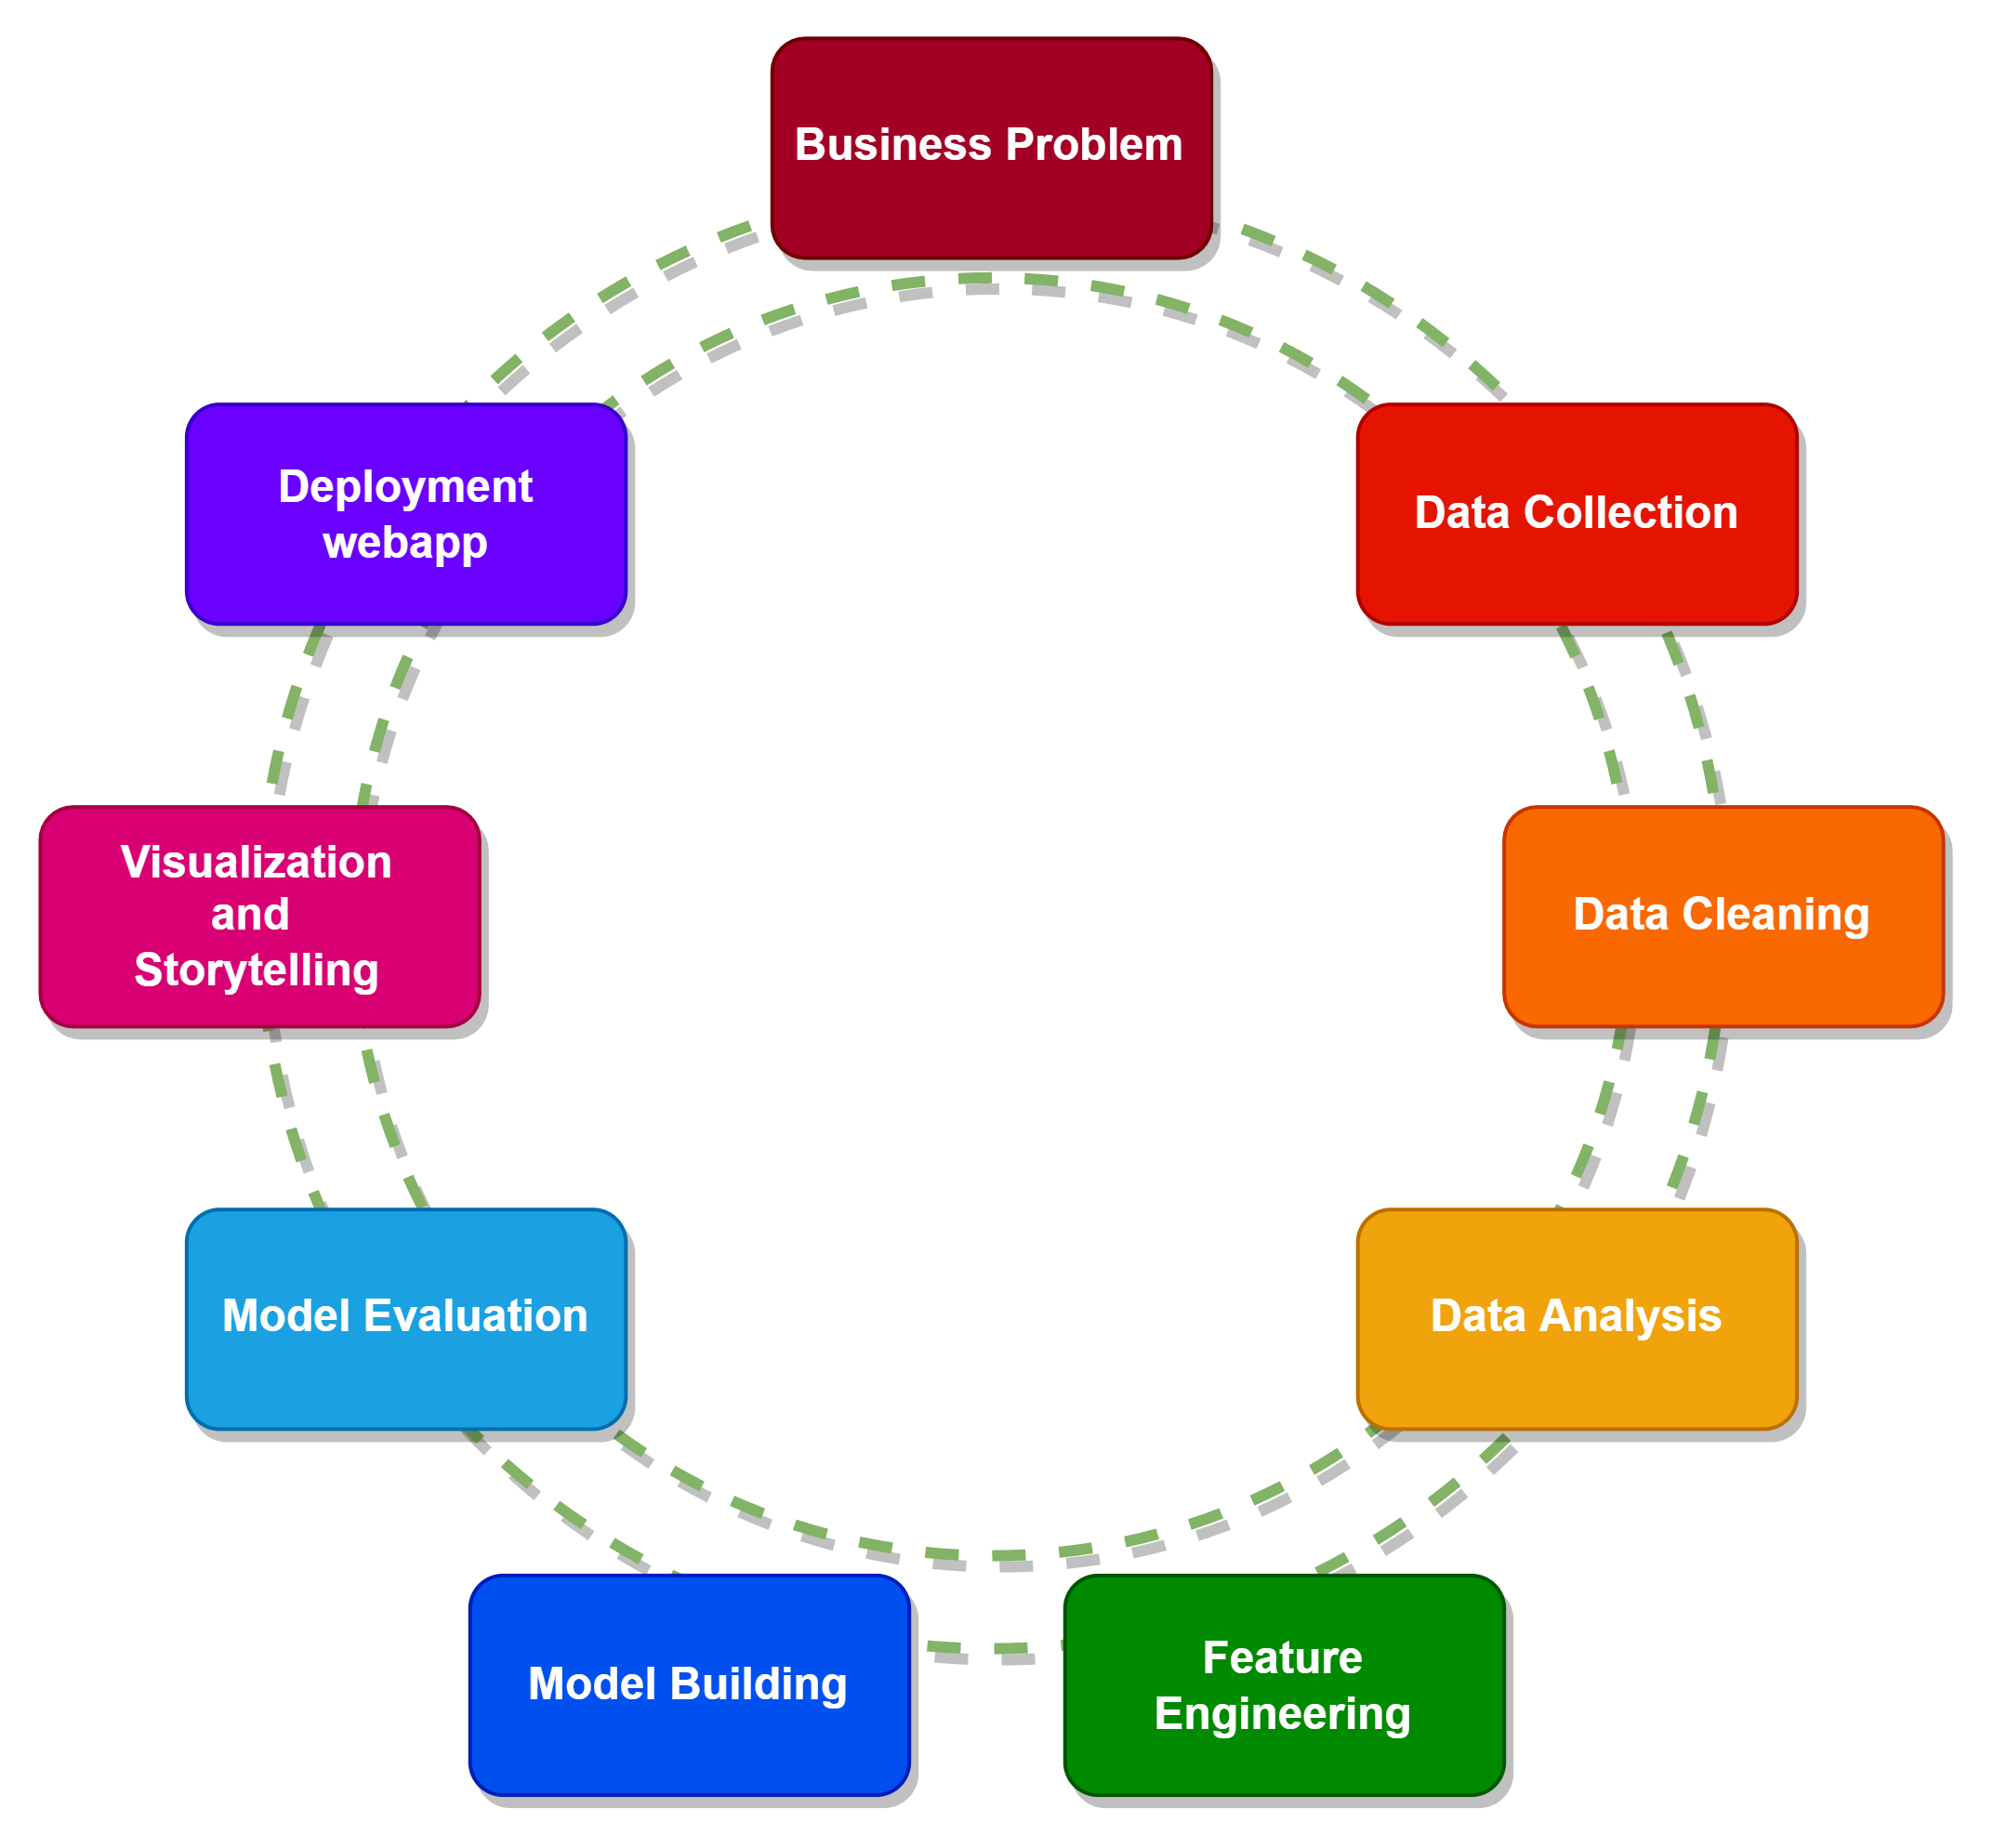

In [4]:
Image(filename='..\\..\\Assets\\Images\\Data Science Project Cycle.png', width=600, height=550)

Cross-Industry Standard Process for Data Science é um método cíclico de desenvolvimento
- Desde o primeiro ciclo vamos ter uma versão end-to-end da solução
- Vamos passar pelas etapas da análise várias vezes
- Temos mais velocidade na entrega de valor
- Conseguimos mapear os possíveis problemas

##### Procedimento padrão dos projetos de Data Science

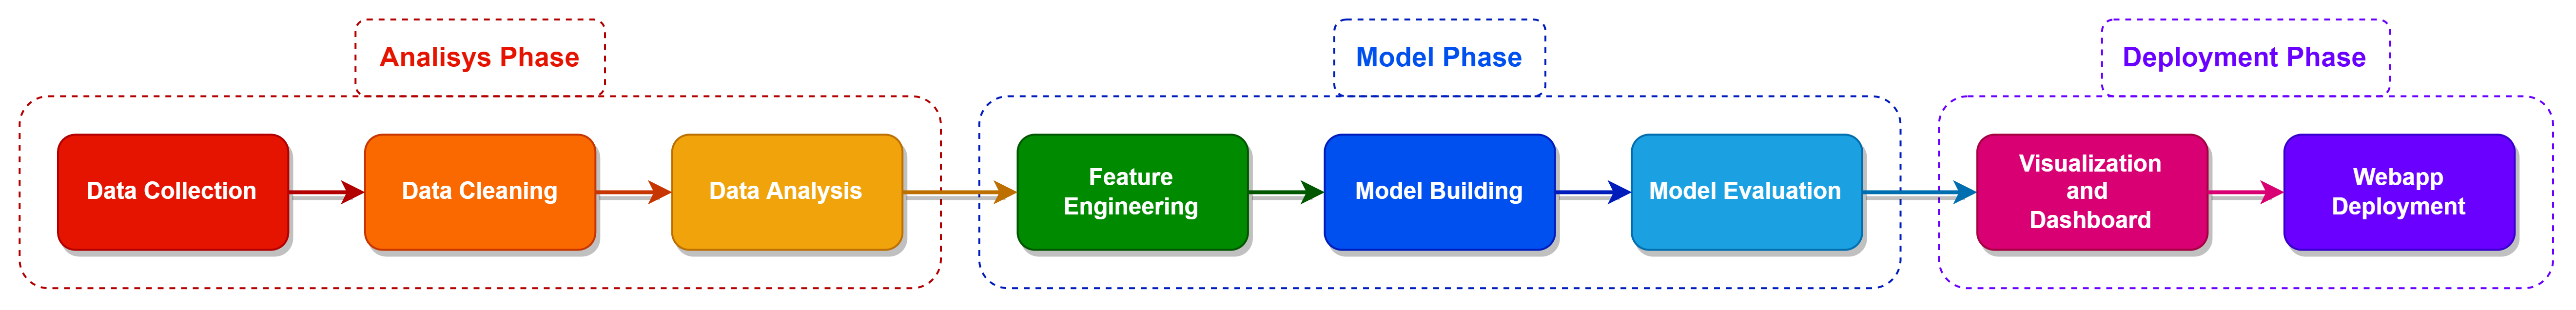

In [5]:
Image(filename='..\\..\\Assets\\Images\\Data Science Project Guide.png')

## Dataset

#### Files
* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* store.csv - supplemental information about the stores
#### Data fields
Descrição das colunas do arquivo CSV que serão utilizadas no projeto.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open:
    - 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    - a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: 
    - a, b, c, d
* Assortment - describes an assortment level: 
    - a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

No caso desta análise, a parte da coleta de dados ja foi feita e está disponível em um arquivo CSV, portanto vamos começar pela limpeza e descrição dos dados.

# Analysis Phase

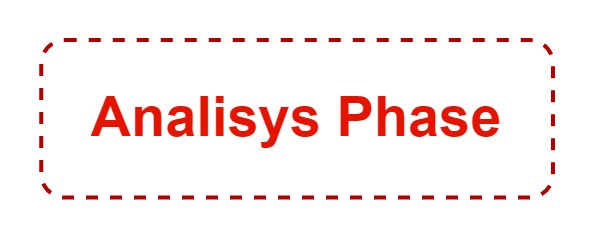

In [6]:
Image(filename='..\\..\\Assets\\Images\\Analysis Phase.png', width=250, height=100)

## Data Collection

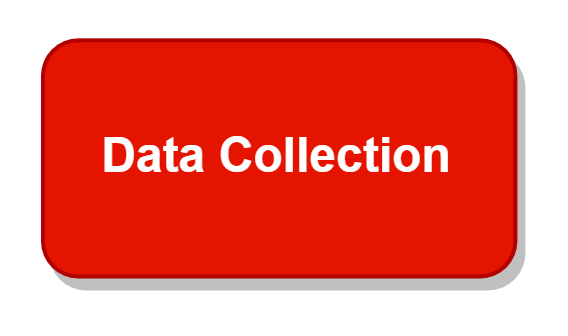

In [7]:
Image(filename='..\\..\\Assets\\Images\\Data Collection.png', width=200, height=100)

Como neste projeto não vamos usar comunicação com API ou SQL, vamos carregar os dados a partir de um arquivo .CSV

### Loading Data

In [8]:
# Ideally this section should go inside a "Data Collection" section of the notebook
try:
    df_sales_raw = pd.read_csv('..\\..\\..\\Data\\Dataset\\Raw\\train.csv', low_memory=False)
    df_stores_raw = pd.read_csv('..\\..\\..\\Data\\Dataset\\Raw\\store.csv', low_memory=False)
    print("Loading successful")
    df_raw = pd.merge(df_sales_raw, df_stores_raw, how = "left", on = "Store")
    print("Merge successful")
    #log.info("Merge successful")
except Exception as e:
    print("Error while merging: ", "/n", e)
    #log.error("Error while merging: ", e) 

Loading successful
Merge successful


## Data Cleaning

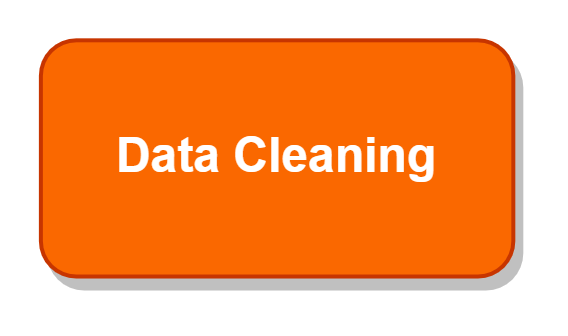

In [9]:
Image(filename='..\\..\\Assets\\Images\\Data Cleaning.png', width=200, height=100)

### Data Cleaning Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [10]:
df1 = df_raw.copy()
print("Checkpoint successful")

Checkpoint successful


In [11]:
df1.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

### Rename Columns

Vamos mudar as colunas para nomes mais significativos, visto que a partir dos dados brutos os nomes vem ideais para quem desenvolveu seu armazenamento, mas não para quem vai usar os dados numa análise futura.

Com isso os nomes ficam mais intuitivos e mais fluídos de entender ao longo da análise.

In [12]:
def get_column_names(df):
    column_names = pd.Series(df.columns.values)
    columns = pd.DataFrame(column_names)
    columns.columns = ['Columns']
    return columns, column_names
#Colunas = list(df_raw.columns)
#print(Colunas)
col_df, colunas = get_column_names(df1)
col_df

Columns
0                       Store
1                   DayOfWeek
2                        Date
3                       Sales
4                   Customers
5                        Open
6                       Promo
7                StateHoliday
8               SchoolHoliday
9                   StoreType
10                 Assortment
11        CompetitionDistance
12  CompetitionOpenSinceMonth
13   CompetitionOpenSinceYear
14                     Promo2
15            Promo2SinceWeek
16            Promo2SinceYear
17              PromoInterval

In [13]:
snakecase = lambda column: inflection.underscore(column) 
Colunas_new = list(map(snakecase, colunas))
df1.columns = Colunas_new
# df1.columns
col_df, colunas = get_column_names(df1)
col_df

Columns
0                          store
1                    day_of_week
2                           date
3                          sales
4                      customers
5                           open
6                          promo
7                  state_holiday
8                 school_holiday
9                     store_type
10                    assortment
11          competition_distance
12  competition_open_since_month
13   competition_open_since_year
14                        promo2
15             promo2_since_week
16             promo2_since_year
17                promo_interval

### Data Dimensions

Descobrir o tamanho o Dataset e conhecer as dimensões de com o que estamos trabalhando.

In [14]:
def get_dimensions(df):
    dimensions_1 = pd.Series(df1.shape[1])
    dimensions_2 = pd.Series(df1.shape[0])
    dimensions = pd.concat([dimensions_1, dimensions_2], axis=1)
    dimensions.columns = ['Columns', 'Rows']
    dimensions = dimensions.T
    dimensions.columns = ['Dimensions'] 
    return dimensions

get_dimensions(df1)

Dimensions
Columns          18
Rows        1017209

### Data Types

Verificar os tipos de dados e se necessitam de alguma transformação para tornar o processamento mais eficiente ou mesmo possível.

In [15]:
def get_dataset_types(df):
    df_types = pd.DataFrame(df.dtypes)
    df_types.reset_index(drop=True, inplace=True)
    df_types.columns = ["Data_Type"]
    df_types["Column"] = pd.Series(df.columns).values
    df_types.set_index("Column", inplace=True)
    #df_types.sort_values(by="Data_Type", ascending=False, inplace=True)
    df_types
    return df_types  
    
get_dataset_types(df1)

Data_Type
Column                                
store                            int64
day_of_week                      int64
date                            object
sales                            int64
customers                        int64
open                             int64
promo                            int64
state_holiday                   object
school_holiday                   int64
store_type                      object
assortment                      object
competition_distance           float64
competition_open_since_month   float64
competition_open_since_year    float64
promo2                           int64
promo2_since_week              float64
promo2_since_year              float64
promo_interval                  object

- Date está como **object**, vamos transformar para datetime para podermos utilizar as funções de data e hora do pandas mais facilmente.

In [16]:
df1["date"] = pd.to_datetime(df1["date"])
get_dataset_types(df1)

Data_Type
Column                                      
store                                  int64
day_of_week                            int64
date                          datetime64[ns]
sales                                  int64
customers                              int64
open                                   int64
promo                                  int64
state_holiday                         object
school_holiday                         int64
store_type                            object
assortment                            object
competition_distance                 float64
competition_open_since_month         float64
competition_open_since_year          float64
promo2                                 int64
promo2_since_week                    float64
promo2_since_year                    float64
promo_interval                        object

### Missing values

Vamos verificar se há dados faltantes no dataset.

In [17]:
def get_missing_values(df):
    missing_values = pd.DataFrame(df.isna().sum()) #isna, not isnull
    missing_values.reset_index(drop=True, inplace=True)
    missing_values.columns = ["Missing_Values"]
    missing_values["Column"] = pd.Series(df.columns).values
    missing_values.set_index("Column", inplace=True)
    missing_values.sort_values(by="Missing_Values", ascending=False, inplace=True)
    
    return missing_values

get_missing_values(df1)

Missing_Values
Column                                      
promo_interval                        508031
promo2_since_year                     508031
promo2_since_week                     508031
competition_open_since_year           323348
competition_open_since_month          323348
competition_distance                    2642
day_of_week                                0
promo2                                     0
assortment                                 0
store                                      0
school_holiday                             0
state_holiday                              0
promo                                      0
open                                       0
customers                                  0
sales                                      0
date                                       0
store_type                                 0

In [18]:
def get_broadview_miss_val(df):
    
    missing_values = pd.DataFrame(df.isna().sum()/df.shape[0])
    missing_values.reset_index(drop=True, inplace=True)
    
    missing_values.columns = ["Absolute Missing (%)"]
    missing_values["Column"] = pd.Series(df.columns).values
    # Make index be the column "Absolute Missing (%)"
    missing_values.reset_index(drop=True, inplace=True)
    missing_values.set_index("Column", inplace=True)
    
    # Calculating the percentage of missing values in relation to the total number of rows in the column
    column_missing = []
    column_total = []
    column_miss = []
    for column in df.columns:
        col_miss = df[column].isnull().sum()
        total_values = df[column].count()
        
        column_miss.append(col_miss)
        column_total.append(total_values) 
        column_missing.append((col_miss/total_values))
    #DataFrame building
    missing_values["Column Missing (%)"] = pd.Series(column_missing).values
    missing_values["Column Remaining (%)"] = -(pd.Series(column_missing).values-1)
    missing_values["Column Total"] = pd.Series(column_total).values
    missing_values["Column Missing"] = pd.Series(column_miss).values
    
    missing_values.sort_values(by="Absolute Missing (%)", ascending=False, inplace=True)
    missing_columns = list(missing_values.query("`Absolute Missing (%)` > 0").index)
    # In Query, Column names with spaces or special chars are required to be inside backticks, 
    # also known as grave accents (shift + <accent key>)
    # Alternative way: missing_columns = missing_values[missing_values["Absolute_Missing_%"] > 0].index.tolist()

    pd.options.display.float_format = '{:.2%}'.format
    return missing_values, missing_columns

missing_values, missing_columns_names = get_broadview_miss_val(df1)
missing_values

Absolute Missing (%)  Column Missing (%)  \
Column                                                                   
promo_interval                              49.94%              99.77%   
promo2_since_year                           49.94%              99.77%   
promo2_since_week                           49.94%              99.77%   
competition_open_since_year                 31.79%              46.60%   
competition_open_since_month                31.79%              46.60%   
competition_distance                         0.26%               0.26%   
day_of_week                                  0.00%               0.00%   
promo2                                       0.00%               0.00%   
assortment                                   0.00%               0.00%   
store                                        0.00%               0.00%   
school_holiday                               0.00%               0.00%   
state_holiday                                0.00%               0.00%   
promo                                        0.00%               0.00%   
open                                         0.00%               0.00%   
customers                                    0.00%               0.00%   
sales                                        0.00%               0.00%   
date                                         0.00%               0.00%   
store_type                                   0.00%               0.00%   

                              Column Remaining (%)  Column Total  \
Column                                                             
promo_interval                               0.23%        509178   
promo2_since_year                            0.23%        509178   
promo2_since_week                            0.23%        509178   
competition_open_since_year                 53.40%        693861   
competition_open_since_month                53.40%        693861   
competition_distance                        99.74%       1014567   
day_of_week                                100.00%       1017209   
promo2                                     100.00%       1017209   
assortment                                 100.00%       1017209   
store                                      100.00%       1017209   
school_holiday                             100.00%       1017209   
state_holiday                              100.00%       1017209   
promo                                      100.00%       1017209   
open                                       100.00%       1017209   
customers                                  100.00%       1017209   
sales                                      100.00%       1017209   
date                                       100.00%       1017209   
store_type                                 100.00%       1017209   

                              Column Missing  
Column                                        
promo_interval                        508031  
promo2_since_year                     508031  
promo2_since_week                     508031  
competition_open_since_year           323348  
competition_open_since_month          323348  
competition_distance                    2642  
day_of_week                                0  
promo2                                     0  
assortment                                 0  
store                                      0  
school_holiday                             0  
state_holiday                              0  
promo                                      0  
open                                       0  
customers                                  0  
sales                                      0  
date                                       0  
store_type                                 0

In [19]:
pd.options.display.float_format = '{:}'.format

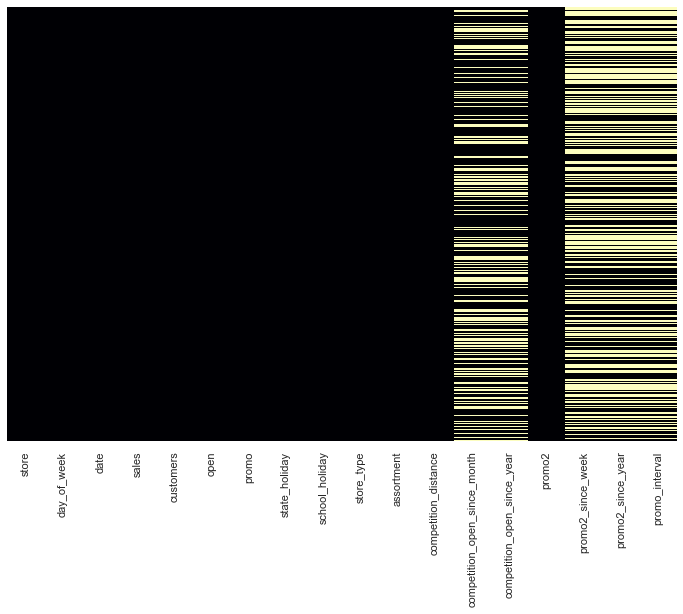

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(df1.isnull(), yticklabels=False, cbar=False, cmap='magma', ax=ax)
plt.show()

Existem três maneiras de tratar nossos dados faltantes:
- Descartando completamente os dados faltantes
- Utilizando o próprio comportamento da coluna para substituir os dados faltantes, utilizando de média ou mediana
- Entendimento do negócio, utilizando algumas regras que podem ter passado despercebidas para substituir os dados faltantes a partir de um método mais específico para este dataset

In [21]:
missing_columns_names

['promo_interval',
 'promo2_since_year',
 'promo2_since_week',
 'competition_open_since_year',
 'competition_open_since_month',
 'competition_distance']

Esta é uma das partes mais críticas da análise pois se os dados faltantes forem muitos, o método de substituição deles pode ser determinante no sucesso ou fracasso do modelo nas seções mais abaixo.

Como pudemos ver neste caso, temos 6 colunas com muitos dados faltantes, o método para corrigir isso deve ser bem pensado antes de qualquer coisa.

- Coluna 'competition_distance'
    - Descrição:
        * CompetitionDistance - distance in meters to the nearest competitor store

Se a distância de competidores não está presente, podemos assumir que:
- É porque não temos competidores mais próximos
- É porque os competidores mais próximos estão tão longe que o campo não foi preenchido

Isso sugere:

- Lojas em cidades pequenas, com pouco ou nenhum competidor
- Lojas em cidades grandes, mas com competidores muito afastados

Portanto, como esse valor pode representar que realmente não há competidores próximos, vamos substituir por um valor acima do valor máximo que temos disponível nessa coluna. Isso garante que não vamos contaminar os dados já existentes que tem o registro máximo, alterando o dataset e mudando a quantidade de registros com esse valor com ainda mais registros (dessa vez, artificiais), o que não é a intenção. 

Ao em vez de imitar o valor máximo já existente, vamos criar um valor ainda maior para representar as lojas mais isoladas, sem influenciar em lojas que realmente tiveram seus registros feitos.

In [22]:
# Column max value
df1["competition_distance"].max()

75860.0

- O valor máximo é 75 mil 860 metros, ou seja, 75.86 km.

Com competidor ausente, vamos escolher um número muito maior para criar essa nova categoria quando os registros estiverem faltando

Podemos usar 200000 metros, 3000000 metros etc

Função Lambda: 200000 metros em X se o registro for nan, caso contrário X permanece no valor original

Isso aplicado na coluna 'competition_distance' do DataFrame e retornado nela mesma.

In [23]:
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x )

- Coluna 'Competition_Open_Since_Month' e 'Competition_Open_Since_Year'
    - Descrição:
        * CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Se a data de abertura do competidor não está presente, podemos assumir que:
- É porque não temos competidores mais próximos
- É porque temos competidores próximos mas a gerencia da nossa loja não sabe quando o competidor abriu
    - Ela pode já ter sido aberta antes da nossa loja chegar na região


In [24]:
df1[["date","competition_open_since_month"]].sample()

date  competition_open_since_month
264167 2014-12-02                          10.0

In [25]:
df1[["date","competition_open_since_year"]].sample()

date  competition_open_since_year
40081 2015-06-26                       2011.0

- Para não deixar essas colunas sem registro, vamos copiar o mês e ano da data do registro em que elas constam.

In [26]:
# Month substitutions
df1['competition_open_since_month'] = \
    df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# Year substitutions
df1['competition_open_since_year'] = \
    df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

- Colunas 'promo2_since_week' e 'promo2_since_year'
    - Descrição:
        * Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

Pra entender melhor o que é a Promo2Since, vamos verificar as outras colunas relacionadas a promoções:

* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Pelo que vimos, a Promo é a promoção padrão das lojas, a Promo2 é a promoção estendida que a loja participa, a Promo2Since é a data 9ano e mês) em que a loja começou a participar da promoção estendida e a PromoInterval é o intervalo de meses que a promoção estendida é iniciada.

Se a data de participação na promoção estendida não está presente, podemos assumir que:
- A loja que consta no registro não participa da promoção estendida

- Para não deixar essas colunas sem registro, vamos copiar a semana e ano da data do registro em que elas constam.

In [27]:
#promo2_since_week           
df1['promo2_since_week'] = \
    df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = \
    df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

- Coluna 'PromoInterval'
    - Descrição:
        * PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

- As promoções são nos meses Fevereiro, Maio, Agosto e Novembro.
- Fora desses meses, a promoção não está ativa.

Como vimos nas colunas anteriores, se existem dados faltantes nessa coluna é por conta que as lojas não estavam participando da promoção ou não registraram participação.

- Para não deixar essa coluna sem registro, vamos criar duas novas colunas chamas 'current_month' (auxiliar) e 'active_promo' (principal), na qual vamos registrar se no dito mês a promoção está ativa ou não.

- Vamos preencher os valores faltantes da coluna 'PromoInterval' com 0, tornando ela uma coluna auxiliar.

- Mas não podemos simplesmente preencher todas as lojas com promoção ativa ou não sem critério, pois isso contaminaria os dados reais

- Ao em vez disso, vamos preencher na coluna 'is_promo' a partir das regras:
    - Se o intervalo de promoção estiver em 0, a promoção não está ativa, então 'is_promo' = 0
    - Se o intervalo de promoção estiver em 1, e mês de registro 'month_map' estiver contido em 'Promointerval', a promoção está ativa e está no mês certo de atividade, então 'is_promo' = 1

In [28]:
# Month mapping
current_month = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  
            7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['current_month'] = df1['date'].dt.month.map(current_month)

df1['active_promo'] = \
    df1[['promo_interval', 'current_month']]\
        .apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['current_month'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

Conferência final dos valores faltantes:

In [29]:
missing_values1, missing_columns_names1 = get_broadview_miss_val(df1)
missing_values1

Absolute Missing (%)  Column Missing (%)  \
Column                                                                   
store                                        0.00%               0.00%   
day_of_week                                  0.00%               0.00%   
current_month                                0.00%               0.00%   
promo_interval                               0.00%               0.00%   
promo2_since_year                            0.00%               0.00%   
promo2_since_week                            0.00%               0.00%   
promo2                                       0.00%               0.00%   
competition_open_since_year                  0.00%               0.00%   
competition_open_since_month                 0.00%               0.00%   
competition_distance                         0.00%               0.00%   
assortment                                   0.00%               0.00%   
store_type                                   0.00%               0.00%   
school_holiday                               0.00%               0.00%   
state_holiday                                0.00%               0.00%   
promo                                        0.00%               0.00%   
open                                         0.00%               0.00%   
customers                                    0.00%               0.00%   
sales                                        0.00%               0.00%   
date                                         0.00%               0.00%   
active_promo                                 0.00%               0.00%   

                              Column Remaining (%)  Column Total  \
Column                                                             
store                                      100.00%       1017209   
day_of_week                                100.00%       1017209   
current_month                              100.00%       1017209   
promo_interval                             100.00%       1017209   
promo2_since_year                          100.00%       1017209   
promo2_since_week                          100.00%       1017209   
promo2                                     100.00%       1017209   
competition_open_since_year                100.00%       1017209   
competition_open_since_month               100.00%       1017209   
competition_distance                       100.00%       1017209   
assortment                                 100.00%       1017209   
store_type                                 100.00%       1017209   
school_holiday                             100.00%       1017209   
state_holiday                              100.00%       1017209   
promo                                      100.00%       1017209   
open                                       100.00%       1017209   
customers                                  100.00%       1017209   
sales                                      100.00%       1017209   
date                                       100.00%       1017209   
active_promo                               100.00%       1017209   

                              Column Missing  
Column                                        
store                                      0  
day_of_week                                0  
current_month                              0  
promo_interval                             0  
promo2_since_year                          0  
promo2_since_week                          0  
promo2                                     0  
competition_open_since_year                0  
competition_open_since_month               0  
competition_distance                       0  
assortment                                 0  
store_type                                 0  
school_holiday                             0  
state_holiday                              0  
promo                                      0  
open                                       0  
customers                                  0  
sales      

### Type Conversion

Após algumas transformações, os tipos de dados das colunas podem mudar sem sabermos, então vamos verificar o estado atual das colunas e checar se precisamos fazer alguma conversão.

In [30]:
get_dataset_types(df1)

Data_Type
Column                                      
store                                  int64
day_of_week                            int64
date                          datetime64[ns]
sales                                  int64
customers                              int64
open                                   int64
promo                                  int64
state_holiday                         object
school_holiday                         int64
store_type                            object
assortment                            object
competition_distance                 float64
competition_open_since_month         float64
competition_open_since_year          float64
promo2                                 int64
promo2_since_week                    float64
promo2_since_year                    float64
promo_interval                        object
current_month                         object
active_promo                           int64

In [31]:
pd.options.display.float_format = '{:}'.format
df1.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1             0   
1      2            5 2015-07-31   6064        625     1      1             0   
2      3            5 2015-07-31   8314        821     1      1             0   
3      4            5 2015-07-31  13995       1498     1      1             0   
4      5            5 2015-07-31   4822        559     1      1             0   

   school_holiday store_type assortment  competition_distance  \
0               1          c          a                1270.0   
1               1          a          a                 570.0   
2               1          a          a               14130.0   
3               1          c          c                 620.0   
4               1          a          a               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                           9.0                       2008.0       0   
1                          11.0                       2007.0       1   
2                          12.0                       2006.0       1   
3                           9.0                       2009.0       0   
4                           4.0                       2015.0       0   

   promo2_since_week  promo2_since_year   promo_interval current_month  \
0               31.0             2015.0                0           Jul   
1               13.0             2010.0  Jan,Apr,Jul,Oct           Jul   
2               14.0             2011.0  Jan,Apr,Jul,Oct           Jul   
3               31.0             2015.0                0           Jul   
4               31.0             2015.0                0           Jul   

   active_promo  
0             0  
1             1  
2             1  
3             0  
4             0

- As colunas 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week' e 'promo2_since_year' são do tipo object.
- Na verdade quando vemos na tabela todas são do tipo int.
- As mudanças serão feitas nessas 4 colunas.
- Vamos também mudar os valores das colunas 'assortment' e 'state_holiday' para o que realmente representam segundo a legenda das colunas
    - Ao em vez de a, b, c, vamos colocar o tipo do assortment e o tipo do feriado

In [32]:
# Competiton Columns
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
    
# Promo Columns
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

# Assortment Column
df1['assortment'] = df1['assortment'].apply(lambda x: 'Basic' if x == 'a' else 'Extra' if x == 'b' else 'Extended')

# State holiday Column
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'Public' if x == 'a' else 'Easter' if x == 'b' else 'Christmas' if x == 'c' else 'Regular_Day')

In [33]:
get_dataset_types(df1)

Data_Type
Column                                      
store                                  int64
day_of_week                            int64
date                          datetime64[ns]
sales                                  int64
customers                              int64
open                                   int64
promo                                  int64
state_holiday                         object
school_holiday                         int64
store_type                            object
assortment                            object
competition_distance                 float64
competition_open_since_month           int64
competition_open_since_year            int64
promo2                                 int64
promo2_since_week                      int64
promo2_since_year                      int64
promo_interval                        object
current_month                         object
active_promo                           int64

### Feature Extraction

Vamos criar as colunas 'year', 'month', 'day', 'week_of_year' e 'year_week' (year/week) para ajudar na análise
Também vamos criar as colunas 'competition_since' com a data completa de quando o competidor foi aberto, a coluna 'promo_since' com a data completa de quando a promoção foi iniciada e também a coluna 'promo_time_week' com o tempo de duração da promoção em semanas.

- Na coluna 'competition_since', temos as duas outras colunas 'competition_open_since_month' e 'competition_open_since_year'
    - Vamos juntar as datas dessas duas e formar a data completa na coluna 'competition_since'

- Na coluna 'promo_since', temos as duas outras colunas 'promo2_since_week' e 'promo2_since_year'
    - Vamos juntar as datas dessas duas e formar a data completa na coluna 'promo_since'
    - Nesse caso não temos o mês, mas o número da semana do ano
    - Vamos primeiro juntar as duas informações numa única string, separando por '-'
    - Depois, vamos converter essa string para uma data em semanas

* A nova coluna 'promo_time_week' vai ser a diferença entre a data do registro e a data de início da promoção

In [34]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1['day'] = df1['date'].dt.day
df1['week_of_year'] = df1['date'].dt.weekofyear
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df1['promo_time_week'] = ((df1['date'] - df1['promo_since'])/7).apply(lambda x: x.days).astype(int)

### Variable Filtering

Vamos filtrar as variáveis para deixar o dataset mais leve e de acordo com as possíveis restrições de negócio que encontrarmos.

In [35]:
df1.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1   Regular_Day   
1      2            5 2015-07-31   6064        625     1      1   Regular_Day   
2      3            5 2015-07-31   8314        821     1      1   Regular_Day   
3      4            5 2015-07-31  13995       1498     1      1   Regular_Day   
4      5            5 2015-07-31   4822        559     1      1   Regular_Day   

   school_holiday store_type  ... active_promo  year  month  day  \
0               1          c  ...            0  2015      7   31   
1               1          a  ...            1  2015      7   31   
2               1          a  ...            1  2015      7   31   
3               1          c  ...            0  2015      7   31   
4               1          a  ...            0  2015      7   31   

   week_of_year  year_week  competition_since competition_time_month  \
0            31    2015-30         2008-09-01                     84   
1            31    2015-30         2007-11-01                     94   
2            31    2015-30         2006-12-01                    105   
3            31    2015-30         2009-09-01                     71   
4            31    2015-30         2015-04-01                      4   

  promo_since  promo_time_week  
0  2015-07-27                0  
1  2010-03-22              279  
2  2011-03-28              226  
3  2015-07-27                0  
4  2015-07-27                0  

[5 rows x 29 columns]

#### Row Filtering

- Não faz sentido considerar as vendas de lojas que estavam fechadas, pois isso sempre será zero
    - Vamos descartar todas as linhas com valor zero da coluna 'open'
- Não faz sentido considerar as vendas iguais a zero, pois isso é uma constante e geralmente está associado a uma loja fechada
    - Vamos descartar todas as linhas com valor zero da coluna 'sales'

In [36]:
df1 = df1[(df1['open'] != 0) & (df1['sales'] > 0)]

#### Column Filtering

- A coluna de clientes traz uma informação que só temos depois que a loja fechou, não podemos considerar isso se vamos prever vendas
    - É uma informação que só vamos ter no fechamento da loja e do mês, então em tese é algo que não temos acesso ainda
    - Vamos descartar a coluna 'customers' por completo
- Agora que já removemos as linhas com valor zero da coluna 'open', podemos descartar essa coluna completamente
    - Temos certeza que todas as linhas restantes tratam de lojas abertas, portanto a informação que essa coluna traz é redundante
- A coluna 'promo_interval' veio originalmente no dataset, mas foi usada de coluna auxiliar pra montar a coluna 'active_promo'
    - A informação que ela carrega não é mais necessária visto que já convertemos o que ela tinha numa coluna mais direta
    - Então vamos removê-la também

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'current_month']
df1 = df1.drop(cols_drop, axis=1)

## Data Analysis

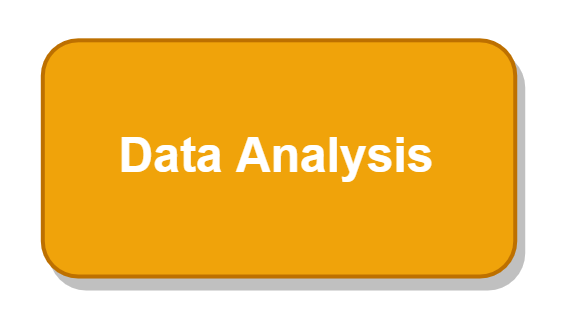

In [38]:
Image(filename='..\\..\\Assets\\Images\\Data Analysis.png', width=200, height=100)

### Data Analysis Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [39]:
df2 = df1.copy()
print("Checkpoint successful")

Checkpoint successful


In [40]:
df2.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday  \
0      1            5 2015-07-31   5263      1   Regular_Day               1   
1      2            5 2015-07-31   6064      1   Regular_Day               1   
2      3            5 2015-07-31   8314      1   Regular_Day               1   
3      4            5 2015-07-31  13995      1   Regular_Day               1   
4      5            5 2015-07-31   4822      1   Regular_Day               1   

  store_type assortment  competition_distance  ...  active_promo  year  month  \
0          c      Basic                1270.0  ...             0  2015      7   
1          a      Basic                 570.0  ...             1  2015      7   
2          a      Basic               14130.0  ...             1  2015      7   
3          c   Extended                 620.0  ...             0  2015      7   
4          a      Basic               29910.0  ...             0  2015      7   

   day  week_of_year  year_week  competition_since  competition_time_month  \
0   31            31    2015-30         2008-09-01                      84   
1   31            31    2015-30         2007-11-01                      94   
2   31            31    2015-30         2006-12-01                     105   
3   31            31    2015-30         2009-09-01                      71   
4   31            31    2015-30         2015-04-01                       4   

   promo_since  promo_time_week  
0   2015-07-27                0  
1   2010-03-22              279  
2   2011-03-28              226  
3   2015-07-27                0  
4   2015-07-27                0  

[5 rows x 25 columns]

### Descriptive Data Analysis

Na análise descritiva vamos ter uma visão geral das variáveis do dataset.

In [41]:
get_dataset_types(df2)

Data_Type
Column                                      
store                                  int64
day_of_week                            int64
date                          datetime64[ns]
sales                                  int64
promo                                  int64
state_holiday                         object
school_holiday                         int64
store_type                            object
assortment                            object
competition_distance                 float64
competition_open_since_month           int64
competition_open_since_year            int64
promo2                                 int64
promo2_since_week                      int64
promo2_since_year                      int64
active_promo                           int64
year                                   int64
month                                  int64
day                                    int64
week_of_year                           int64
year_week                             object
competition_since             datetime64[ns]
competition_time_month                 int32
promo_since                   datetime64[ns]
promo_time_week                        int32

In [42]:
num_attributes = df2.select_dtypes(include=['int64','float64'])
cat_attributes = df2.select_dtypes(exclude=['int32','int64','float64', 'datetime64[ns]'])

In [43]:
num_attributes.head()

store  day_of_week  sales  promo  school_holiday  competition_distance  \
0      1            5   5263      1               1                1270.0   
1      2            5   6064      1               1                 570.0   
2      3            5   8314      1               1               14130.0   
3      4            5  13995      1               1                 620.0   
4      5            5   4822      1               1               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  active_promo  year  month  day  \
0                 31               2015             0  2015      7   31   
1                 13               2010             1  2015      7   31   
2                 14               2011             1  2015      7   31   
3                 31               2015             0  2015      7   31   
4                 31               2015             0  2015      7   31   

   week_of_year  
0            31  
1            31  
2            31  
3            31  
4            31

In [44]:
cat_attributes.head()

state_holiday store_type assortment year_week
0   Regular_Day          c      Basic   2015-30
1   Regular_Day          a      Basic   2015-30
2   Regular_Day          a      Basic   2015-30
3   Regular_Day          c   Extended   2015-30
4   Regular_Day          a      Basic   2015-30

#### Numerical Attributes

Vamos analisar os atributos numéricos:

In [45]:
def get_num_statistics_metrics(df):
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T
    # Dispersion Metrics - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # concatenar
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Standart Deviation', 'Skew', 'Kurtosis']
    metrics.set_index('Attributes', inplace=True)
    return metrics

In [46]:
get_num_statistics_metrics(num_attributes)

Min      Max    Range                Mean  \
Attributes                                                                  
store                           1.0   1115.0   1114.0   558.4213739047633   
day_of_week                     1.0      7.0      6.0  3.5203496703926627   
sales                          46.0  41551.0  41505.0   6955.959133664481   
promo                           0.0      1.0      1.0  0.4463556064040704   
school_holiday                  0.0      1.0      1.0 0.19357769045098053   
competition_distance           20.0 200000.0 199980.0   5961.827514573548   
competition_open_since_month    1.0     12.0     11.0   6.787355300839238   
competition_open_since_year  1900.0   2015.0    115.0  2010.3311019994362   
promo2                          0.0      1.0      1.0 0.49866996392439994   
promo2_since_week               1.0     52.0     51.0  23.629083376562466   
promo2_since_year            2009.0   2015.0      6.0  2012.7979150529764   
active_promo                    0.0      1.0      1.0 0.15492018599186583   
year                         2013.0   2015.0      2.0  2013.8319452636267   
month                           1.0     12.0     11.0   5.845773848861475   
day                             1.0     31.0     30.0  15.835705606048762   
week_of_year                    1.0     52.0     51.0  23.646945891337356   

                              Median  Standart Deviation  \
Attributes                                                 
store                          558.0   321.7306708836755   
day_of_week                      3.0  1.7237113439388179   
sales                         6369.0    3103.81367747283   
promo                            0.0  0.4971139497510362   
school_holiday                   0.0  0.3951017188116395   
competition_distance          2330.0  12592.173650406758   
competition_open_since_month     7.0  3.3099147246976677   
competition_open_since_year   2012.0   5.502624557158492   
promo2                           0.0 0.49999823100395446   
promo2_since_week               22.0  14.288306419149363   
promo2_since_year             2013.0  1.6601237313386699   
active_promo                     0.0 0.36182858091399667   
year                          2014.0  0.7772709202598804   
month                            6.0  3.3239575150788254   
day                             16.0   8.683386618678142   
week_of_year                    23.0   14.38992238099804   

                                              Skew            Kurtosis  
Attributes                                                              
store                        0.0004258853753300726  -1.198836421115959  
day_of_week                   0.019309986500240153 -1.2593474310553268  
sales                           1.5949288357537479   4.854026585805923  
promo                           0.2158237117447827 -1.9534247525698838  
school_holiday                   1.551108685837245  0.4059391168300879  
competition_distance            10.134907719419795  145.28865847324673  
competition_open_since_month  -0.04845105686269242 -1.2318752812642153  
competition_open_since_year     -7.217322841840587  123.90307794649107  
promo2                        0.005320172576630447 -1.9999764331528147  
promo2_since_week              0.17039864752479575 -1.1948145454507564  
promo2_since_year              -0.7882956909672476 -0.1979112532398668  
active_promo                    1.9074249258509948  1.6382737283632114  
year                            0.3008648946223451 -1.2898738313711473  
month                            0.257706428287883 -1.0331899672891474  
day                           0.011112159484828367  -1.179670640596734  
week_of_year                   0.26228689657558196 -1.0257604596068617

São muitos dados, mas qual o nosso **foco**?
- Nosso objeto de estudo principal são as **vendas**, então a coluna **'Sales'** é a que vamos analisar

In [47]:
get_num_statistics_metrics(num_attributes).iloc[[2]]

Min     Max   Range              Mean  Median  Standart Deviation  \
Attributes                                                                      
sales      46.0 41551.0 41505.0 6955.959133664481  6369.0    3103.81367747283   

                         Skew          Kurtosis  
Attributes                                       
sales      1.5949288357537479 4.854026585805923

- Mediana e Média próximas, indica que não temos um deslocamento muito grande da curva normal de distribuição
- Isso é confirmado pela métrica de Skew que é muito próxima de 0, o que indica que os dados estão distribuídos muito próximos da normal e com pouca inclinação pra esquerda ou pra direita
- A métrica Skew também indica uma sutil inclinação para a esquerda, indicando o que chamamos de inclinação positiva
- A métrica de Curtose é maior que 0, o que indica que temos um pico mais alto na distribuição

Vamos visualizar tudo isso com um gráfico de dispersão:

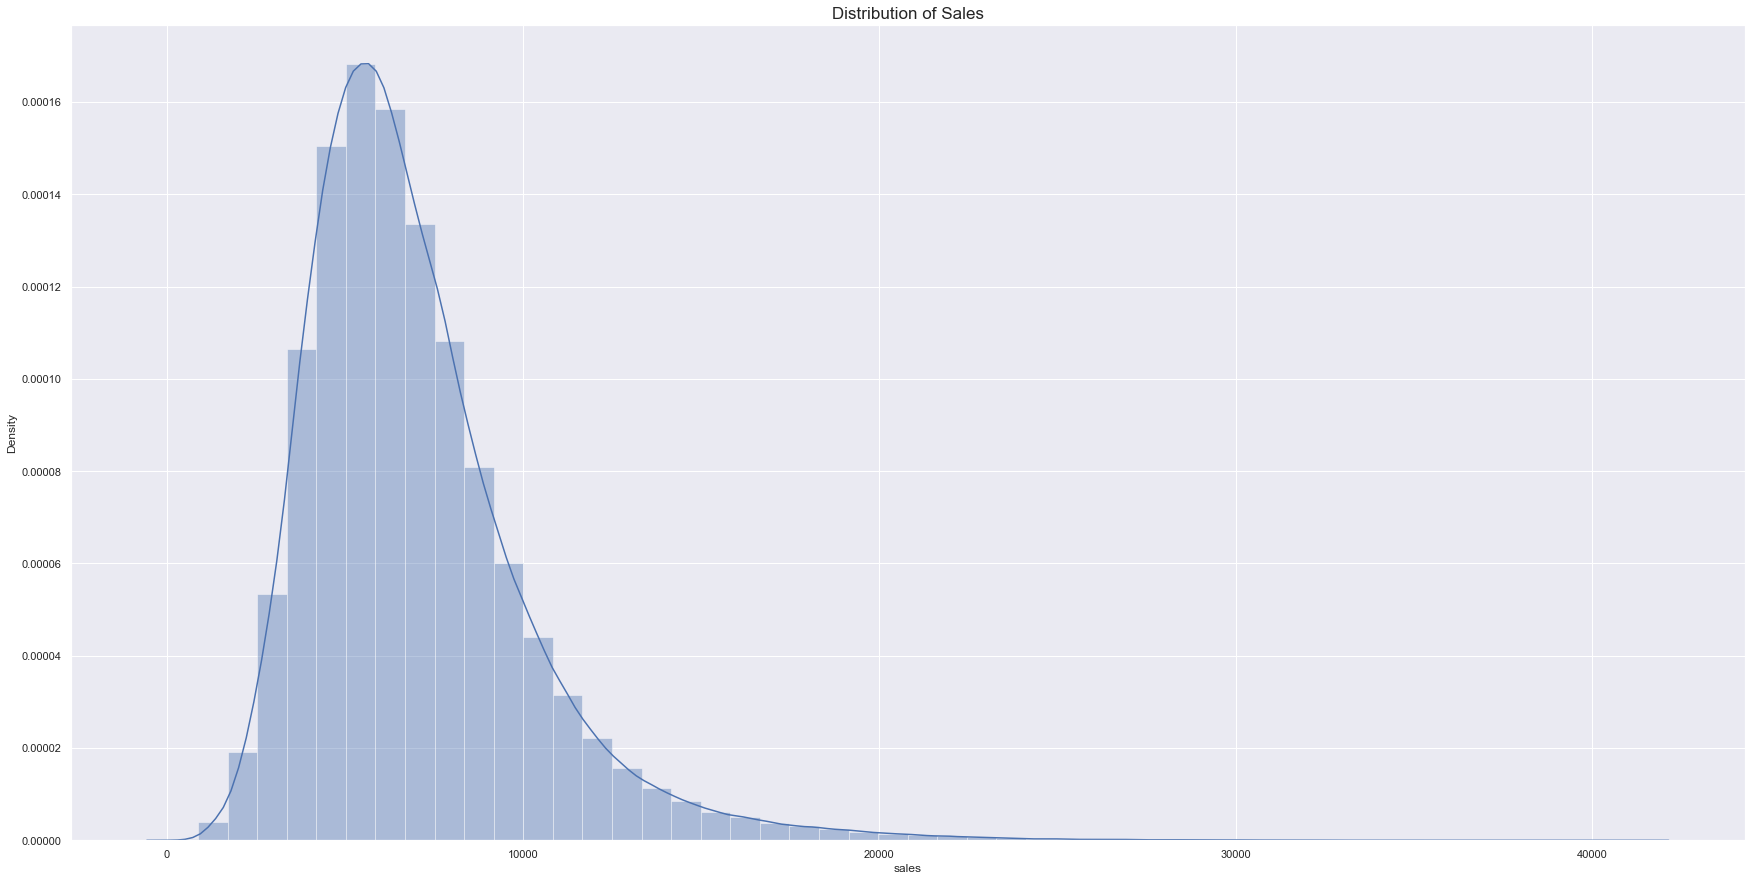

In [48]:
fig = sns.distplot(df2['sales'])
fig.set_title('Distribution of Sales', fontsize=17)
plt.show()

Como imaginamos, a distribuição é em maioria normal e inclinada à esquerda.

Vamos analisar a coluna 'competition_distance':

In [49]:
get_num_statistics_metrics(num_attributes).iloc[[5]]

Min      Max    Range              Mean  Median  \
Attributes                                                              
competition_distance 20.0 200000.0 199980.0 5961.827514573548  2330.0   

                      Standart Deviation               Skew           Kurtosis  
Attributes                                                                      
competition_distance  12592.173650406758 10.134907719419795 145.28865847324673

- Mediana e Média próximas, indica que não temos um deslocamento muito grande da curva normal de distribuição
- Métrica Skew é muito positiva, indicando uma inclinação forte para a esquerda, a inclinação positiva.
- A métrica de Curtose é muito maior que 0, o que indica que temos um forte pico na distribuição.
- Essa inclinação forte pra esquerda nos diz que a curva está bem distante de uma curva normal.

Vamos visualizar tudo isso com um gráfico de dispersão:

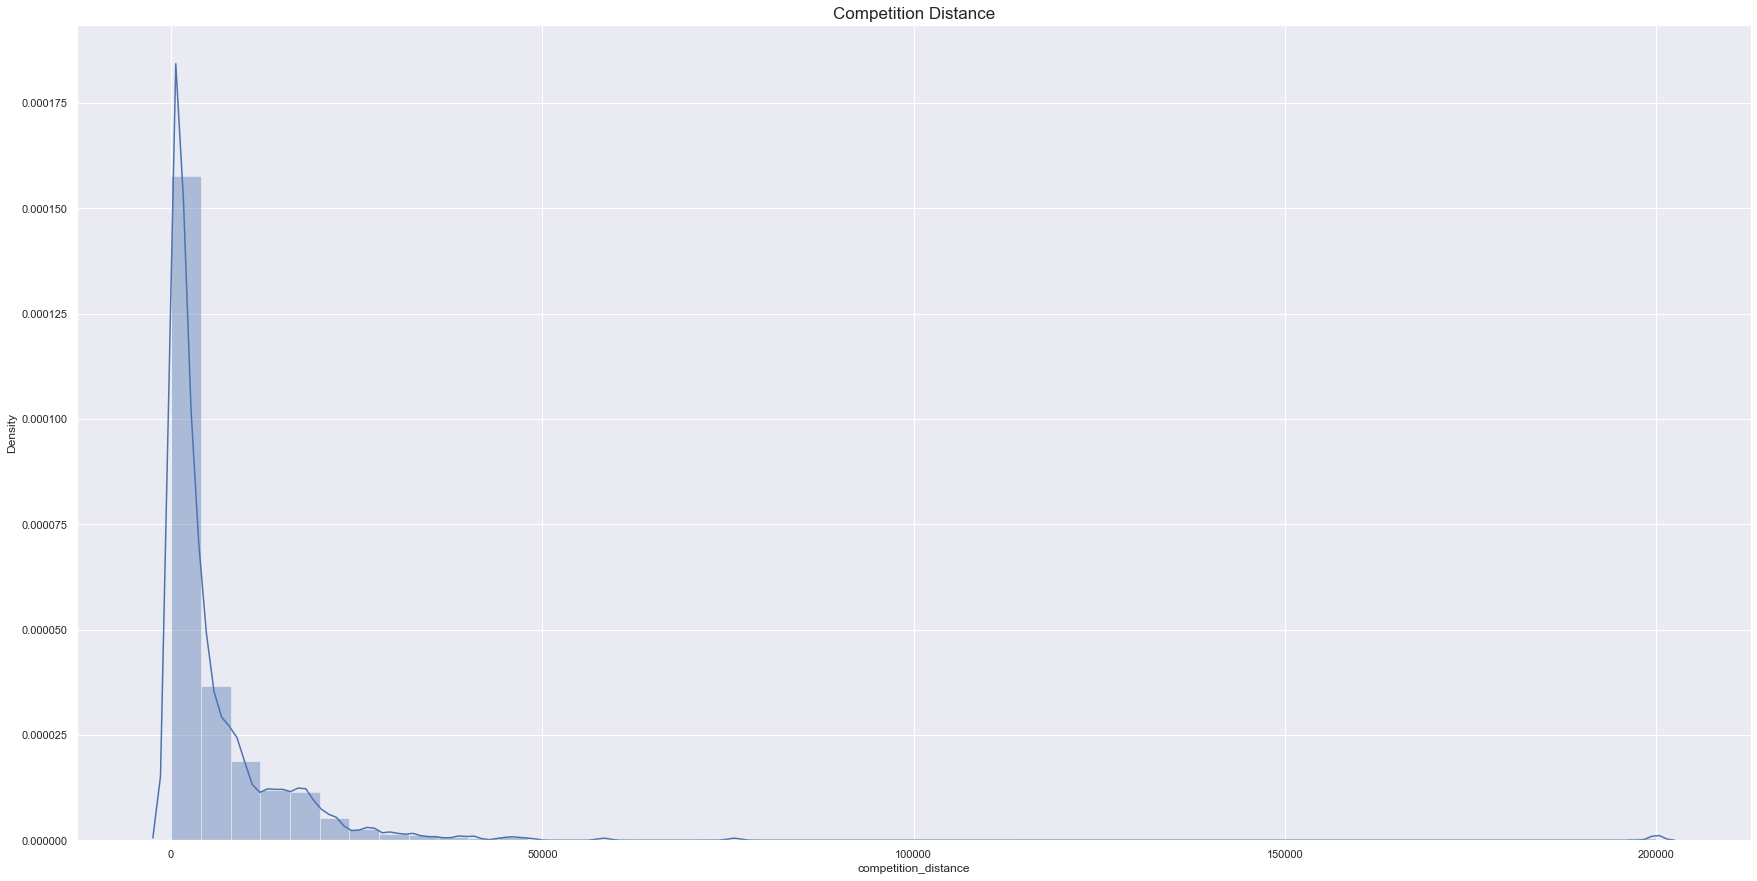

In [50]:
fig = sns.distplot(df2['competition_distance'])
fig.set_title('Competition Distance', fontsize=17)
plt.show()

#### Categorical Attributes

Vamos analisar os atributos categóricos:

In [51]:
def get_unique_cat_values(df):
    unique_values = pd.DataFrame(df.apply(lambda x: x.unique().shape[0]))
    unique_values.reset_index(drop = True, inplace = True)
    unique_values.columns = ["Unique Values Count"]
    unique_values["Unique Values"] = df.apply(lambda x: x.unique()).values
    unique_values["Attributes"] = pd.Series(df.columns).values
    unique_values.set_index("Attributes", inplace = True)
    
    return unique_values
get_unique_cat_values(cat_attributes)

Unique Values Count  \
Attributes                           
state_holiday                    4   
store_type                       4   
assortment                       3   
year_week                      137   

                                                   Unique Values  
Attributes                                                        
state_holiday           [Regular_Day, Public, Easter, Christmas]  
store_type                                          [c, a, d, b]  
assortment                              [Basic, Extended, Extra]  
year_week      [2015-30, 2015-29, 2015-28, 2015-27, 2015-26, ...

- As melhores variáveis para analisarmos são 'state_holiday', 'assortment' e 'store_type', pois tem poucas variações (a,b,c etc) e são mais relevantes para o nosso objeto de estudo.
- As variáveis 'promo_interval' e 'current_month' são categóricas, mas são auxiliares, ajudando apenas na construção de outros dados, não são relevantes em si pois são apenas conjuntos de meses sozinhas.

Vamos avaliar as vendas com relação aos feriados:

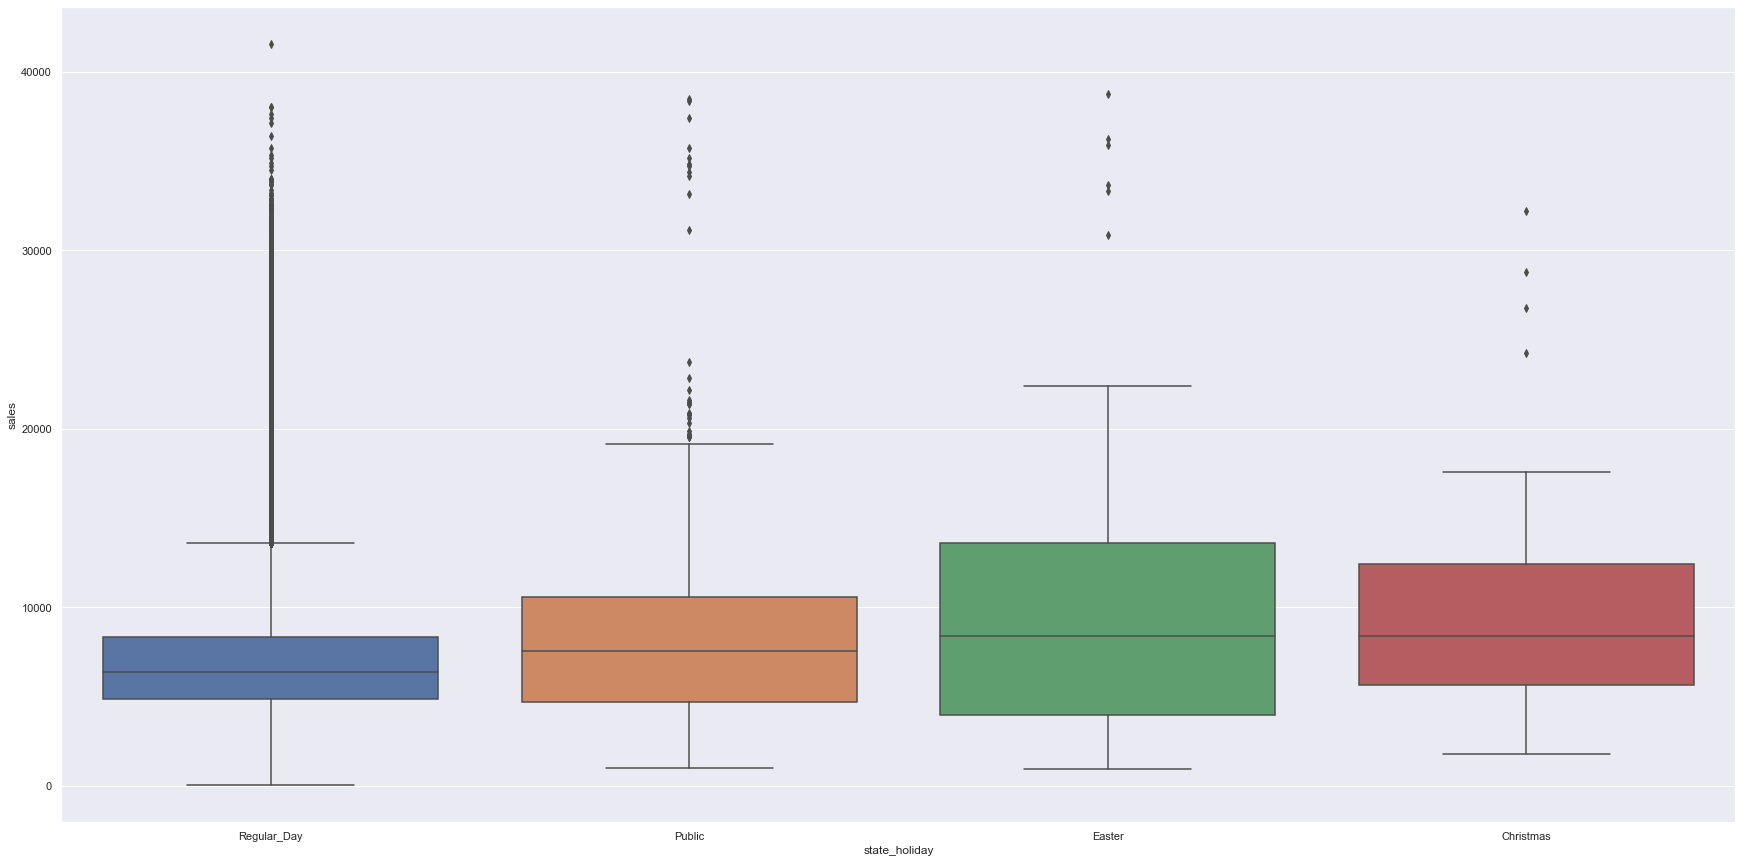

In [52]:
sns.boxplot(x='state_holiday', y='sales', data=df2)
plt.show()

Vamos analisar as três variáveis 'state_holiday', 'assortment' e 'store_type' nos gráficos:

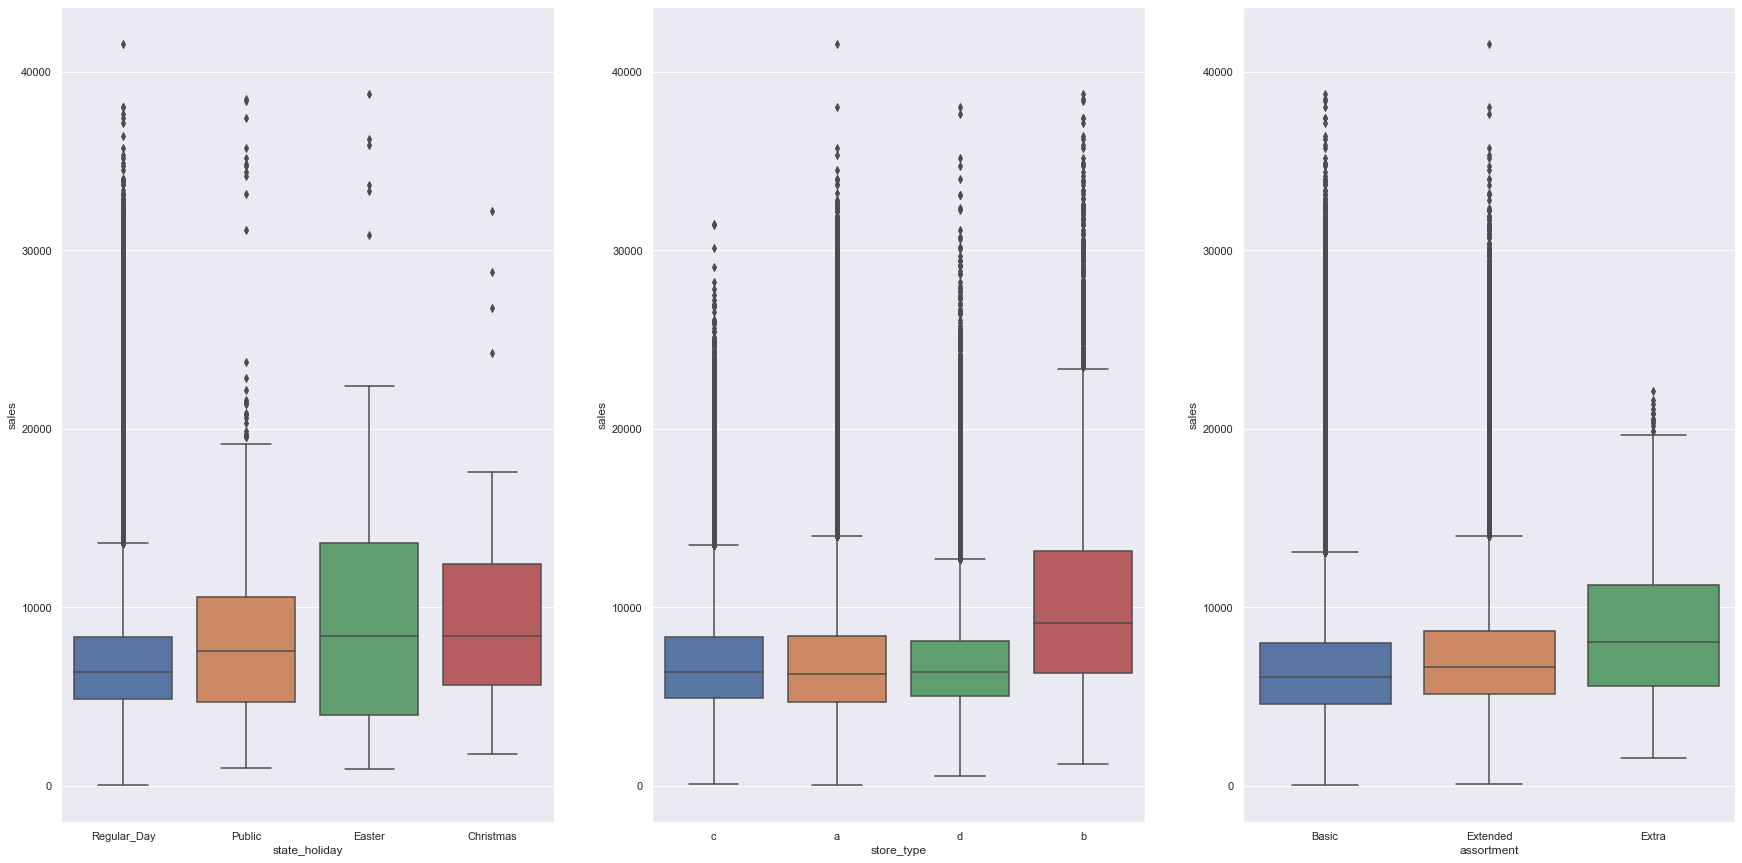

In [53]:
relevant_data = df2[(df2['state_holiday'] != '0') & (df2['sales'] > 0)]
# doesn't work relevant_data = df2.query('(sales > 0) & (state_holiday != 0)')
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=relevant_data)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=relevant_data)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=relevant_data)
plt.show()

Vendas por feriado:

* As medianas dos 3 tipos de feriados (**público**, **páscoa** e **natal**) são muito próximas
* Nos feriados **públicos** e de **páscoa** temos um equilíbrio de vendas nos quartis superior e inferior (25 e 75)
* Nos feriado de **natal** temos mais vendas no quartil superior (75)
* Nos feriados de **páscoa** temos a maior máxima de vendas entre todos os feriados
    - Também temos o maior range de vendas entre todos os feriados, indicando que clientes de todos os tipos compram produtos

* A diferença em volume geral de vendas e vendas máximas entre os dias normais e feriados é muito visível, com o range chegando a triplicar na páscoa e dobrar no natal

Vendas por tipo de loja:

* O tipo de loja **B** tem mais vendas no quartil superior (75)
    - Também possui o valor máximo mais alto entre todas as lojas
    - Também possui o maior número de outliers superiores entre todas as lojas, indicando grandes vendas
    - Pode indicar que fica em bairros/cidades mais populosas e ricas
    - Pode indicar que é focada em produtos mais caros e público mais rico

* Os tipos de loja **A** e **C** tem um equilíbrio de vendas nos quartis superior e inferior (25 e 75) e são ambos muito semelhantes em nível de vendas
* O tipo de loja **A** tem uma mediana de vendas inferior a todas as outras lojas
    - No entanto seu valor máximo de vendas é praticamente igual ao valor máximo de vendas das lojas tipo **C**
    - Pode indicar que ambas ficam em bairros próximos (pela quantidade de vendas, indica poder de compra similar), mas com sensíveis diferenças de preços/custo de vida
    - Pode indicar que são o tipo mais comum de lojas, que compõe o grosso do lucro nas vendas por atenderem a maior parte dos clientes com rendas média/média-alta
    - Por esse fator, parecem ser as lojas mais importantes da rede

* O tipo de loja **D** tem um equilíbrio de vendas nos quartis superior e inferior (25 e 75)
    - Possui a maior concentração de valor de vendas entre todas as lojas
    - Possui a menor máxima de vendas entre todas as lojas
    - Pode indicar que atende um público mais específico ou que seja um modelo de loja mais novo, que ainda não se provou para o público
    - Ou que funciona em cidades pequenas, com pouca variação de preços e poucas promoções
    - Pode também haver um grande número de concorrentes próximos da loja tipo D, o que reduz o lucro drasticamente
    - Parece ser a loja que menos dá lucro na rede, pois é mais barata e só vende produtos de uma faixa de preço especifíca, limitando o faturamento
    - Substituição da loja tipo **D** por lojas tipo **A** e **C**, com maior variedade de vendas e preços pode ser uma opção

Vendas por tipo de estoque:

* Os tipos de estoque **Basic** e **Extended** tem distribuição similar e equilibrada nos quartis superior e inferior (25 e 75)
    - **Extended** tem mais vendas que **Basic** em números absolutos

* O tipo de estoque **Extra** tem concentração de vendas equilibrada nos quartis superior e inferior (25 e 75)
    - No entanto é o tipo de estoque que maior máxima de vendas entre todos os tipos de estoque
    - Indicando que o produto pode passar por frequentes promoções 
    - Ou ter produtos com preços mais altos
    - Ou ter os produtos mais populares de toda a rede

### Hypotheses Mindmap

Para chegarmos na Análise Exploratória de Dados e sabermos por qual caminho vamos nos guiar, vamos fazer uma lista de hipóteses a partir de três perguntas para analisar na próxima parte do projeto:

- Qual o fenômeno modelado?
- Quais são os agentes que atuam sobre o fenômeno de interesse?
- Quais são os atributos dos agentes?

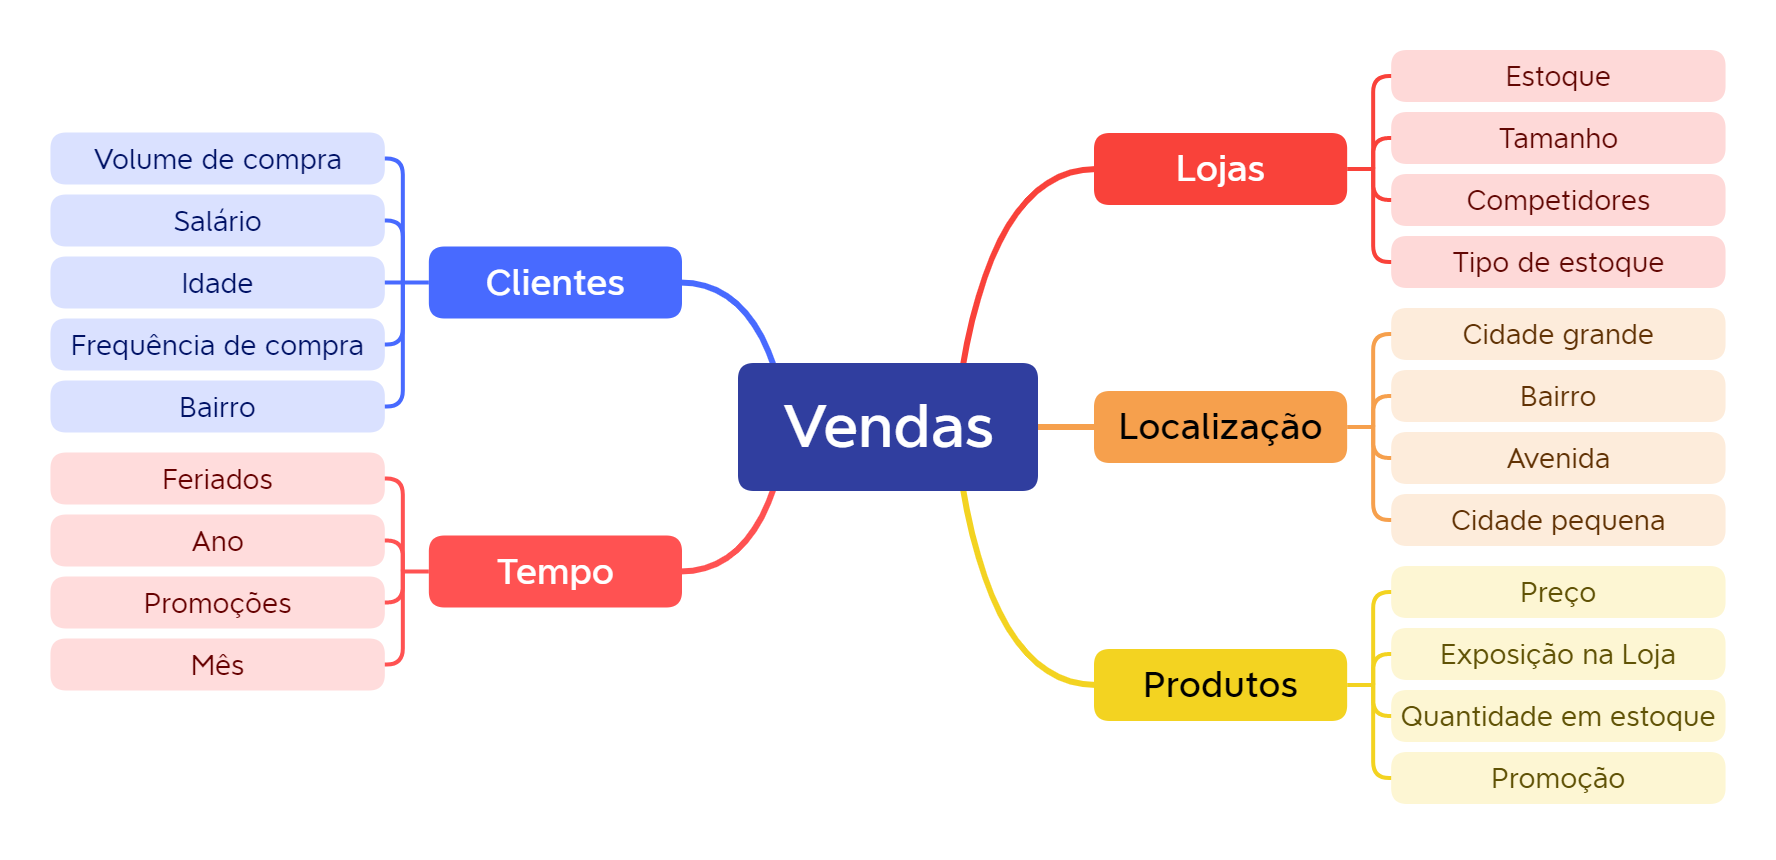

In [54]:
Image(filename='..\\..\\Assets\\Images\\Hypotheses Mindmap.png', width=900, height=500)

#### Hypotheses Questions

- Qual o fenômeno modelado?
    - Vendas diárias
- Quais são os agentes que atuam sobre o fenômeno de interesse?
    - Clientes
    - Lojas
    - Localização
    - Tempo

- Quais são os atributos dos agentes?
    - Clientes
        - Volume de compra
        - Salário
        - Idade
        - Frequência de compra
        - Bairro
    - Lojas
        - Estoque
        - Tamanho
        - Competidores
        - Localização
    - Localização
        - Bairro
        - Cidade grande
        - Cidade pequena
        - Avenida
    - Tempo
        - Feriados
        - Ano
        - Promoções
        - Mês

#### Store Hypotheses

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

#### Product Hypotheses

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.

#### Time Hypotheses

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

#### Selected Hypotheses List

Esta é a lista final de hipóteses que vamos procurar confirmar ou falsear com a análise exploratória de dados, a partir das conclusões dessas hipóteses vamos ter uma idéia melhor de como vamos construir o modelo de previsão de vendas.

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

### Exploratory Data Analysis

Vamos listar primeiro quais os objetivos que queremos alcançar com a análise exploratória de dados.

#### Objectives

- Ganhar experiência de negócio
- Validar hipóteses de negócio
- Perceber quais variáveis são importantes para o modelo
- Gerar Insigths sobre o negócio 

##### Insights

Os insights de dados referem-se à compreensão profunda que um indivíduo ou empresa obtém ao analisar seus dados sobre um problema específico de negócio.

Essa compreensão profunda ajuda empresas a tomarem melhores decisões do que aquelas que se baseiam somente no instinto.

Insights podem ser gerados de duas formas:
- Surpresa
    - Uma conclusão nova surge através dos dados
- Quebra de crenças
    - Quando uma crença empírica sobre o negócio é refutada, e provada que na verdade era o inverso ou que era completamente inválida e sem base sólida

##### Processes

Quais são os processos que vamos utilizar para analisar os dados?

- Análise Univariada
- Análise Bivariada
- Análise Multivariada

Qual o objetivo de cada processo?

- Análise Univariada
    - Como é essa variável?
    - Mínimos, máximos, distribuição, range
- Análise Bivariada
    - Como essa variável impacta na variável alvo?
    - Correlação, validação de hipóteses
- Análise Multivariada
    - Como as variáveis se relacionam?
    - Correlação, validação de hipóteses

#### Univariate Analysis

Vamos analisar as variáveis de forma univariada, ou seja, vamos analisar apenas uma variável por vez, sem relação com outras.

##### Target Variable

Vamos analisar a distribuição das vendas diárias.

Text(0.5, 1.0, 'Distribution of Sales')

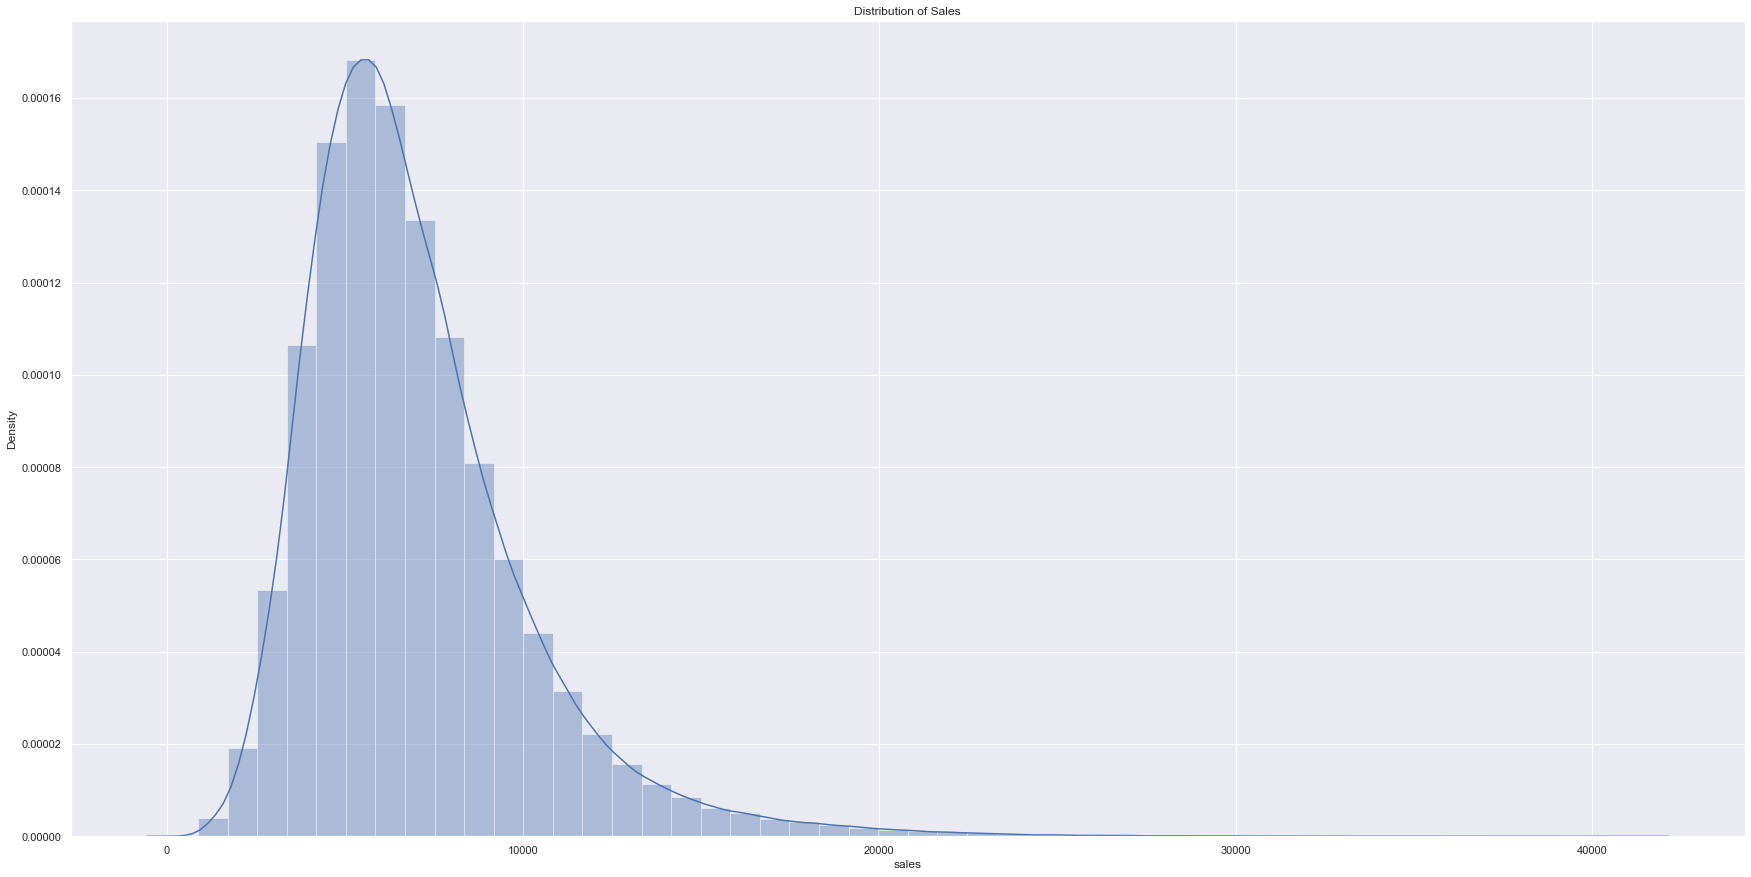

In [55]:
sns.distplot(df2['sales']).set_title('Distribution of Sales') 

Text(0.5, 1.0, 'Distribution of Sales')

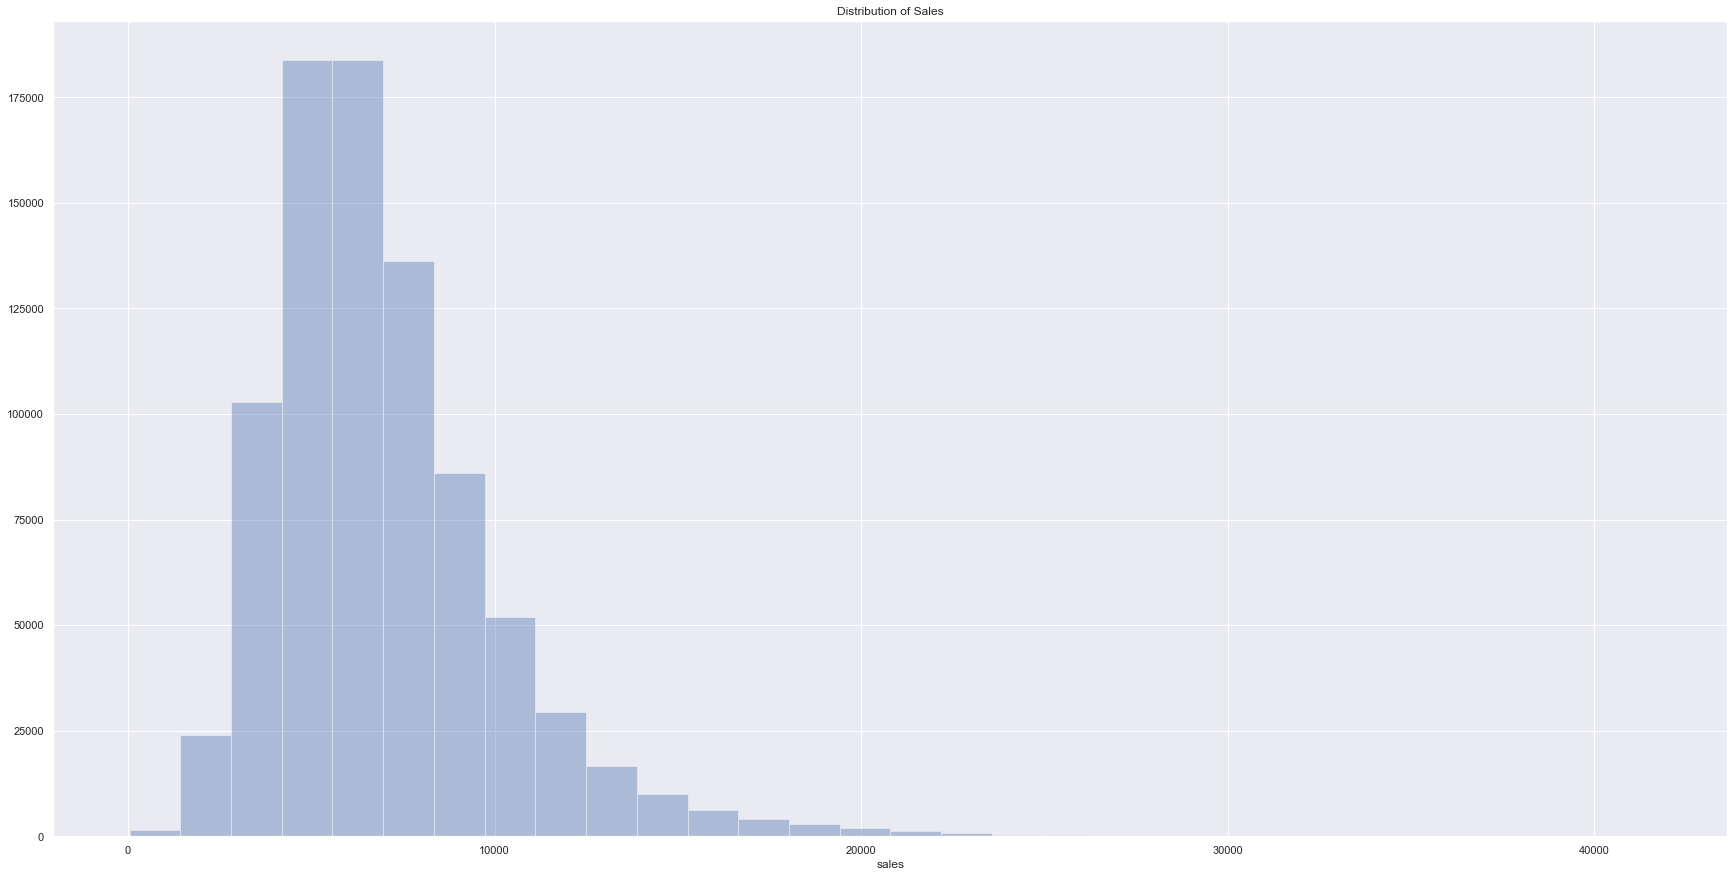

In [56]:
sns.distplot(df2['sales'], kde=False, bins=30).set_title('Distribution of Sales')

Curva próxima da normal, com inclinação à esquerda.

##### Numerical Variables

Vamos analisar as características das variáveis numéricas.

In [57]:
num_attributes = df2.select_dtypes(include=['int64','float64'])
num_attributes.head()

store  day_of_week  sales  promo  school_holiday  competition_distance  \
0      1            5   5263      1               1                1270.0   
1      2            5   6064      1               1                 570.0   
2      3            5   8314      1               1               14130.0   
3      4            5  13995      1               1                 620.0   
4      5            5   4822      1               1               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  active_promo  year  month  day  \
0                 31               2015             0  2015      7   31   
1                 13               2010             1  2015      7   31   
2                 14               2011             1  2015      7   31   
3                 31               2015             0  2015      7   31   
4                 31               2015             0  2015      7   31   

   week_of_year  
0            31  
1            31  
2            31  
3            31  
4            31

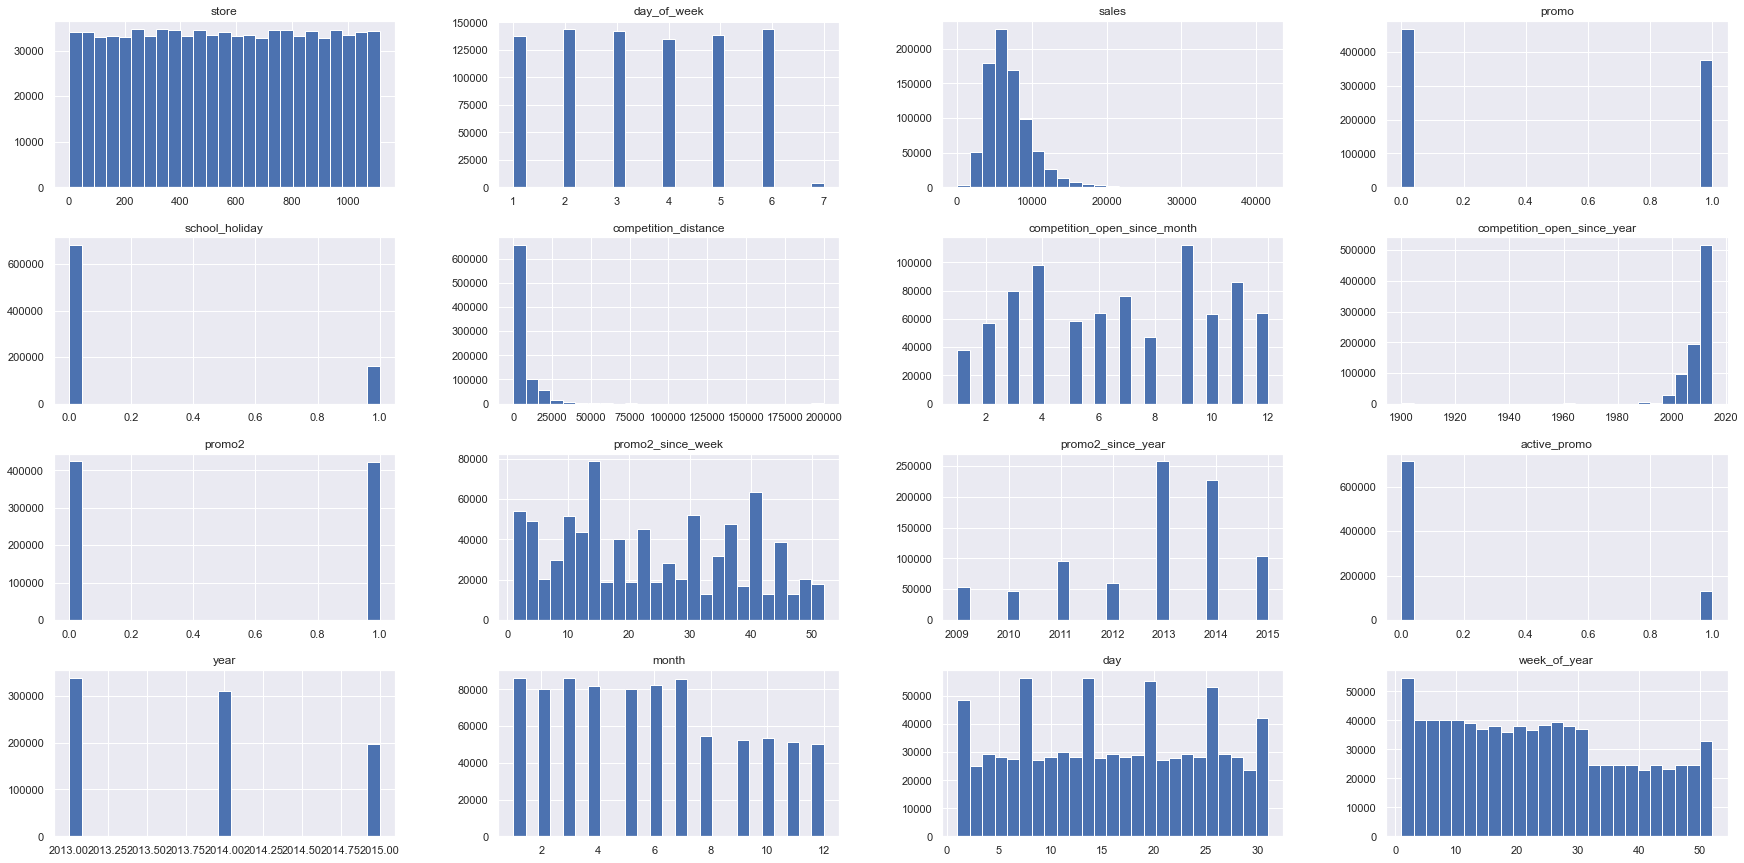

In [58]:
fig = plt.figure(figsize = (30,15))
ax = fig.gca()
num_attributes.hist(ax = ax,bins=25)
plt.show()

Conclusões nessa fase:
- As datas de abertura de competidores seguem um padrão, tendo pico nos meses de Abril e Setembro
- A partir do ano de 2013 tivemos uma explosão no número de promoções

Quanto as outras, precisamos compará-las com outras variáveis para tirar conclusões mais consistentes.

##### Categorical Variables

Vamos analisar as características das variáveis categóricas.

Vamos fazer 6 gráficos, analisando as vendas contra:
- Cada feriado
- Cada tipo de loja
- Cada tipo de estoque

No caso dos feriados, descartamos os dias normais do gráfico

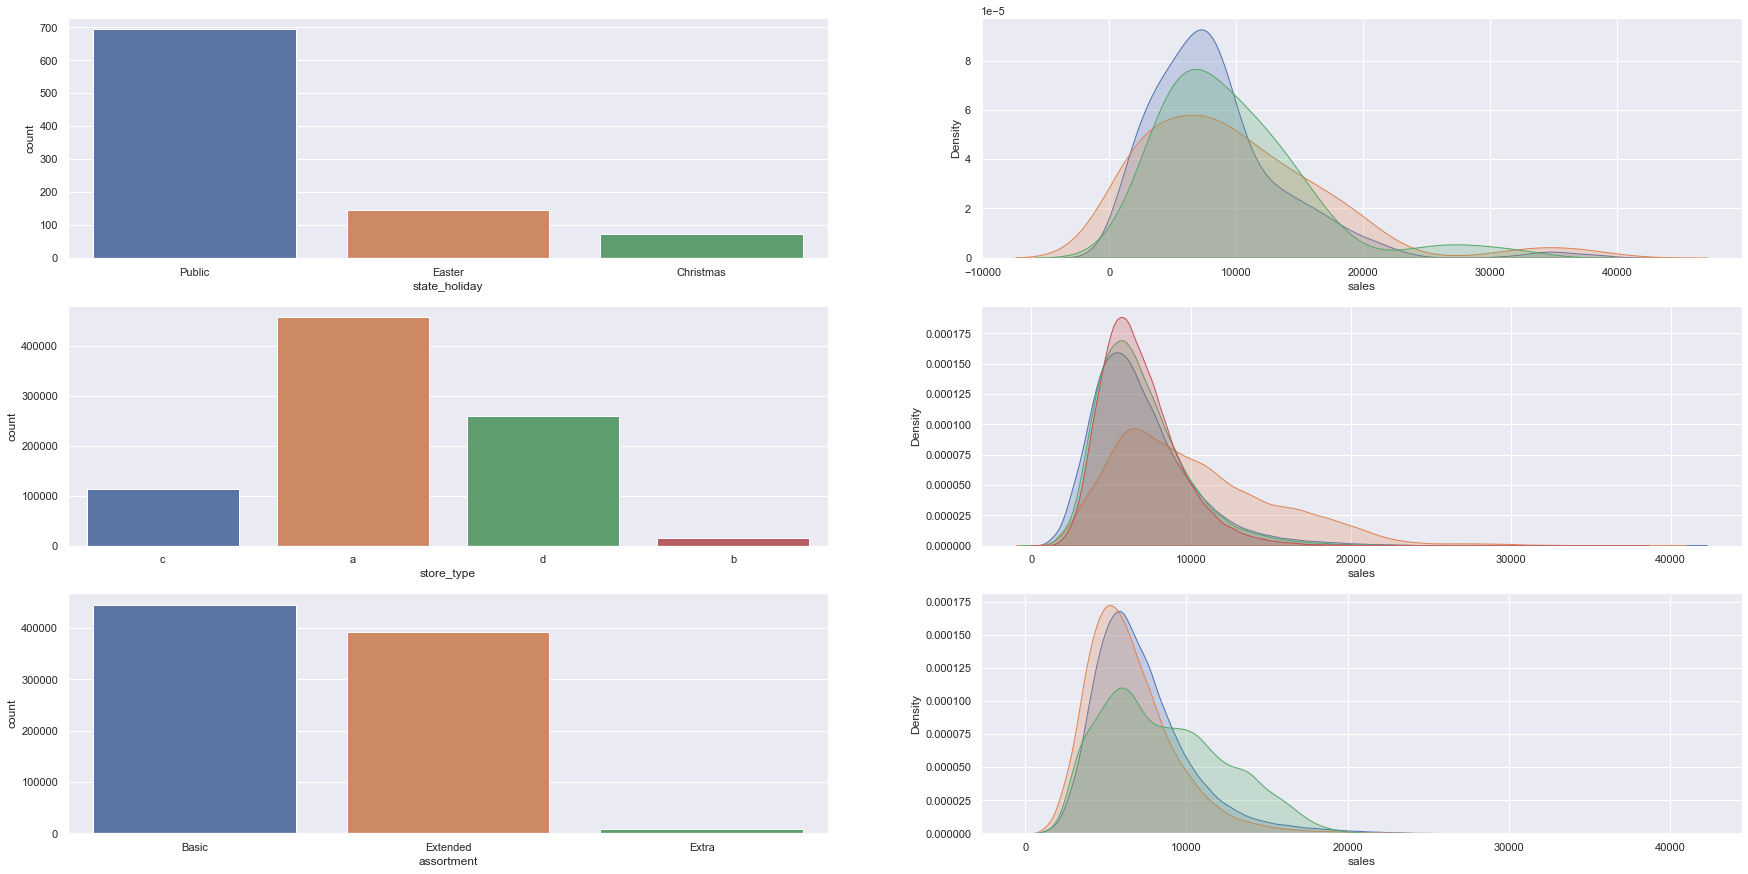

In [59]:
# state_holiday
fig = plt.figure(figsize=(30,15))

plt.subplot(3, 2, 1)
a = df2[df2['state_holiday'] != 'Regular_Day']
sns.countplot(a['state_holiday'])
# Descartamos dias normais

# Holidays
plt.subplot(3, 2, 2)
sns.kdeplot(df2[df2['state_holiday'] == 'Public']['sales'], label='Public Holiday', shade=True)
sns.kdeplot(df2[df2['state_holiday'] == 'Easter']['sales'], label='Easter Holiday', shade=True)
sns.kdeplot(df2[df2['state_holiday'] == 'Christmas']['sales'], label='Christmas Holiday', shade=True)

# Store Types
plt.subplot(3, 2, 3)
sns.countplot(df2['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df2[df2['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df2[df2['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df2[df2['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df2[df2['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df2['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df2[df2['assortment'] == 'Extended']['sales'], label='Extended', shade=True)
sns.kdeplot(df2[df2['assortment'] == 'Basic']['sales'], label='Basic', shade=True)
sns.kdeplot(df2[df2['assortment'] == 'Extra']['sales'], label='Extra', shade=True)
plt.show()

Conclusões nessa fase:

- Os feriados públicos são os que geram as vendas de valor mais alto
- O feriado de páscoa é o que gera vendas com range de valores mais distribuído
- Os estoques Basic e Extended tem quantidade similar
- Apesar da loja B estar em pouca quantidade, ela é a maior responsável por vendas de valor alto na rede
- Pela loja A ser a em maior quantidade, ela é a maior responsável pelas vendas gerais na rede
- O tipo de estoque Extra, apesar de ser o em menor quantidade, é o maior responsável por vendas gerais na rede
- Os tipos Basic e Extended tem uma distribuição de vendas mais uniforme e são responsáveis por vendas de valor mais alto

#### Bivariate Analysis

A partir daqui começamos a tirar conclusões mais consistentes sobre as nossas hipóteses. Vamos testar uma por uma e ver quais se confirmam.

##### **H1.** Lojas com maiores estoques (sortimentos) deveriam vender mais.

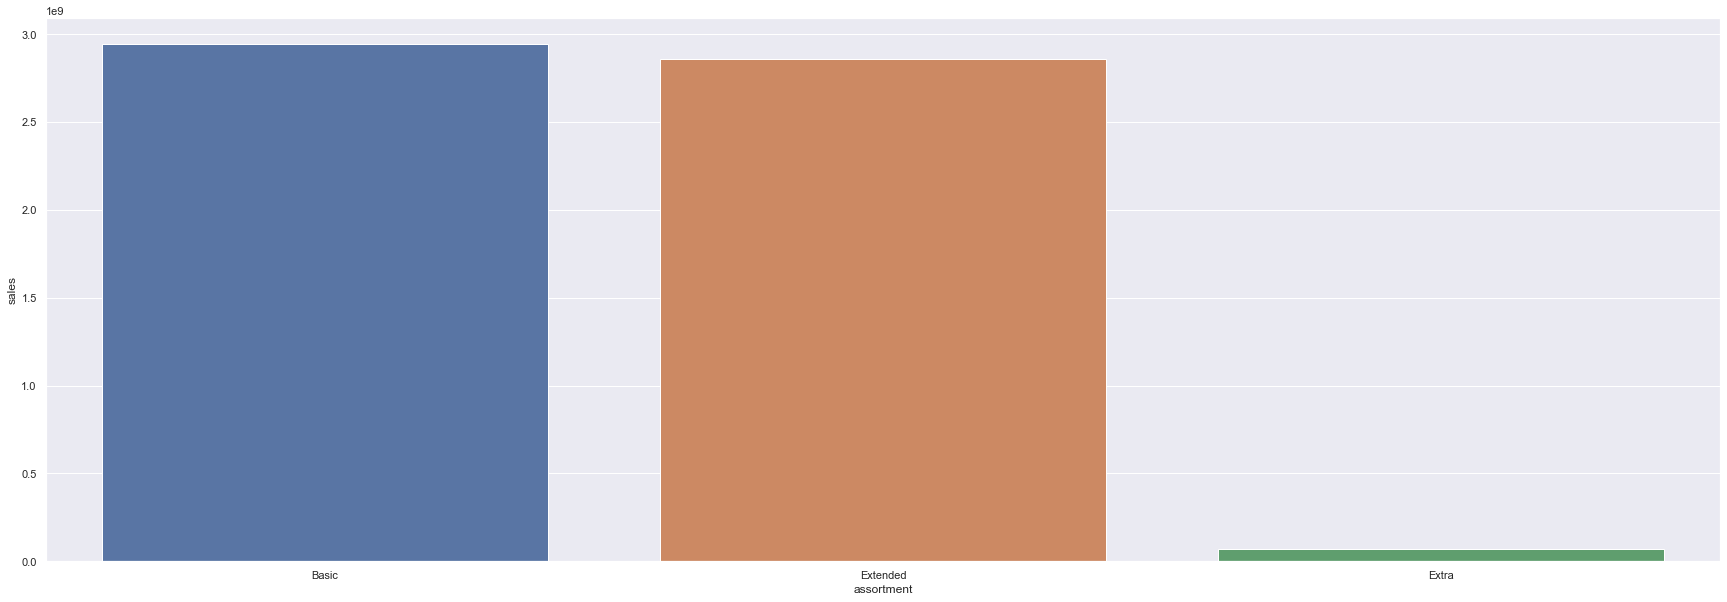

In [60]:
fig = plt.figure(figsize = (30,10))

relevant_data = df2[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=relevant_data )
plt.show()

Conclusões por este gráfico:

- Como podemos ver, lojas com estoques do tipo **Basic** e **Extended** são as que mais vendem, além de ter vendas muito similares.
- Mas lojas tem tem um estoque a mais, além destes, o estoque **Extra**, vendem muito menos que as outras.

Vamos reoganizar os dados para fazer um gráfico por tempo para confirmar essa conclusão.

In [61]:
relevant_data = df2[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
relevant_data.head()

year_week assortment     sales
0   2013-00      Basic  13434262
1   2013-00   Extended  12425669
2   2013-00      Extra    269404
3   2013-01      Basic  26007250
4   2013-01   Extended  22917693

Temos a tabela por tempo, vamos reorganizar mais uma vez para deixar o índice absoluto nas Semanas do Ano e jogar os tipos de estoque como colunas, nos dando o valor de vendas por tipo de estoque naquela semana

In [62]:
relevant_data = relevant_data.pivot(index='year_week', columns='assortment', values='sales')
relevant_data.head()

assortment     Basic  Extended   Extra
year_week                             
2013-00     13434262  12425669  269404
2013-01     26007250  22917693  350279
2013-02     17970974  16029584  377207
2013-03     24392076  21243431  404662
2013-04     19972891  18130077  363061

Agora temos a tabela que queríamos, tratando os tipos de estoque por semana e mostrando o valor de vendas por tipo de estoque naquela semana.

Dito isto, vamos ver como fica este gráfico:

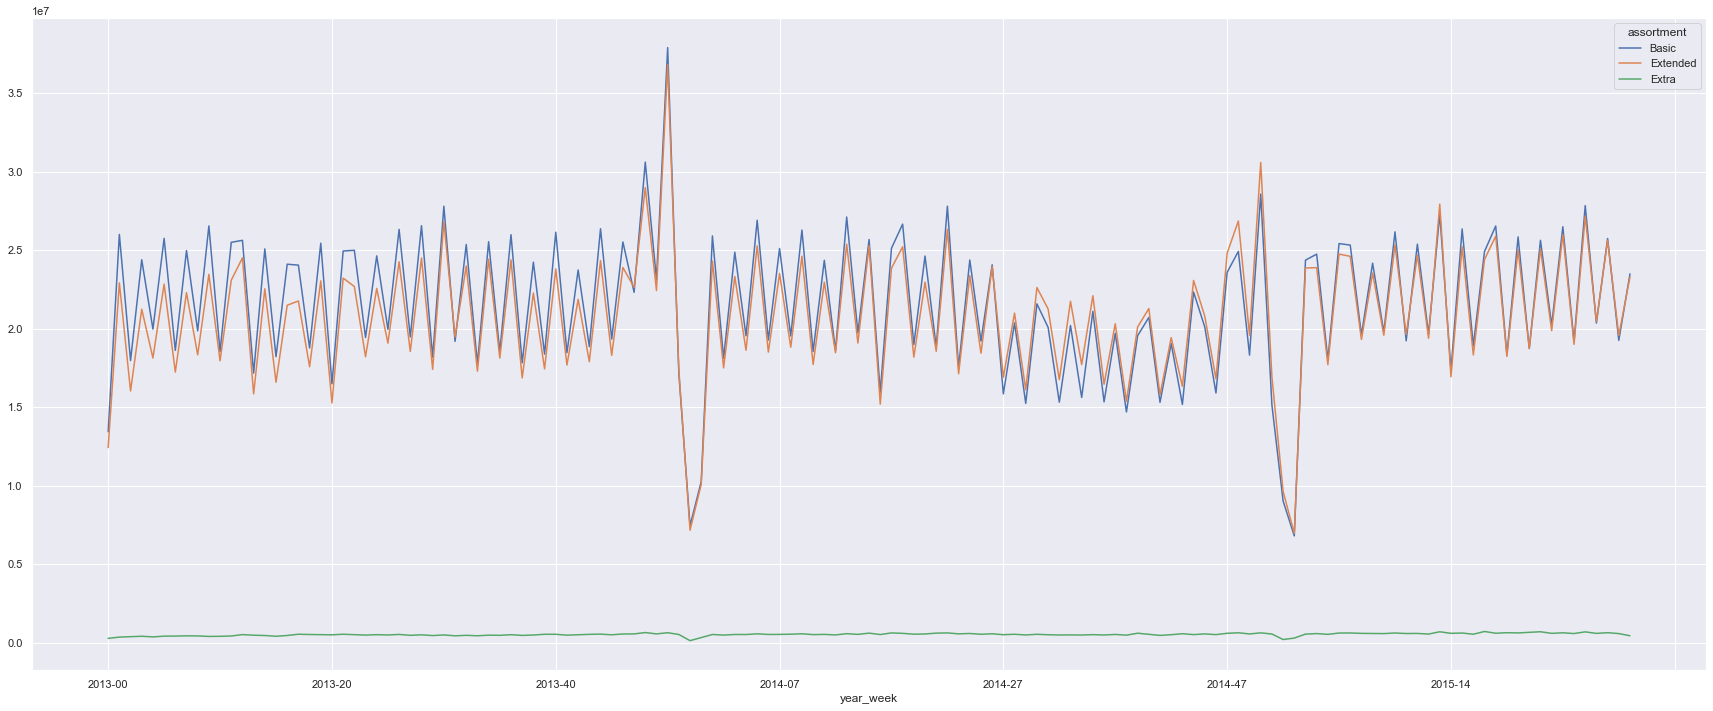

In [63]:
relevant_data.plot(figsize = (30,12))
plt.show()

- As vendas mais altas são do tipo **Basic** e **Extended**, e no tipo **Extra** temos visível diferença: as vendas são muito menores.

In [64]:
relevant_data = relevant_data.drop(['Basic', 'Extended'], axis=1)
relevant_data.head()

assortment   Extra
year_week         
2013-00     269404
2013-01     350279
2013-02     377207
2013-03     404662
2013-04     363061

Plotando apenas o tipo **Extra** :

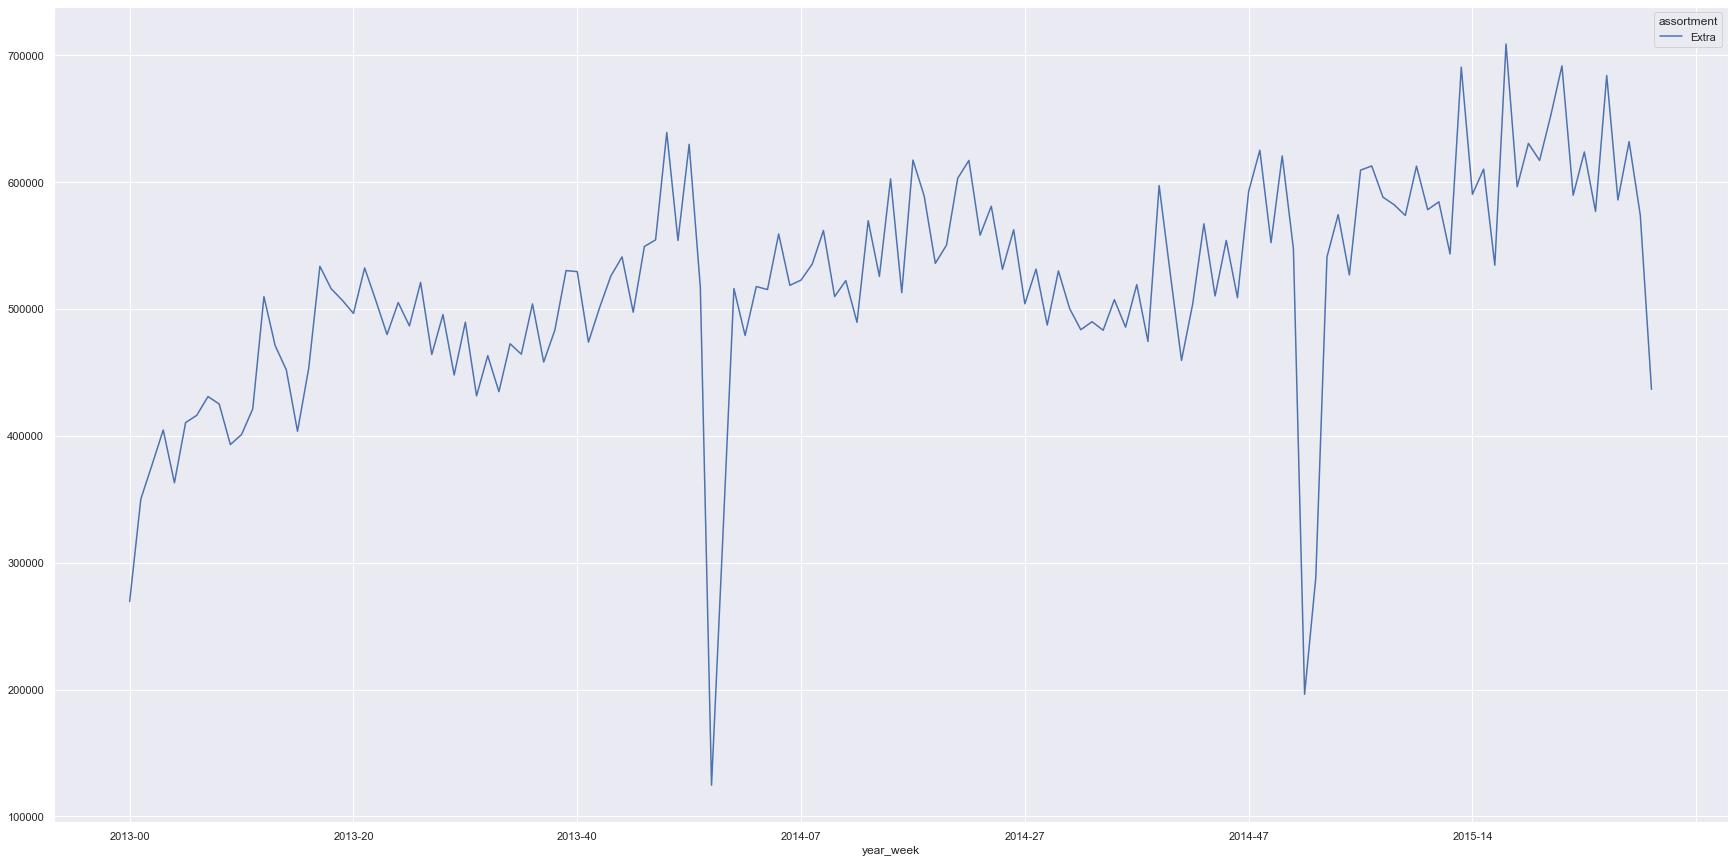

In [65]:
relevant_data.plot(figsize = (30,15))
plt.show()

Conclusão:
Hipótese 1 é **Falsa**, Lojas com **maior sortimento** vendem **menos**.

##### **H2.** Lojas com competidores mais próximos deveriam vender menos.

Vamos visualizar o gráfico de dispersão de vendas por distância de competidores:

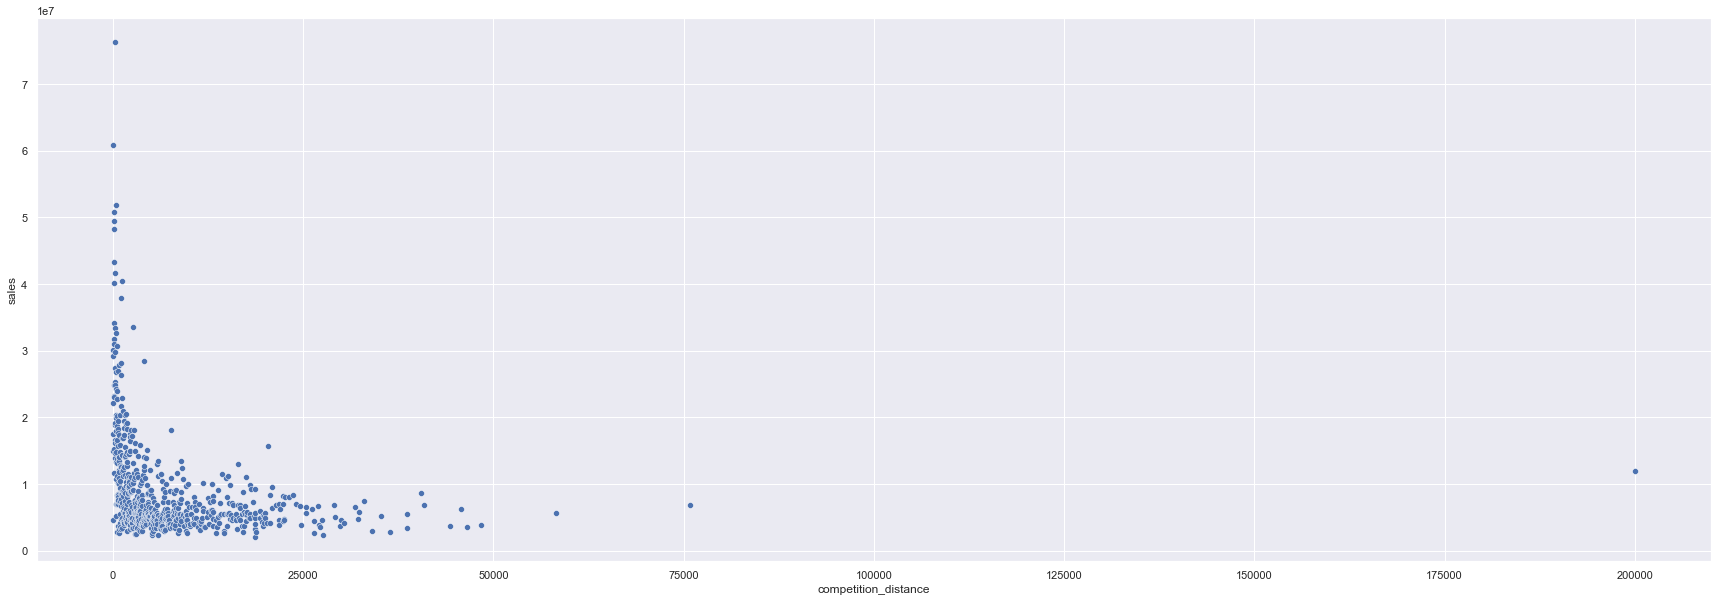

In [66]:
relevant_data = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
fig = plt.figure(figsize = (30,10))
sns.scatterplot(x ='competition_distance', y='sales', data=relevant_data)
plt.show()

- Temos muito mais vendas em lojas com competidores mais próximos
- Quanto mais longe dos competidores, menos vendas são vistas

Vamos ver um gráfico de barras agrupando as lojas por distância de competidores
- Vamos agrupar as distâncias de competidores em 20 grupos, cada grupo cobre 10 km (10000 metros)

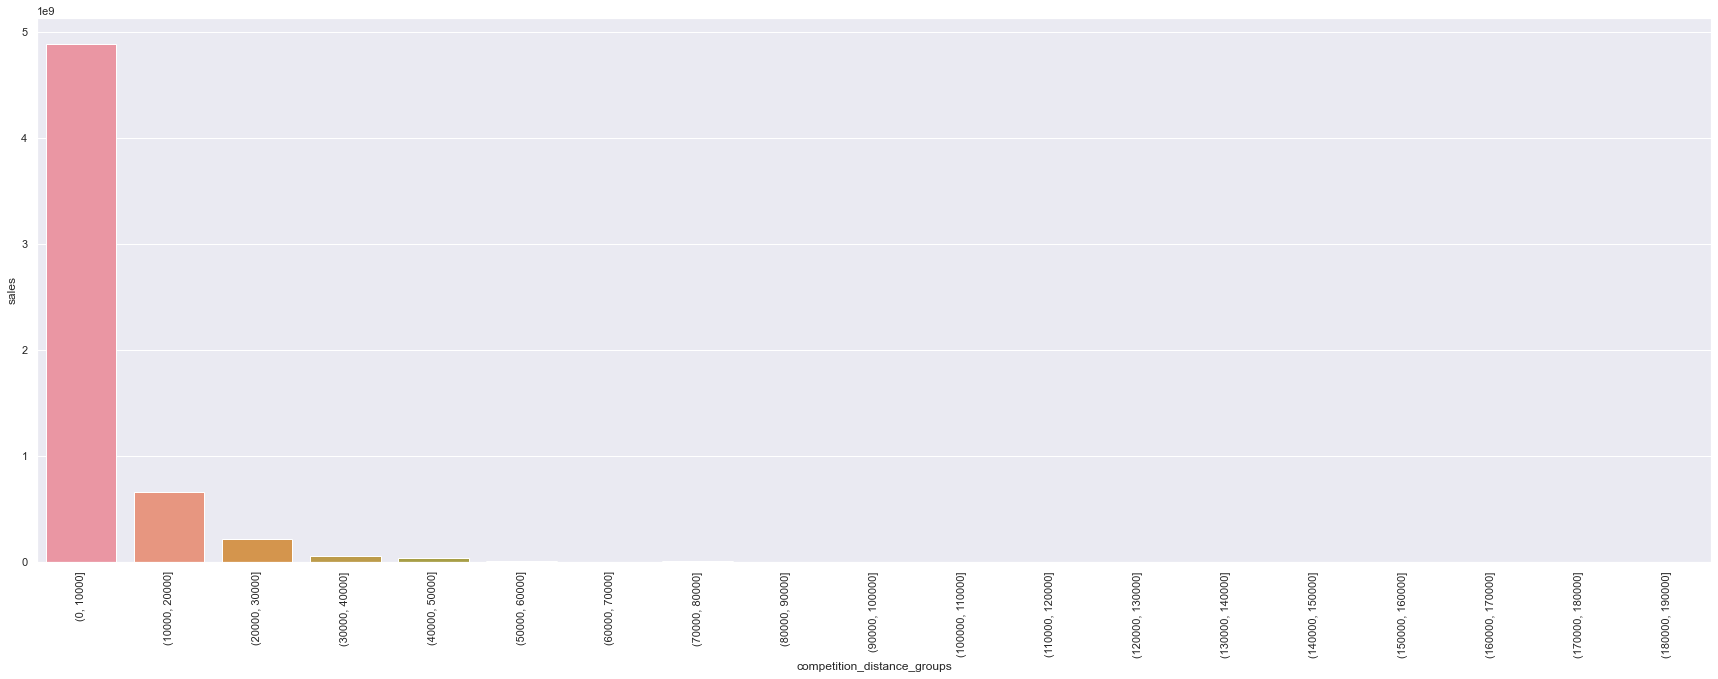

In [67]:
fig = plt.figure(figsize = (30,10))

bins = list(np.arange(0, 200000, 10000))

relevant_data['competition_distance_groups'] = pd.cut(relevant_data['competition_distance'], bins=bins)
relevant_data = relevant_data[['competition_distance_groups', 'sales']].groupby('competition_distance_groups').sum().reset_index()
sns.barplot(x='competition_distance_groups', y='sales', data=relevant_data)
plt.xticks(rotation=90)
plt.show()

Vamos reduzir o range para melhorar a visualização:

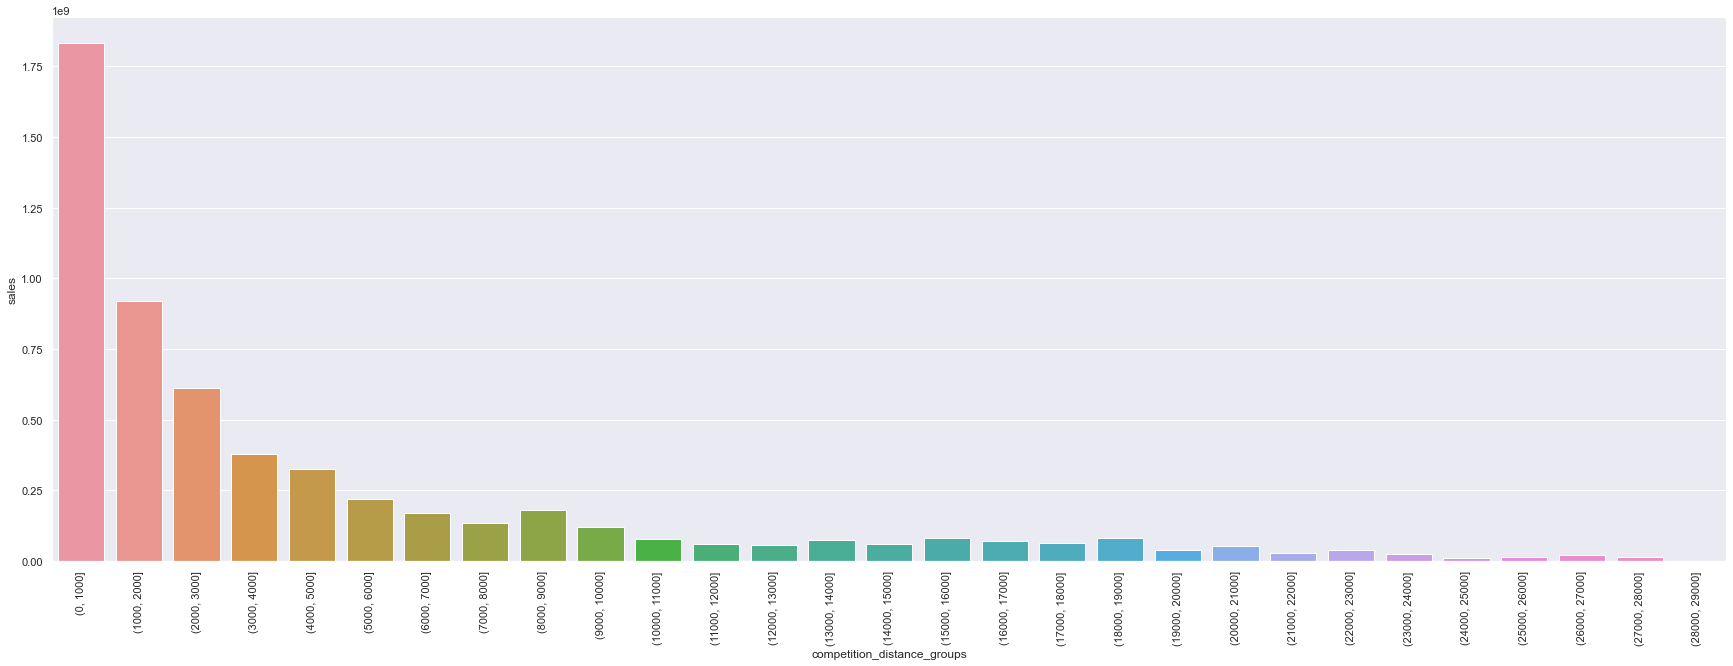

In [68]:
fig = plt.figure(figsize = (30,10))

bins = list(np.arange(0, 30000, 1000))
relevant_data = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
relevant_data['competition_distance_groups'] = pd.cut(relevant_data['competition_distance'], bins=bins)
relevant_data = relevant_data[['competition_distance_groups', 'sales']].groupby('competition_distance_groups').sum().reset_index()
sns.barplot(x='competition_distance_groups', y='sales', data=relevant_data)
plt.xticks(rotation=90)
plt.show()

- Esse gráfico confirma o primeiro de dispersão, quanto mais competidores próximos mais vendas acontecem

Vamos ver um gráfico de correlação entre as variáveis vendas e distância de competidores, que parecem ser inversamente proporcionais:

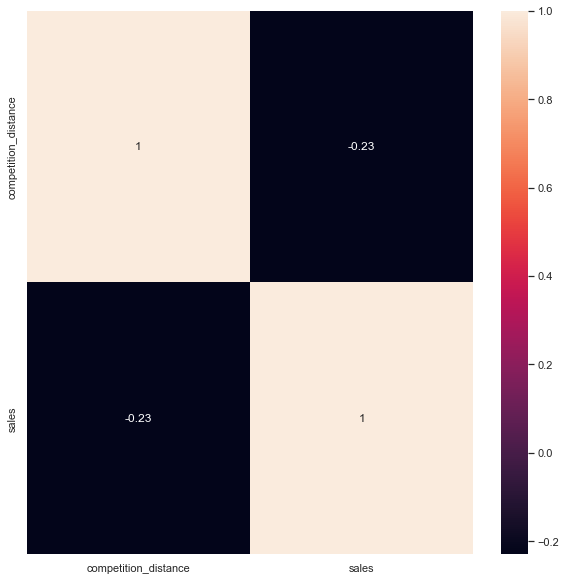

In [69]:
fig = plt.figure(figsize = (10,10))
relevant_data = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.heatmap(relevant_data.corr(method='pearson'), annot=True)
plt.show()

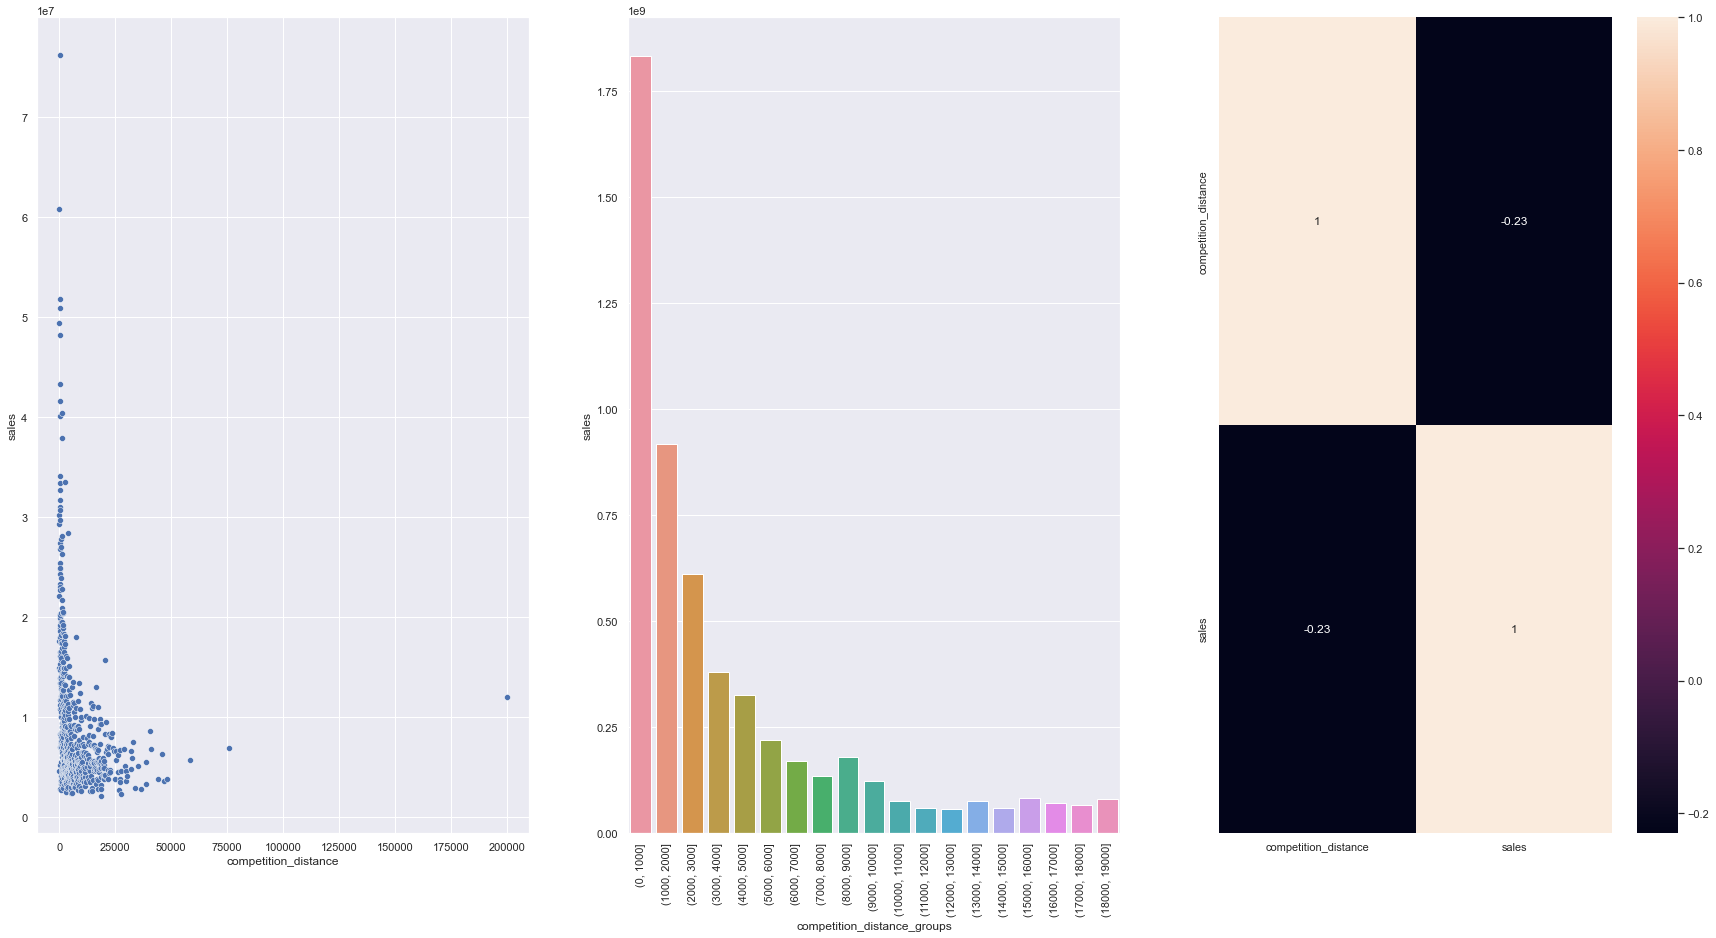

In [70]:
fig = plt.figure(figsize = (30,15))

relevant_data = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='competition_distance', y='sales', data=relevant_data)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
relevant_data['competition_distance_groups'] = pd.cut(relevant_data['competition_distance'], bins=bins)
relevant_data = relevant_data[['competition_distance_groups', 'sales']].groupby('competition_distance_groups').sum().reset_index()
sns.barplot(x='competition_distance_groups', y='sales', data=relevant_data)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
relevant_data = df2[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(relevant_data.corr(method='pearson'), annot=True)

plt.show()

Conclusão:
Com correlação negativa, a Hipótese 2 é **Falsa**, Lojas com **competidores mais próximos** vendem **mais**.

##### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

Vamos ver os três gráficos juntos para tirar conclusões:

- Vamos ver um barplot de vendas por meses de competição, nos últimos 10 anos (120 meses)
    - Se colocarmos todos os dados, vai ficar difícil de visualizar algum padrão
- Vamos fazer um plot de regressão polinomial para ver a tendência das vendas conforme os meses passam
- Por último vamos ver a correlação entre as variáveis vendas e tempo de competição

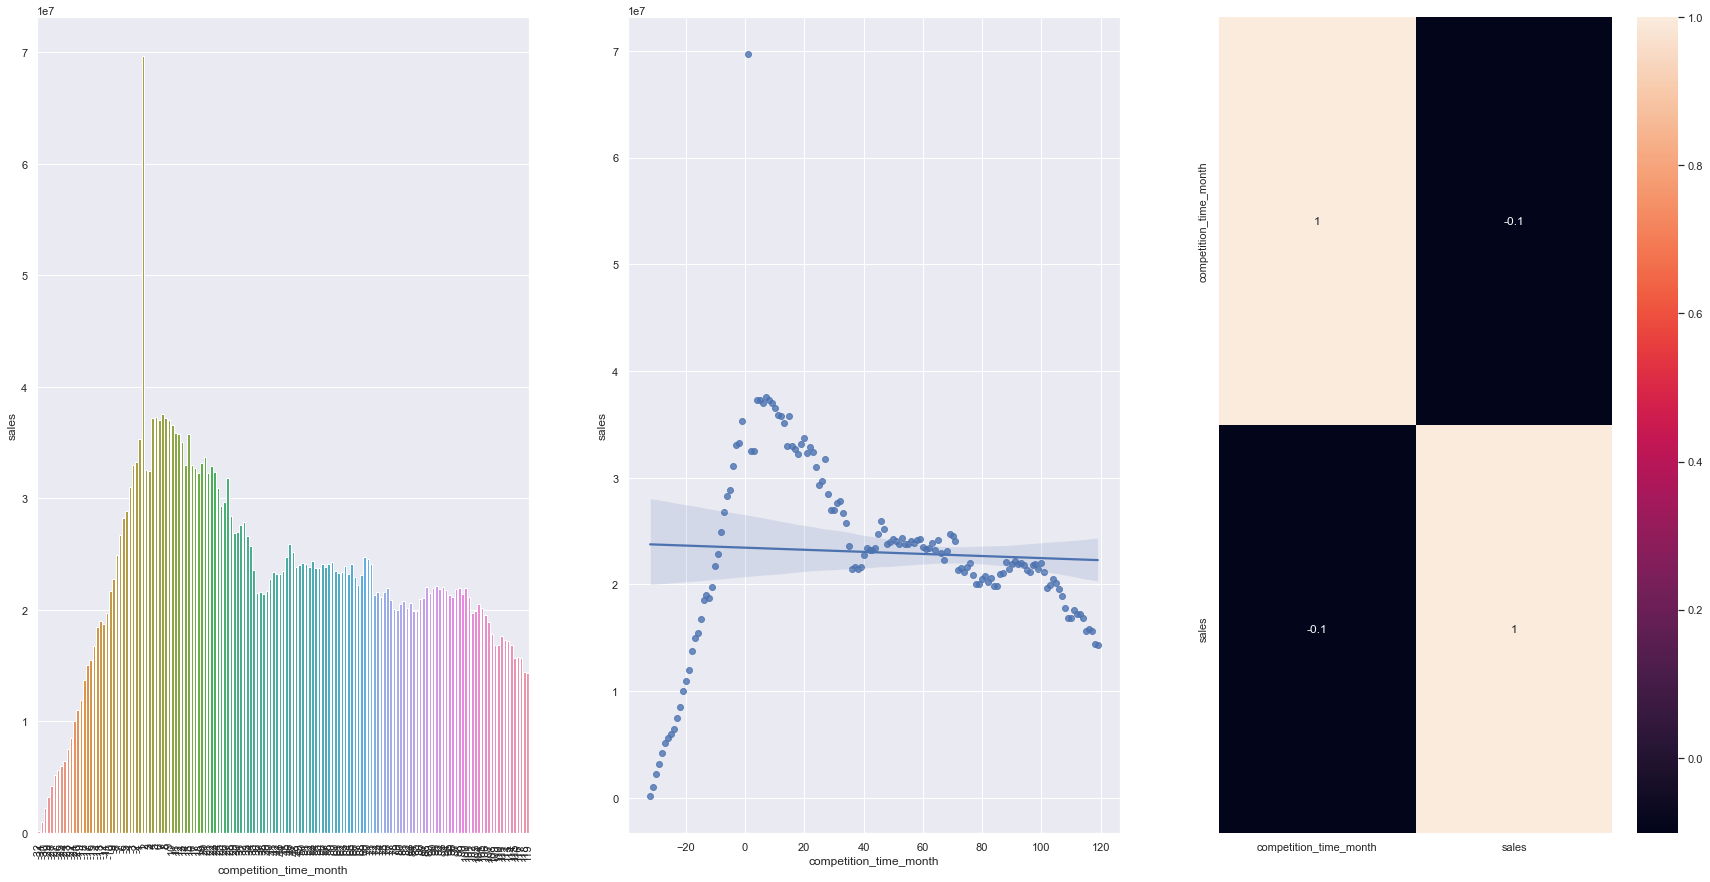

In [71]:
fig = plt.figure(figsize = (30,15))

plt.subplot(1, 3, 1)
relevant_data = df2[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
relevant_data = relevant_data[(relevant_data['competition_time_month'] < 120) & (relevant_data['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=relevant_data)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=relevant_data)

plt.subplot(1, 3, 3)
relevant_data = df2[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
sns.heatmap(relevant_data.corr(method='pearson'), annot=True)

plt.show()

- Pelos dois primeiros gráficos, temos uma tendência de que as lojas com **mais competidores recentes** vendem mais

Conclusão:

Hipótese 3 é **Falsa**, Lojas com **competidores à mais tempo** vendem **menos** no cenário geral, apesar de venderem mais quando a competição é recente, ela logo se estabiliza e cai

##### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

Vamos ver os três gráficos juntos para tirar conclusões em duas situações diferentes:
- Com promoção normal
- Com promoção estendida

In [72]:
relevant_data = df2[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
relevant_data.sample(5)

promo_time_week    sales
269              143  8061257
385              259  3438257
382              256  4595784
263              137  8129825
4               -122   116593

Essa coluna nos dá o tempo em semanas que a promoção está ativa com relação a data de registro no dataset, mas tem uma pegadinha:
- Se a promoção foi estendida, significa que a data que o registro foi feito é superior a data de início da promoção
- Se a promoção não está sendo estendida, significa que a data que o registro foi feito é inferior a data de início da promoção, ou seja, a promoção normal ainda iria acontecer no futuro da data registrada. Isso resulta em valor negativo

Em resumo:
- Se a coluna 'promo_time_week' tiver resultado positivo, significa que a promoção já estava ativada numa data no passado, então podemos ter alguma certeza de que é estendida
    - Isso pode ser falso se a data for positiva mas muito próxima da data de registro (ex: números perto de 1 ou 2 semanas positivas) pode indicar que uma promoção normal começou há algumas semanas atrás
        - Como não temos o acesso real a esses detalhes, resta especulação com base no que temos


- Se a coluna 'promo_time_week' tiver resultado negativo, significa que a promoção ainda vai acontecer no futuro, então podemos ter certeza de que vai ser uma promoção normal
- Se a coluna 'promo_time_week' tiver resultado zero, significa que uma promoção normal foi ativada no mesmo dia do registro (o que pode ser raro, visto que esses relatórios saem sempre no fechamento de cada mês, até lá a data do começo da promoção já passou)

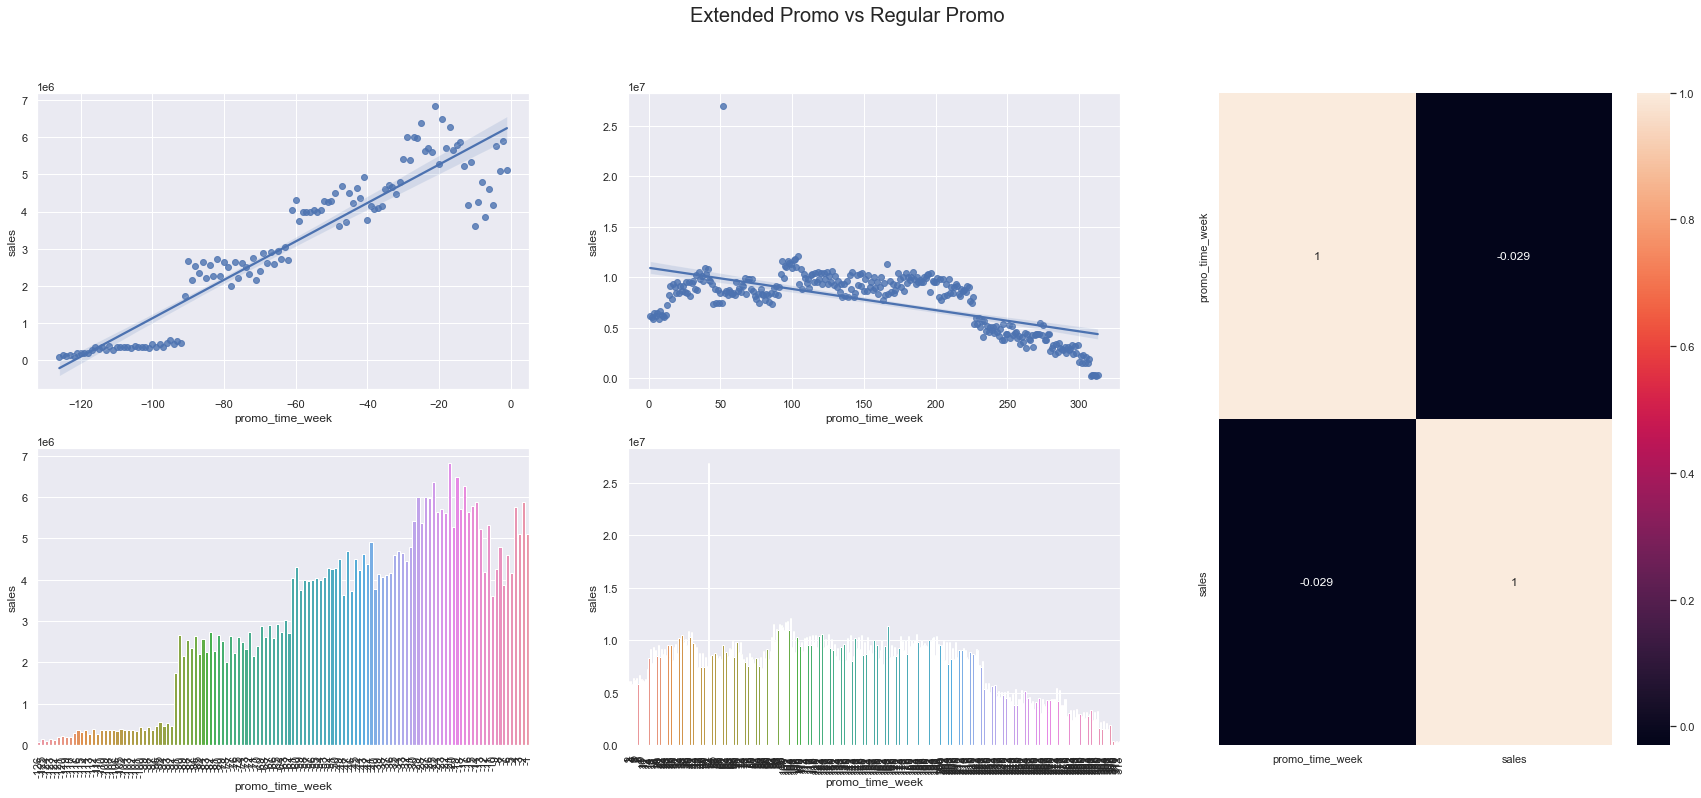

In [73]:
relevant_data = df2[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
fig = plt.figure(figsize = (30,12))
grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
relevant_data1 = relevant_data[relevant_data['promo_time_week'] < 0]
sns.regplot(x='promo_time_week', y='sales', data=relevant_data1)

plt.subplot(grid[0,1])
relevant_data2 = relevant_data[relevant_data['promo_time_week'] > 0]
sns.regplot(x='promo_time_week', y='sales', data=relevant_data2)

plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=relevant_data1)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])

sns.barplot(x='promo_time_week', y='sales', data=relevant_data2)
plt.xticks(rotation=90)

plt.subplot(grid[:,2])
sns.heatmap(relevant_data.corr(method='pearson'), annot=True)
fig.suptitle('Regular Promo vs Extended Promo ', fontsize=20)
plt.show()

Conclusão:

Hipótese 4 é **Falsa**, Lojas com **promoções ativas por mais tempo** vendem **menos**, depois de um tempo as vendas caem no cenário geral, apesar de subirem de início

##### **H5.** Lojas com mais dias de promoção deveriam vender mais.

Conclusão:

Hipótese 5 é **Falsa**, Lojas com **promoções ativas por mais tempo**, ou seja, **com mais dias de promoção** vendem **menos** de acordo com a fonrimação da hipótese anterior

##### **H6.** Lojas com mais promoções seguidas deveriam vender mais.


Vamos ver uma tabela agrupada dos tipos de promoções e vendas:

In [74]:
df2[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=True).head(10)

promo  promo2       sales
1      0       1  1289362241
3      1       1  1472275754
0      0       0  1482612096
2      1       0  1628930532

Mas fica difícil plotar um gráfico com 3 variáveis, especialmente se for uma série temporal (como estamos tratando de anos e datas), então vamos separar essa tabela maior em duas, usando ano como índice X e as vendas como índice Y, mas cada série vai ter os números de vendas de um tipo de promoção separada, plotadas no mesmo gráfico

Vamos deixar apenas o valor das vendas por ano, filtrando para incluir as vendas das duas promoções:

In [75]:
df2[(df2['promo'] == 1) & (df2['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index().head()

year_week     sales
0   2013-01  20995409
1   2013-03  19481514
2   2013-05  20580811
3   2013-07  20273185
4   2013-09  21451952

Agora, vamos deixar apenas o valor das vendas por ano, filtrando para incluir apenas as vendas da promoção estendida:

In [76]:
df2[(df2['promo'] == 1) & (df2['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index().head()

year_week     sales
0   2013-01  22118270
1   2013-03  20567037
2   2013-05  22087889
3   2013-07  21631750
4   2013-09  22727171

Vamos ver um gráfico a partir dessas tabelas, que mostra a quantidade de vendas por tipo de promoção:
- Primeiro por promoção normal e estendida
- Depois apenas pela estendida

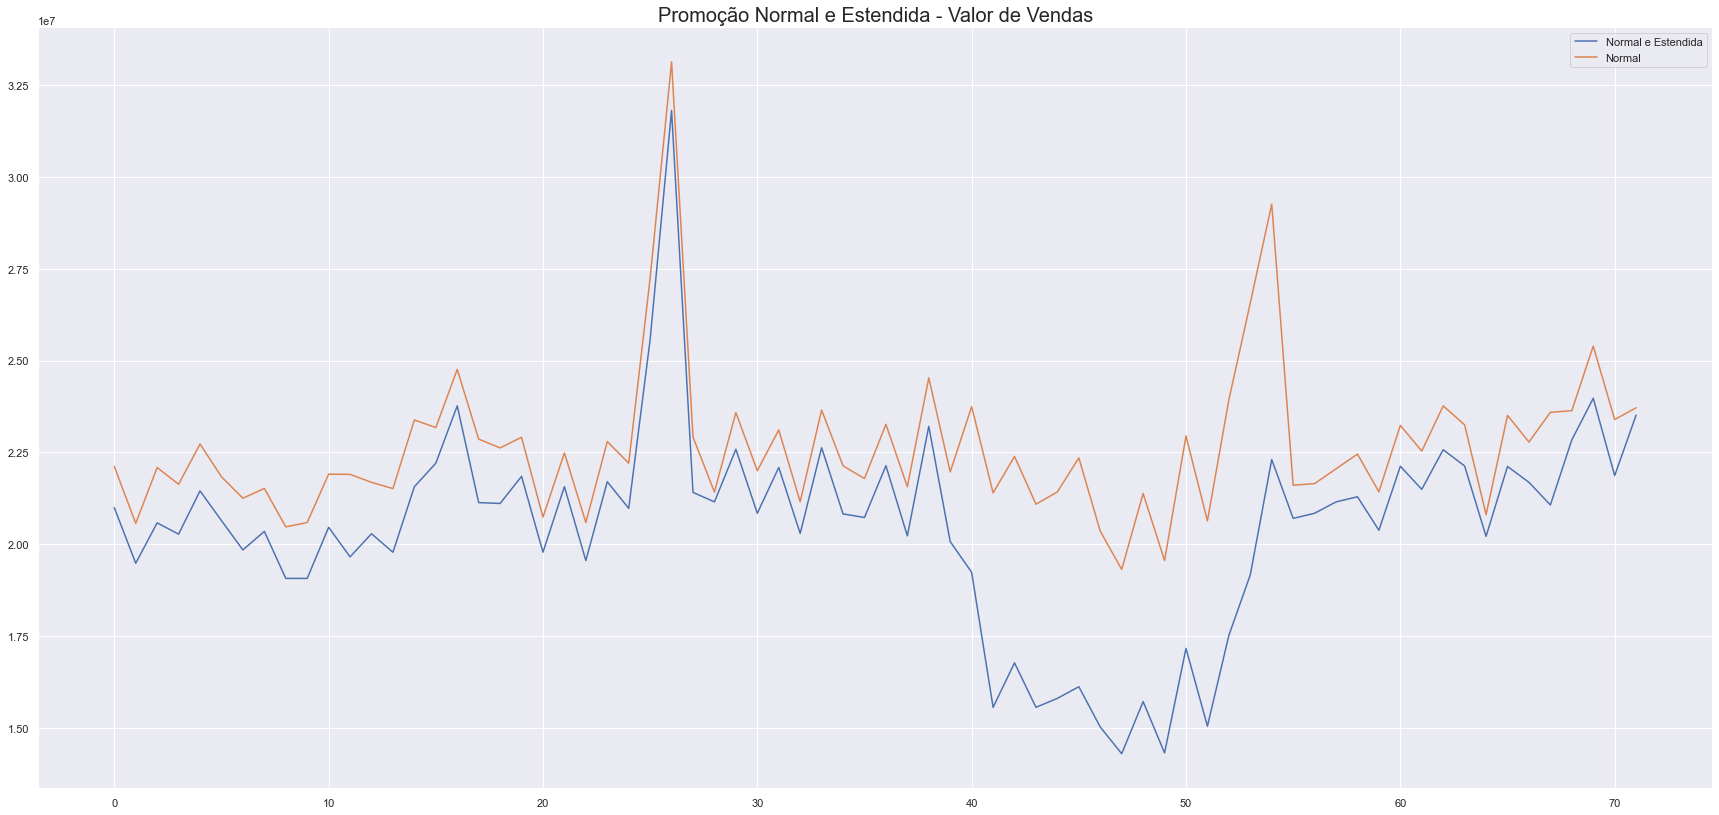

In [77]:
relevant_data = df2[(df2['promo'] == 1) & (df2['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = relevant_data.plot(figsize = (30,14))

relevant_data2 = df2[(df2['promo'] == 1) & (df2['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
relevant_data2.plot(ax=ax)

ax.legend(labels=['Normal e Estendida', 'Normal'])
ax.set_title('Promoção Normal e Estendida - Valor de Vendas', fontsize=20)
plt.show()

In [78]:
#falta correlação de promo e promo2 com vendas

- Pelo gráfico vemos que com promoções estendidas há uma grande queda nas vendas depois de algum tempo
- Além disso, sempre que há promoções estendidas as lojas com estas vendem menos que as lojas com promoções normais

Conclusão:

Hipótese 6 é **Falsa**, Lojas com **mais promoções seguidas** vendem **menos**

##### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

Vamos ver uma tabela de vendas por feriados:

In [79]:
df2[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index().head()

state_holiday       sales
0     Christmas      691806
1        Easter     1433744
2        Public     5890305
3   Regular_Day  5865164768

Agora vamos ver um gráfico com o valor das vendas por feriado e por ano:

In [80]:
df2[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

year state_holiday       sales
0   2013     Christmas      331182
1   2013        Easter      454997
2   2013        Public     2052408
3   2013   Regular_Day  2300037497
4   2014     Christmas      360624
5   2014        Easter      463353
6   2014        Public     2084616
7   2014   Regular_Day  2177896303
8   2015        Easter      515394
9   2015        Public     1753281
10  2015   Regular_Day  1387230968

In [81]:
# Drop Method
aux = df2.drop(df2.loc[df2['state_holiday'] == 'Regular_Day'].index)
aux = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux

state_holiday    sales
0     Christmas   691806
1        Easter  1433744
2        Public  5890305

In [82]:
#group_filter = df2[['year','state_holiday', 'sales']].groupby(['year', 'state_holiday']).\
#    apply(lambda x: x[x['state_holiday'] != 'Regular_Day'])
#group_filter.sum().reset_index()
#aux1 = aux[['state_holiday', 'sales']].apply(lambda x: x[x['state_holiday'] != 'Regular_Day']).groupby('state_holiday').sum().reset_index()

# Filter Method

aux = df2[df2['state_holiday'] != 'Regular_Day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

aux1



state_holiday    sales
0     Christmas   691806
1        Easter  1433744
2        Public  5890305

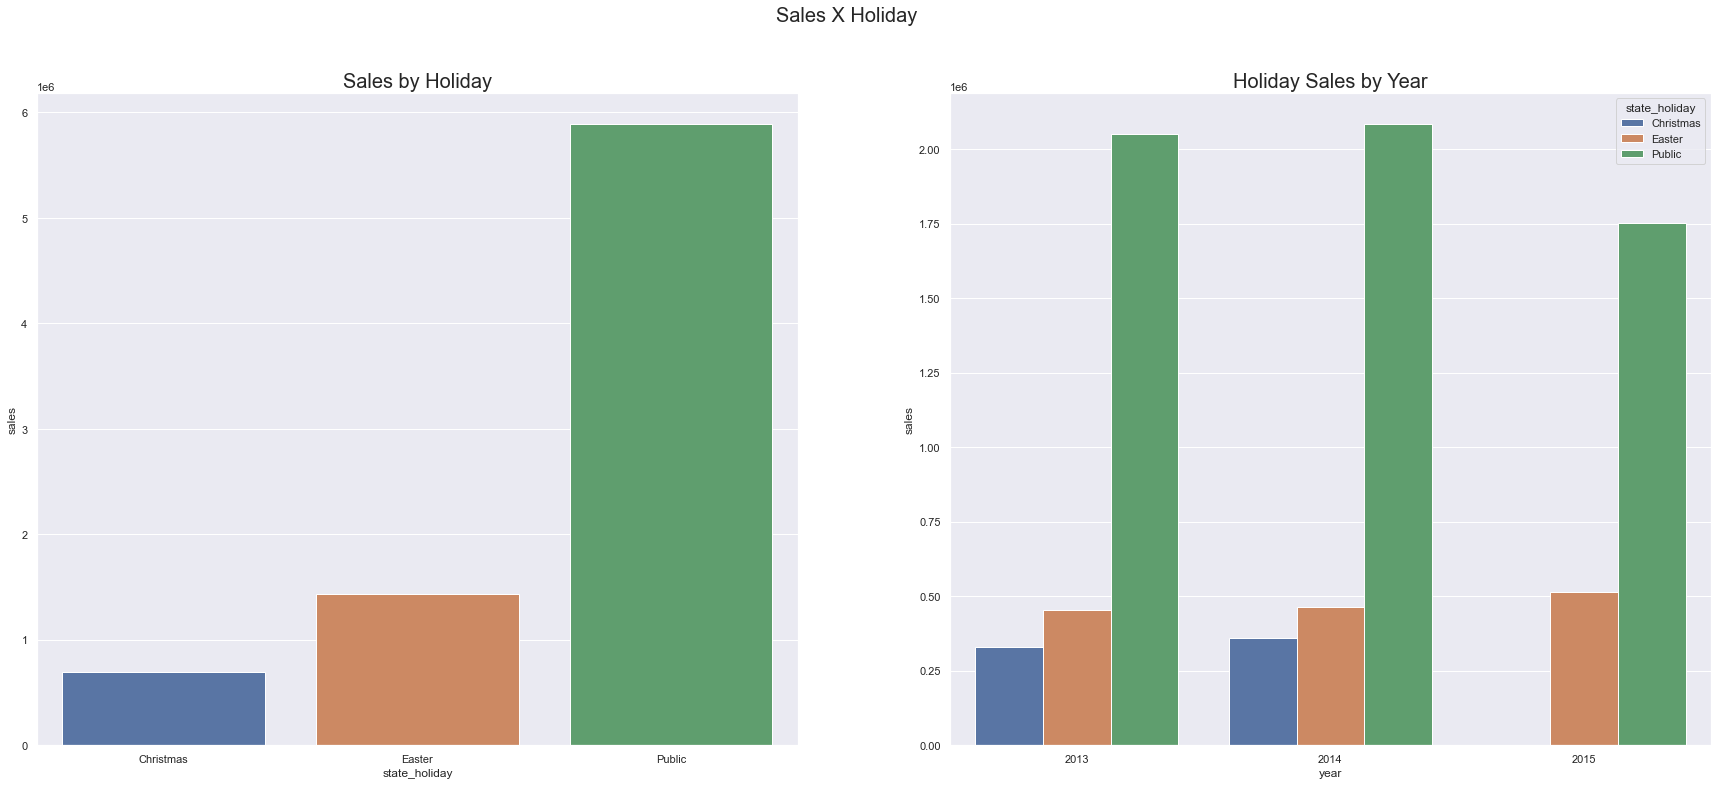

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 12))
#grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.5)
aux = df2[df2['state_holiday'] != 'Regular_Day']

ax[1] = plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

ax[2] = plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

ax[1].title.set_text('Sales by Holiday')
ax[2].title.set_text('Holiday Sales by Year')
ax[1].title.set_fontsize(20)
ax[2].title.set_fontsize(20)
fig.suptitle('Sales X Holiday', fontsize=20)
plt.show()


Conclusão:

Hipótese 7 é **Falsa**, Lojas abertas durante o **feriado do Natal** vendem **menos**. Os Feriados que mais vendem são os públicos, por serem em muito maior número ao longo do ano.

##### **H8.** Lojas deveriam vender mais ao longo dos anos.

vamos ver uma tabela de vendas por ano:

In [84]:
df2[['year', 'sales']].groupby('year').sum().reset_index().head()

year       sales
0  2013  2302876084
1  2014  2180804896
2  2015  1389499643

Agora vamos ver os gráficos de vendas por ano:
    - De barras
    - De tendência
    - De correlação

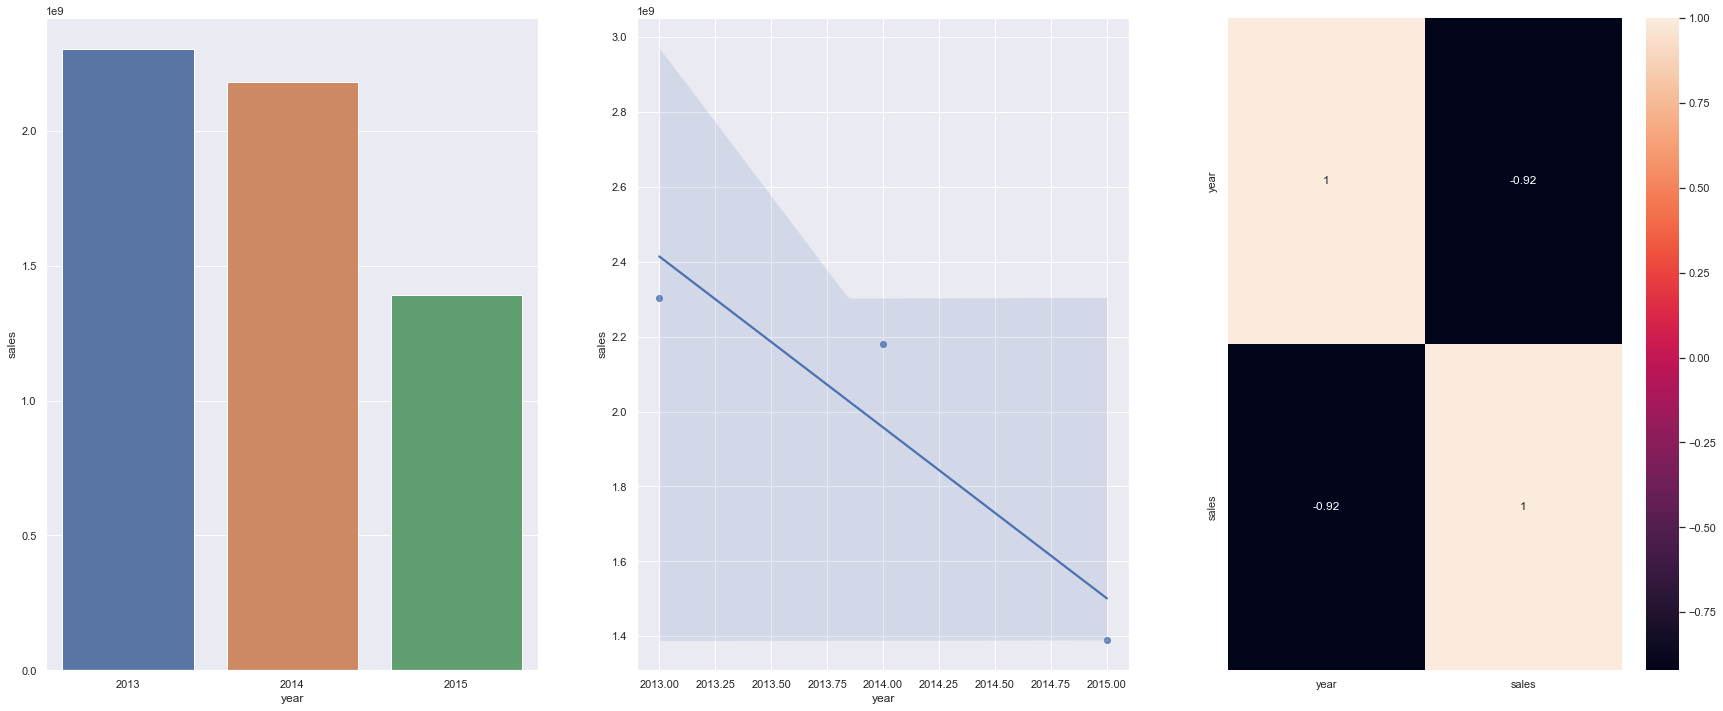

In [85]:
aux1 = df2[['year', 'sales']].groupby('year').sum().reset_index()
fig = plt.figure(figsize = (30,12))

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.show()

Conclusão:

Hipótese 8 é **Falsa**, Lojas **vendem menos** **ao longo dos anos**, e a tendência é claramente decrescente para o futuro

##### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

Vamos ver uma tabela de vendas por mês:

In [86]:
df2[['month', 'sales']].groupby('month').sum().reset_index()

month      sales
0       1  566728724
1       2  528734410
2       3  599831906
3       4  575895295
4       5  569248217
5       6  578112775
6       7  595059205
7       8  361791202
8       9  342570131
9      10  351878728
10     11  369498877
11     12  433831153

Agora um gráfico mensal de vendas:

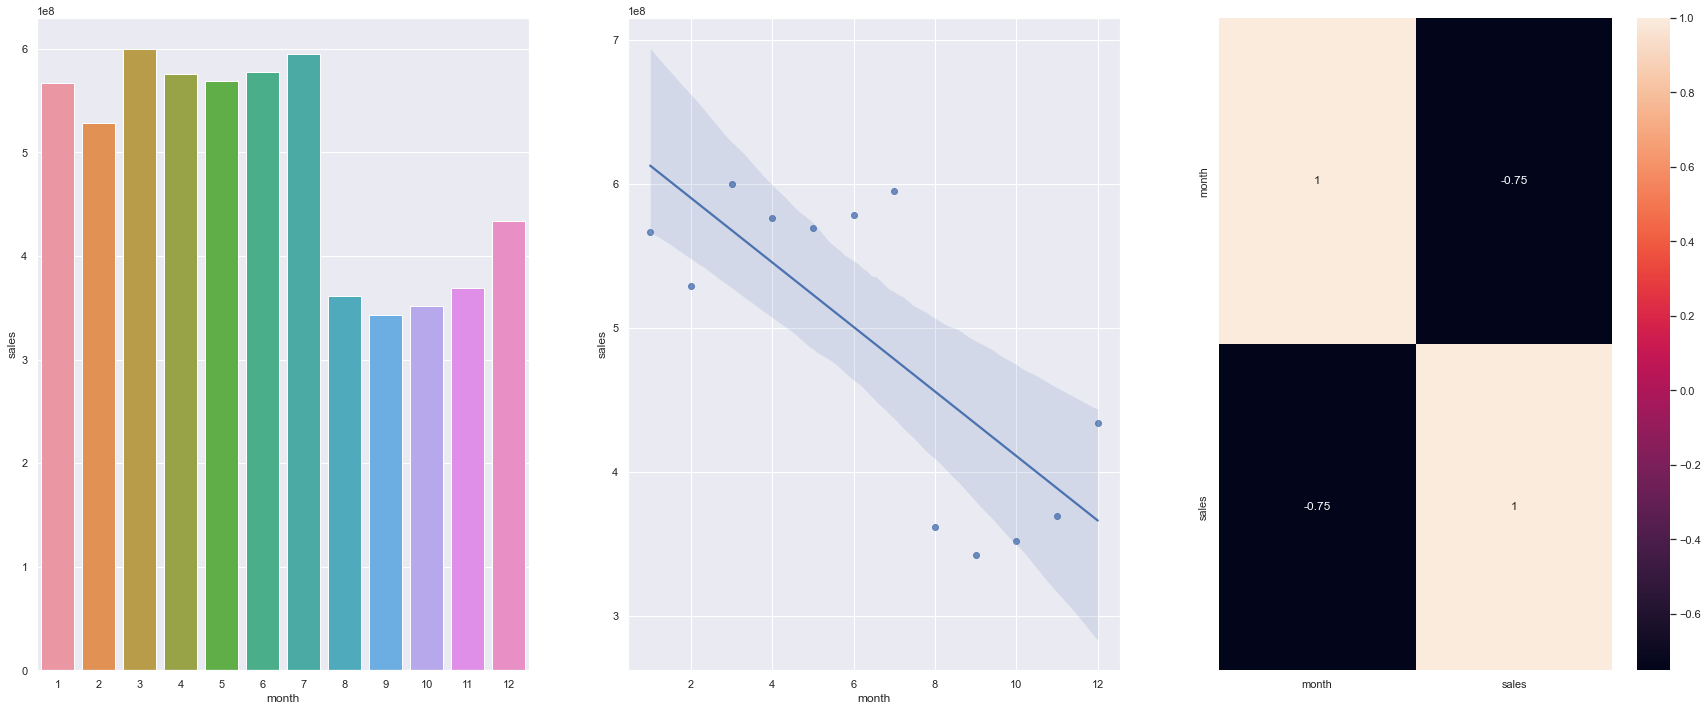

In [87]:
aux1 = df2[['month', 'sales']].groupby('month').sum().reset_index()
fig = plt.figure(figsize = (30,12))

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Conclusão:

Hipótese 9 é **Falsa**, Lojas **vendem menos** no **segundo semestre** do ano, e a tendência é claramente decrescente para o final do ano, aumentando no começo

##### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

Vamos ver uma tabela de vendas por dia:

In [88]:
df2[['day', 'sales']].groupby('day').sum().reset_index().head(15)

day      sales
0     1  155983560
1     2  233513169
2     3  194582812
3     4  228301010
4     5  212869176
5     6  197094539
6     7  201380487
7     8  189718770
8     9  175922427
9    10  181039363
10   11  183373089
11   12  174242021
12   13  192254717
13   14  180183130
14   15  195262955

Agora vamos criar uma nova coluna chamada 'before_after' para separar antes e depois do dia 10:

In [89]:
aux1['before_after'] = df2['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index().head()

before_after       sales
0  after_10_days  5873180623

Já conseguimos ver que pela soma geral, depois de 10 dias as vendas sobem. Isso deve se confirmar nos gráficos:

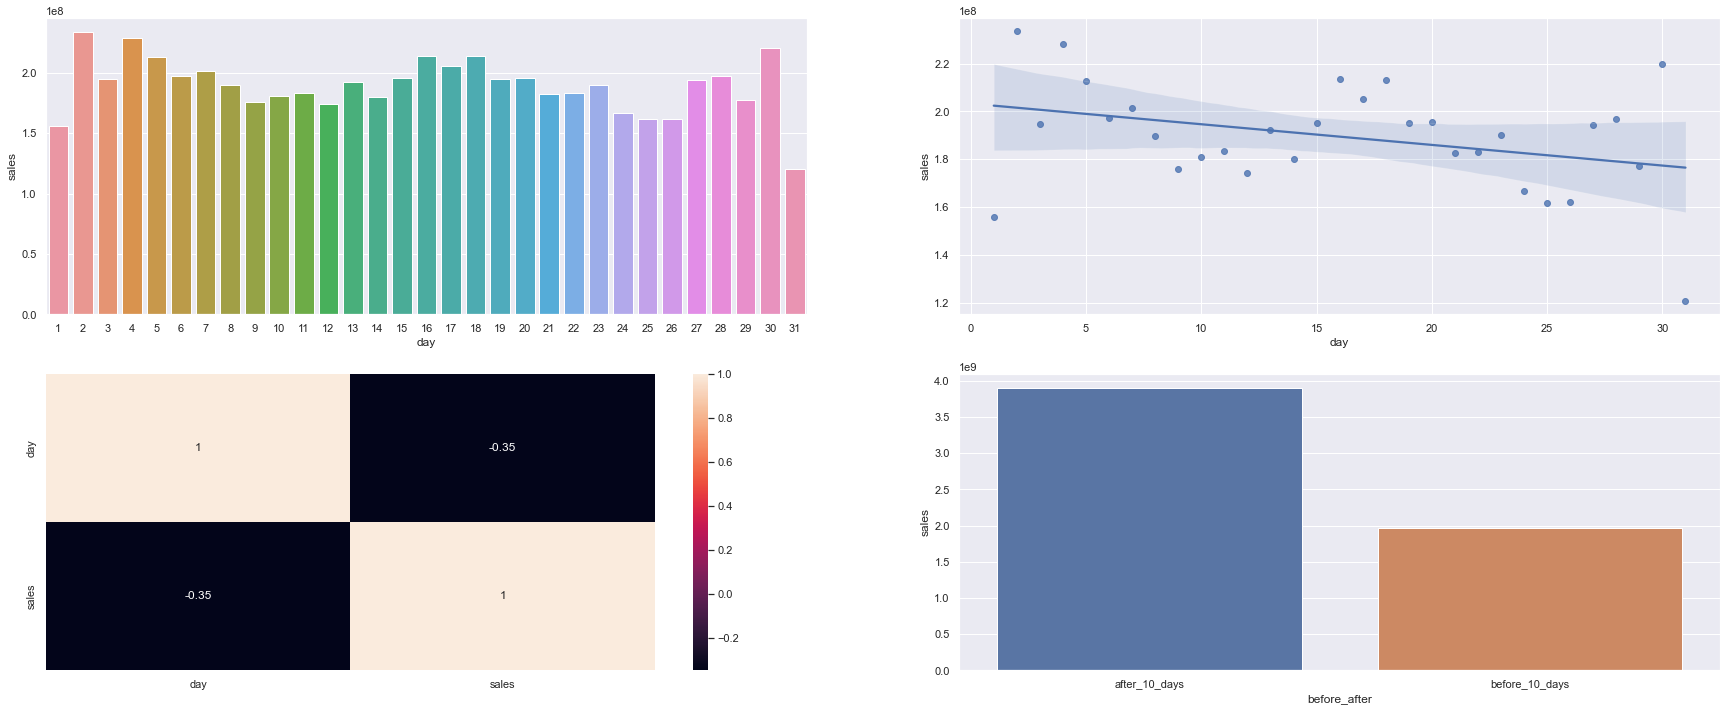

In [90]:
aux1 = df2[['day', 'sales']].groupby('day').sum().reset_index()
fig = plt.figure(figsize = (30,12))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 =aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.show()

Conclusão:

Hipótese 10 é **Verdadeira**, Lojas **vendem mais** depois do **dia 10** de cada mês, mas depois do dia 18 acontece uma queda sensível nas vendas.

##### **H11.** Lojas deveriam vender menos aos finais de semana.

Vamos ver uma tabela de vendas por dia da semana:

In [91]:
df2[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

day_of_week       sales
0            1  1130203012
1            2  1020411930
2            3   954962863
3            4   911177709
4            5   980555941
5            6   846317735
6            7    29551433

Já pela tabela é notável uma grande queda aos domingos, isso deve se refletir nos gráficos:

- De barras
- De tendência
- De correlação

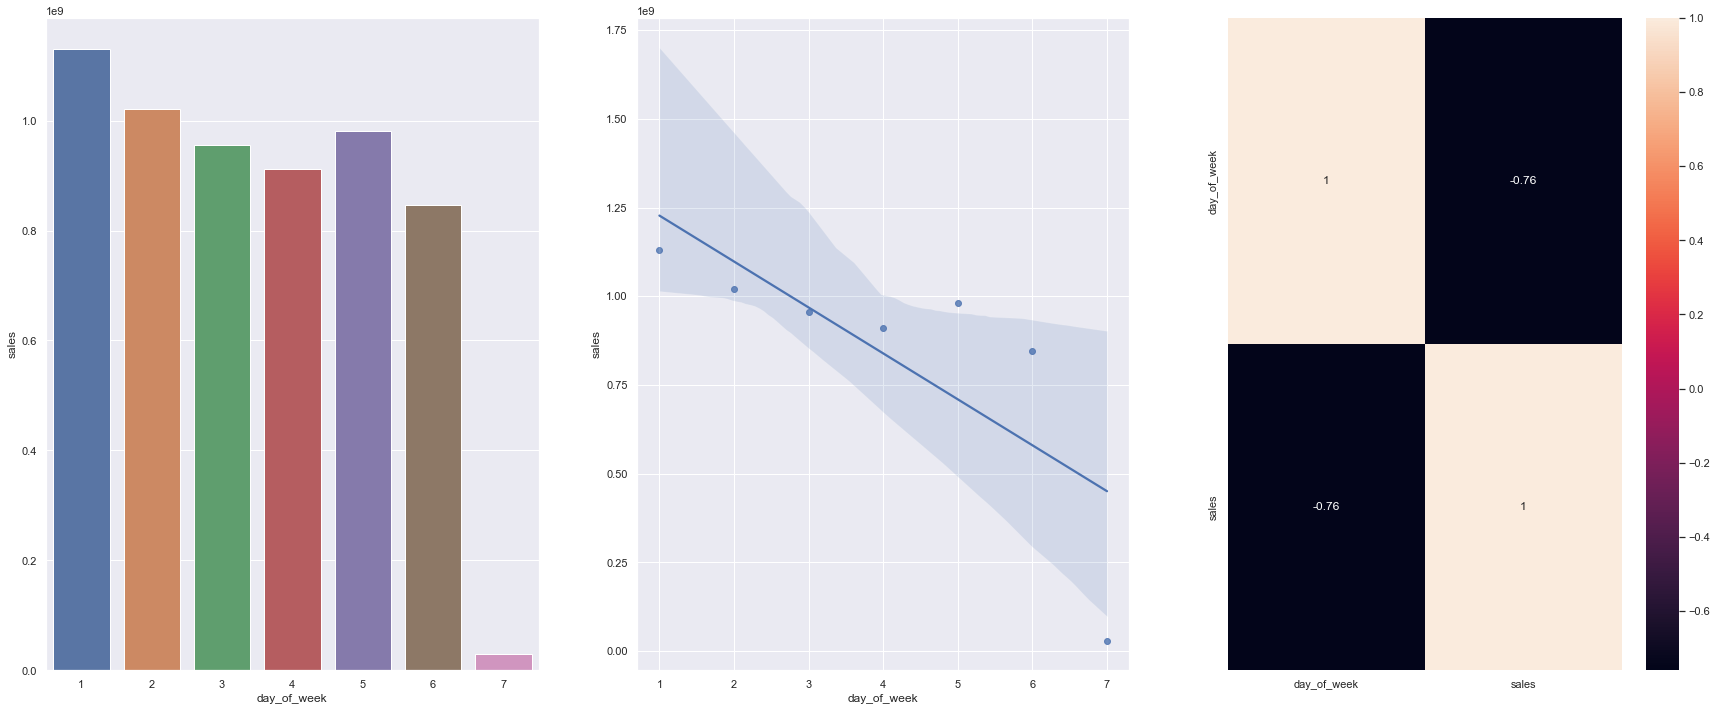

In [92]:
aux1 = df2[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
fig = plt.figure(figsize = (30,12))

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Conclusão:

Hipótese 11 é **VERDADEIRA** Lojas vendem menos aos finais de semana, principalmente no domingo. Pode ser reflexo do setor/tipo de produtos o qual a rede trabalha. A correlação negativa é bem forte, acima dos 70%.

##### **H12.** Lojas deveriam vender menos durante os feriados escolares.

Vamos ver uma tabela de vendas por feriados escolares:

In [93]:
df2[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

school_holiday       sales
0               0  4696260531
1               1  1176920092

Essa tabela nos diz que quando não temos feriados escolares, as vendas são mais altas. Mas isso se explica facilmente pois todos os outros feriados do ano são muito maiores em soma total que os feriados escolares.

Vamos ver um gráfico de vendas por feriados escolares para clarear melhor a visão sobre essa hipótese:

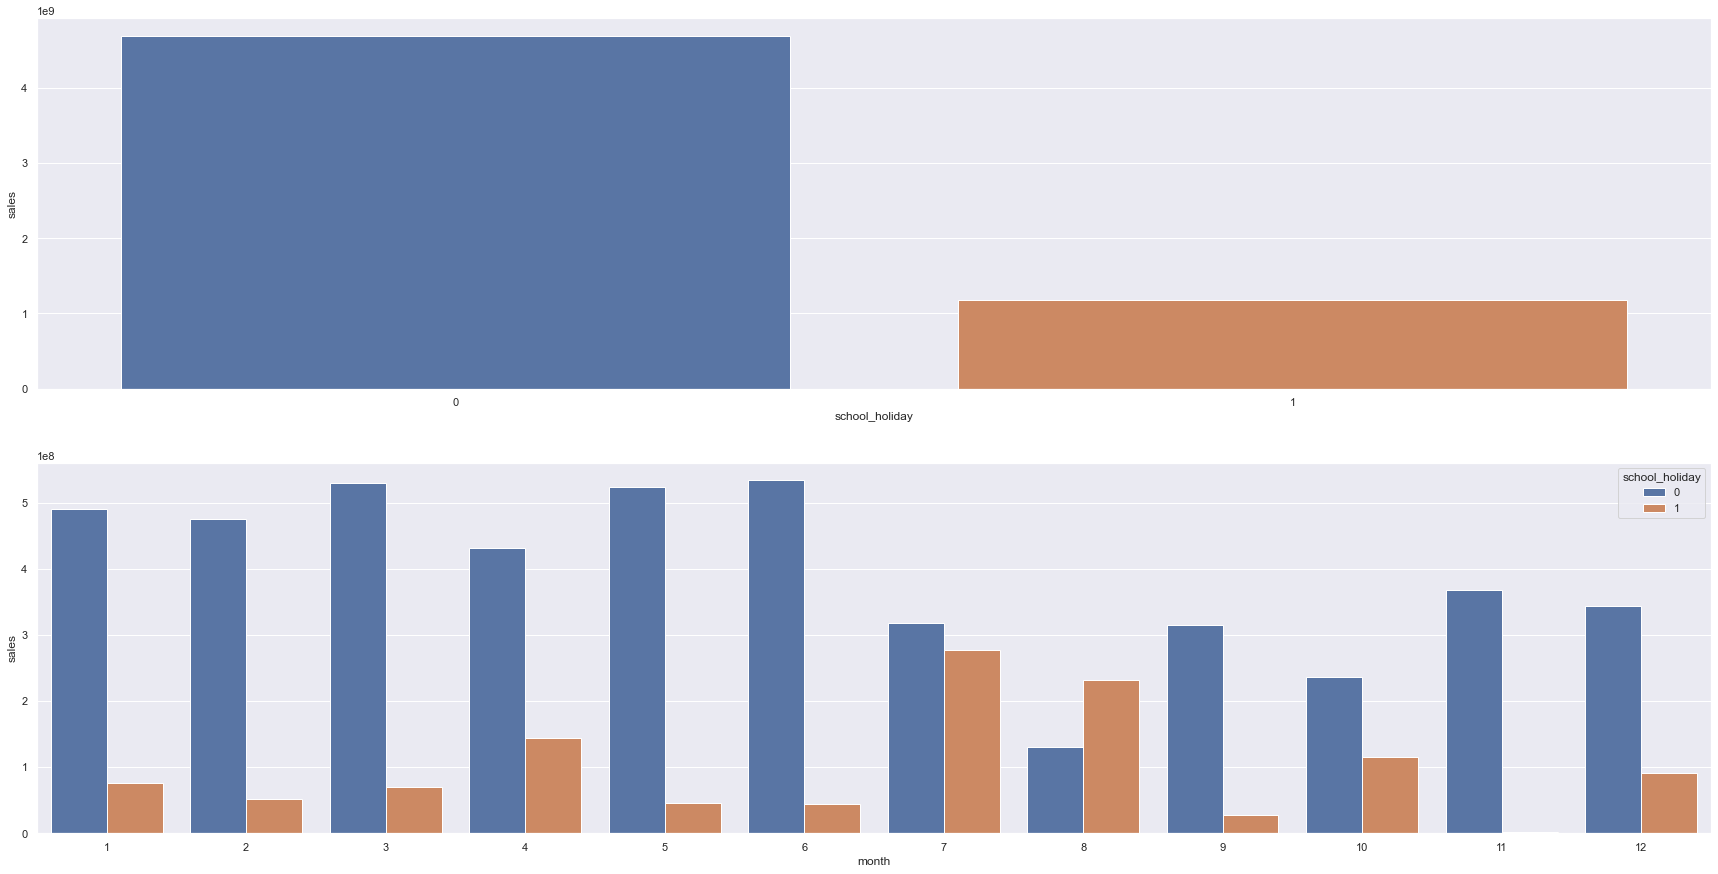

In [94]:
aux1 = df2[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
fig = plt.figure(figsize = (30,15))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df2[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.show() 

In [95]:
#falta correlação de school_holiday com sales

Conclusão:

Hipótese 12 é **Verdadeira**, Lojas **vendem menos** durante os **feriados escolares**, exceto os meses de Julho e Agosto onde vemos um salto forte de vendas nesses feriados.

#### Hypotheses Validation

In [96]:
conclusions =  [['H1', 'Falsa', 'Baixa', 'Sim'],  
                ['H2', 'Falsa', 'Média', 'Sim'],  
                ['H3', 'Falsa', 'Média', 'Sim'],
                ['H4', 'Falsa', 'Baixa', 'Sim'],
                ['H5', 'Falsa', 'Baixa', 'Não'],
                ['H6', 'Falsa', 'Baixa', 'Sim'],
                ['H7', 'Falsa', 'Média', 'Não'],
                ['H8', 'Falsa', 'Alta', 'Não'],
                ['H9', 'Falsa', 'Alta', 'Não'],
                ['H10', 'Verdadeira', 'Média', 'Não'],
                ['H11', 'Verdadeira', 'Alta', 'Não'],
                ['H12', 'Verdadeira', 'Média', 'Possível'] ]
print(tabulate(conclusions, headers='firstrow'))

H1    Falsa       Baixa    Sim
----  ----------  -------  --------
H2    Falsa       Média    Sim
H3    Falsa       Média    Sim
H4    Falsa       Baixa    Sim
H5    Falsa       Baixa    Não
H6    Falsa       Baixa    Sim
H7    Falsa       Média    Não
H8    Falsa       Alta     Não
H9    Falsa       Alta     Não
H10   Verdadeira  Média    Não
H11   Verdadeira  Alta     Não
H12   Verdadeira  Média    Possível


In [97]:
def get_analysis_conclusions(matrix, columns = None, columns_included = None):
    if columns:
        columns = columns
    else:
        columns = ['Hipóteses', 'Conclusão', 'Relevância', 'Insigth']
        
    def highlight_relevance(value):
        positive = ['Alta', 'Verdadeira', 'Sim']
        negative = ['Baixa', 'Falsa', 'Não']
        mid = ['Média', 'Possível']
        if value in positive:
            color = 'green'
            return f'color:{color}'
        elif value in negative:
            color = 'red'
            return f'color:{color}'
        elif value in mid:
            color = 'orange'
            return f'color:{color}'
        
    if columns_included:
        analysis = pd.DataFrame.from_records(matrix[1:],columns=matrix[0])
        
    else:
        analysis = pd.DataFrame(conclusions,columns=columns)
    
    analysis.reset_index(drop=True, inplace=True)
    analysis.set_index('Hipóteses', inplace = True)
    return analysis.style.applymap(highlight_relevance)


Hypotheses = get_analysis_conclusions(conclusions, columns_included = False)
Hypotheses

#### Multivariate Analysis

##### Numerical Attributes

In [98]:
num_attributes.head()

store  day_of_week  sales  promo  school_holiday  competition_distance  \
0      1            5   5263      1               1                1270.0   
1      2            5   6064      1               1                 570.0   
2      3            5   8314      1               1               14130.0   
3      4            5  13995      1               1                 620.0   
4      5            5   4822      1               1               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  active_promo  year  month  day  \
0                 31               2015             0  2015      7   31   
1                 13               2010             1  2015      7   31   
2                 14               2011             1  2015      7   31   
3                 31               2015             0  2015      7   31   
4                 31               2015             0  2015      7   31   

   week_of_year  
0            31  
1            31  
2            31  
3            31  
4            31

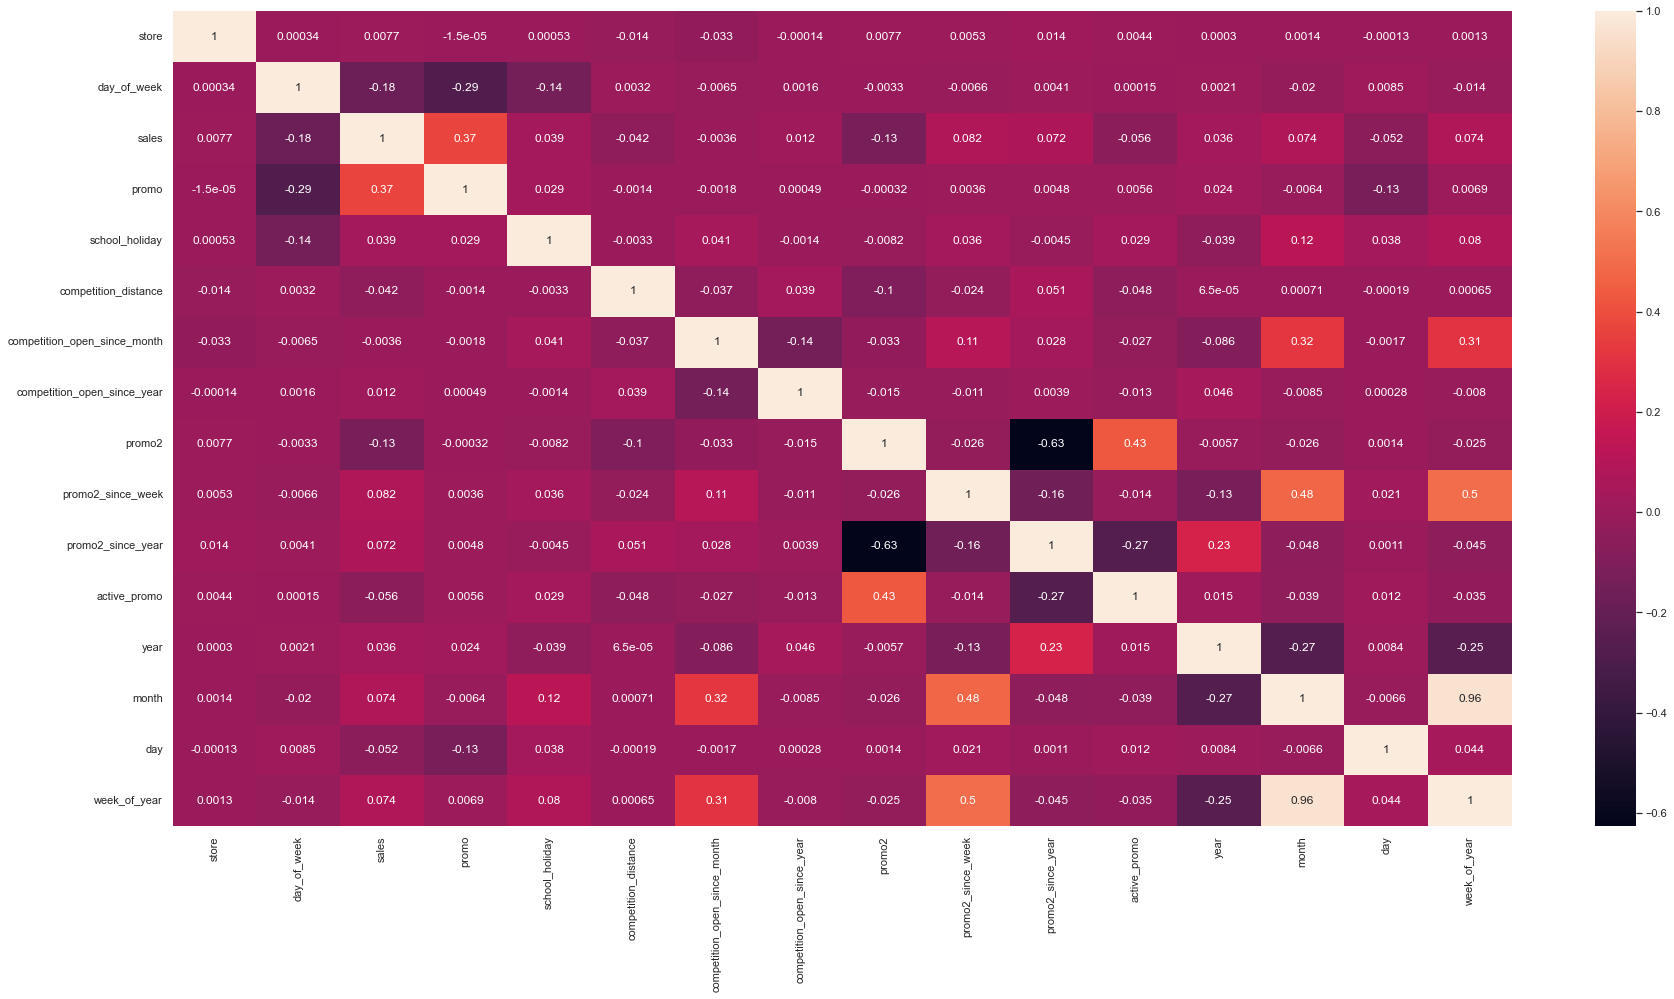

In [99]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.show()

##### Categorical Attributes

In [100]:
cat_attributes.head()

state_holiday store_type assortment year_week
0   Regular_Day          c      Basic   2015-30
1   Regular_Day          a      Basic   2015-30
2   Regular_Day          a      Basic   2015-30
3   Regular_Day          c   Extended   2015-30
4   Regular_Day          a      Basic   2015-30

In [101]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values # Previously, as_matrix was used. but this is deprecated
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = sts.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [102]:
a = df2.select_dtypes(include='object')
a.head()

state_holiday store_type assortment year_week
0   Regular_Day          c      Basic   2015-30
1   Regular_Day          a      Basic   2015-30
2   Regular_Day          a      Basic   2015-30
3   Regular_Day          c   Extended   2015-30
4   Regular_Day          a      Basic   2015-30

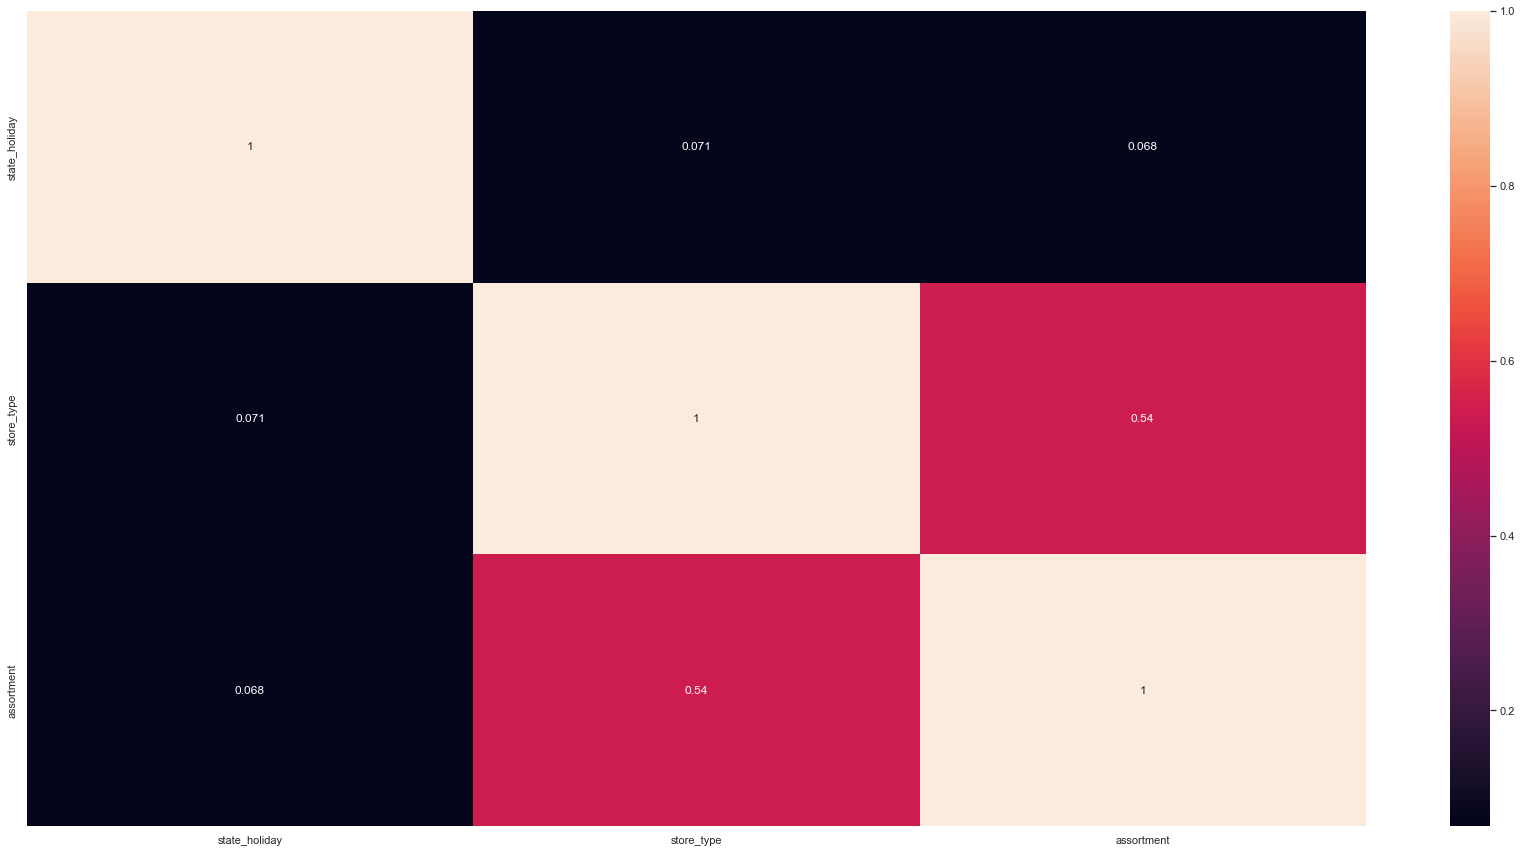

In [103]:
# only categorical data
a = df2.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame(  {'state_holiday': [a1, a2, a3], 
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9]
                    })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)
plt.show()

# Model Phase

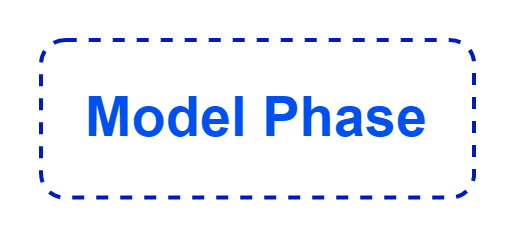

In [104]:
Image(filename='..\\..\\Assets\\Images\\Model Phase.png', width=250, height=100)

## Feature Engineering

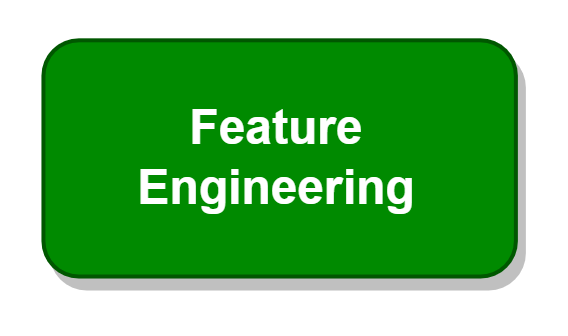

In [105]:
Image(filename='..\\..\\Assets\\Images\\Feature Engineering.png', width=200, height=100)

### Feature Engineering Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [106]:
df3 = df2.copy()
print("Checkpoint successful")

Checkpoint successful


In [107]:
df3.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday  \
0      1            5 2015-07-31   5263      1   Regular_Day               1   
1      2            5 2015-07-31   6064      1   Regular_Day               1   
2      3            5 2015-07-31   8314      1   Regular_Day               1   
3      4            5 2015-07-31  13995      1   Regular_Day               1   
4      5            5 2015-07-31   4822      1   Regular_Day               1   

  store_type assortment  competition_distance  ...  active_promo  year  month  \
0          c      Basic                1270.0  ...             0  2015      7   
1          a      Basic                 570.0  ...             1  2015      7   
2          a      Basic               14130.0  ...             1  2015      7   
3          c   Extended                 620.0  ...             0  2015      7   
4          a      Basic               29910.0  ...             0  2015      7   

   day  week_of_year  year_week  competition_since  competition_time_month  \
0   31            31    2015-30         2008-09-01                      84   
1   31            31    2015-30         2007-11-01                      94   
2   31            31    2015-30         2006-12-01                     105   
3   31            31    2015-30         2009-09-01                      71   
4   31            31    2015-30         2015-04-01                       4   

   promo_since  promo_time_week  
0   2015-07-27                0  
1   2010-03-22              279  
2   2011-03-28              226  
3   2015-07-27                0  
4   2015-07-27                0  

[5 rows x 25 columns]

### Objectives

O Feature Engineering serve para transformar os dados em um formato que pode ser utilizado pelo modelo.

O Feature Engineering é o último processo que lida com o dataset antes dele ser utilizado pelo modelo, e é composto principalmente de duas partes:
- Data Preparation
- Feature Selection

### Data Preparation

Na fase de Data Preparation, o dataset é tratado para que possamos utilizá-lo no modelo, essa fase é composta de quatro partes:
- Tratamento de variáveis numéricas
    - Normalização
        - Rescala o centro dos dados para zero com desvio padrão igual a 1
        - Funciona melhor para dados que já possuem uma distribuição normal
    - Rescaling
        - Rescala os dados para um intervalo de valores entre 0 e 1
        - Funciona melhor para dados que não possuem uma distribuição normal
- Tratamento de variáveis categóricas
    - Encoding
        - Transforma dados categóricos em dados numéricos
        - Existem vários tipos de encoding, como:
            - One-Hot Encoding
            - Label Encoding
            - Ordinal Encoding
- Tratamento de variáveis cíclicas
    - Transformação de Seno e Cosseno
        - Preserva a natureza cíclica dos dados
- Tratamento da variável resposta
    - Rescalam os valores da variável resposta de modo a ter uma distribuição mais próxima da normal
        - Transformação logarítmica
        - Transformação Box-Cox
        - Transformação Square Root
        - Transformação Cube Root

#### Numerical Variable Treatment

##### Normalization

Se tivermos dados que possuem uma distribuição normal, podemos normalizar os dados para que o centro seja zero e o desvio padrão seja igual a 1.

A fórmula de normalização é:

Como pudemos notar na análise univariada, a grande maioria dos dados não possuem uma distribuição normal, logo eles não se encaixam no processo de normalização. Então esta parte será pulada e vamos aplicar o rescaling neles em vez disso.

##### Rescaling

Se tivermos dados que não possuem uma distribuição normal, podemos rescalar os dados para que o intervalo deles fique entre 0 e 1.

Como pudemos notar na análise univariada, a grande maioria dos dados não possuem uma distribuição normal, logo eles se encaixam no processo de rescaling.

Tipos de rescaling:
- Min-Max Scaler
    - Muito sensível a outliers
    - Pode distorcer os dados rescalados por conta do peso dos outliers
- Robust Scaler
    - Considera os quartis individualmente
    - Elimina a sensibilidade a outliers

##### Robust Scaler

Vamos selecionar as colunas numéricas para aplicar o Robust Scaler:

In [108]:
#select all numeric columns
# numerical_data = df3.select_dtypes(include=[np.number]).copy()
numerical_data = df3.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).copy()
numerical_data.head()

store  day_of_week  sales  promo  school_holiday  competition_distance  \
0      1            5   5263      1               1                1270.0   
1      2            5   6064      1               1                 570.0   
2      3            5   8314      1               1               14130.0   
3      4            5  13995      1               1                 620.0   
4      5            5   4822      1               1               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  active_promo  year  month  day  \
0                 31               2015             0  2015      7   31   
1                 13               2010             1  2015      7   31   
2                 14               2011             1  2015      7   31   
3                 31               2015             0  2015      7   31   
4                 31               2015             0  2015      7   31   

   week_of_year  competition_time_month  promo_time_week  
0            31                      84                0  
1            31                      94              279  
2            31                     105              226  
3            31                      71                0  
4            31                       4                0

In [109]:
numerical_data.shape

(844338, 18)

In [110]:
numerical_columns = numerical_data.columns
numerical_columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'active_promo', 'year', 'month', 'day',
       'week_of_year', 'competition_time_month', 'promo_time_week'],
      dtype='object')

Vamos rescalar as colunas numéricas:
- 'competition_distance'
    - Tem o maior range de valores
- 'competition_time_month'
- 'promo_time_week'
- 'year'

Vamos verificar os outliers dessas colunas:

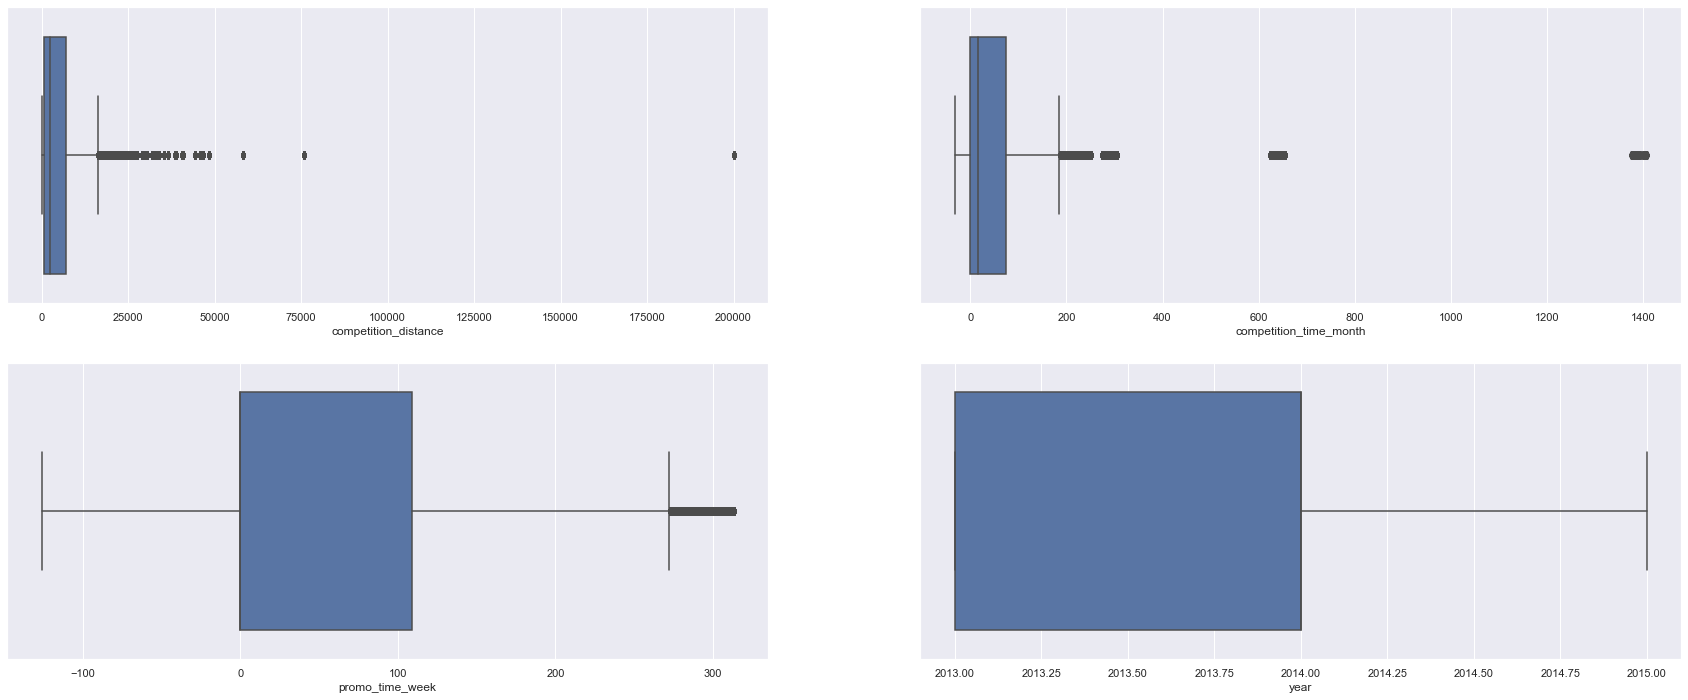

In [111]:
fig = plt.figure(figsize = (30,12))
plt.subplot(2, 2, 1)
sns.boxplot(numerical_data['competition_distance'])
plt.subplot(2, 2, 2)
sns.boxplot(numerical_data['competition_time_month'])
plt.subplot(2, 2, 3)
sns.boxplot(numerical_data['promo_time_week'])
plt.subplot(2, 2, 4)
sns.boxplot(numerical_data['year'])

plt.show()

Temos muitos outliers na 'competition_distance' e 'competition_time_month', e poucos na 'promo_time_week' e 'year'. Portanto vamos aplicar o Robust Scaler para as que tem mais outliers e o Min-Max Scaler para as que tem menos outliers.

In [112]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
numerical_data['competition_distance'] = rs.fit_transform(numerical_data[['competition_distance']].values)
#pickle.dump(rs, open('..//..//..//Data//Scalers/competition_distance_scaler.pkl', 'wb'))

# competition time month
numerical_data['competition_time_month'] = rs.fit_transform(numerical_data[['competition_time_month']].values)
#pickle.dump(rs, open('..//..//..//Data//Scalers/competition_time_month_scaler.pkl', 'wb'))

# promo time week
numerical_data['promo_time_week'] = mms.fit_transform(numerical_data[['promo_time_week']].values)
#pickle.dump(rs, open('..//..//..//Data//Scalers/promo_time_week_scaler.pkl', 'wb'))

# year
numerical_data['year'] = mms.fit_transform(numerical_data[['year']].values)
#pickle.dump(mms, open('..//..//..//Data//Scalers/year_scaler.pkl', 'wb'))

Neste caso os scalings não vão se apresentar diretamente no dataset, mas vão ser aplicados nele durante o processo de treinamento do modelo. Eles estão sendo salvos como arquivo pickle para serem chamados no próximo passo.

#### Categorical Variable Treatment

##### Encoding

Se tivermos dados categóricos, podemos transformá-los em dados numéricos para o modelo entender e processar a previsão.

Tipos de encoding:
- One-Hot Encoding
    - Transformação de natureza usada com dados de classificação específica, como tipos, tamanhos e cores
- Label Encoding
    - Transformação de natureza usada com dados não cíclicos e específicos, como nomes de estados e cidades
- Ordinal Encoding
    - Transformação de natureza usada com dados sequenciais, como classes, graus de importância, etc.

##### One-Hot Encoding

Vamos selecionar as colunas categóricas para aplicar o One-Hot Encoding:

In [113]:
categorical_data = df3.select_dtypes(exclude=['int64', 'int32', 'float64', 'float32']).copy()
categorical_data.head()

date state_holiday store_type assortment year_week competition_since  \
0 2015-07-31   Regular_Day          c      Basic   2015-30        2008-09-01   
1 2015-07-31   Regular_Day          a      Basic   2015-30        2007-11-01   
2 2015-07-31   Regular_Day          a      Basic   2015-30        2006-12-01   
3 2015-07-31   Regular_Day          c   Extended   2015-30        2009-09-01   
4 2015-07-31   Regular_Day          a      Basic   2015-30        2015-04-01   

  promo_since  
0  2015-07-27  
1  2010-03-22  
2  2011-03-28  
3  2015-07-27  
4  2015-07-27

Sobraram muitas datas como tipo 'object', mas datas não são consideradas categóricas e sim dados cíclicos ou temporais. Portanto vamos dropar as colunas que apresentam datas e ficar apenas com as colunas categóricas.

In [114]:
remaining_columns = categorical_data.columns
remaining_columns

Index(['date', 'state_holiday', 'store_type', 'assortment', 'year_week',
       'competition_since', 'promo_since'],
      dtype='object')

Vamos criar uma classe para poder cortar uma lista pelos seus índices:

In [115]:
class Flexlist(list):
    def __getitem__(self, keys):
        if isinstance(keys, (int, slice)): return list.__getitem__(self, keys)
        return [self[k] for k in keys]

L = Flexlist(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
T = L[[3, 5, 7]]

print(T, type(T))  # ['d', 'f', 'h']

['d', 'f', 'h'] <class 'list'>


In [116]:
remaining_columns = Flexlist(remaining_columns)
type(remaining_columns)

__main__.Flexlist

In [117]:
temporal_columns = remaining_columns[[0, 4, 5, 6]]
temporal_columns

['date', 'year_week', 'competition_since', 'promo_since']

In [118]:
categorical_columns = remaining_columns[[1,2,3]]
categorical_columns

['state_holiday', 'store_type', 'assortment']

Vamos ver o resultado ao dropar as colunas temporais:

In [119]:
categorical_data.drop(temporal_columns, axis=1, inplace=True)
categorical_data.head()

state_holiday store_type assortment
0   Regular_Day          c      Basic
1   Regular_Day          a      Basic
2   Regular_Day          a      Basic
3   Regular_Day          c   Extended
4   Regular_Day          a      Basic

Agora vamos realizar o One-Hot Encoding:

In [120]:
categorical_data = pd.get_dummies(categorical_data, prefix=['state_holiday'], columns=['state_holiday'])
categorical_data.sample(10)

store_type assortment  state_holiday_Christmas  state_holiday_Easter  \
835429          a      Basic                        0                     0   
453235          c      Basic                        0                     0   
294973          a      Basic                        0                     0   
879263          a      Basic                        0                     0   
641141          a   Extended                        0                     0   
664304          d   Extended                        0                     0   
250135          a   Extended                        0                     0   
164603          a      Basic                        0                     0   
280067          d   Extended                        0                     0   
779169          a      Basic                        0                     0   

        state_holiday_Public  state_holiday_Regular_Day  
835429                     0                          1  
453235                     0                          1  
294973                     0                          1  
879263                     0                          1  
641141                     0                          1  
664304                     0                          1  
250135                     0                          1  
164603                     0                          1  
280067                     0                          1  
779169                     0                          1

Esse é um dos tipos de encoding que vemos ser aplicado diretamente no dataset.

##### Label Encoding

In [121]:
le = LabelEncoder()

categorical_data['store_type'] = le.fit_transform(categorical_data['store_type'])
#pickle.dump(le, open('..//..//..//Data//Encoders/store_type_encoder.pkl', 'wb'))

Neste caso o encoding não vai se apresentar diretamente no dataset, mas vai ser aplicado nele durante o processo de treinamento do modelo. Ele está sendo salvo como arquivo pickle para ser chamado no próximo passo.

##### Ordinal Encoding

In [122]:
assortment_dict = {'Basic': 1, 'Extra': 2, 'Extended': 3}
categorical_data['assortment'] = categorical_data['assortment'].map(assortment_dict)
categorical_data.sample(10)

store_type  assortment  state_holiday_Christmas  state_holiday_Easter  \
585047           2           1                        0                     0   
82112            0           1                        0                     0   
804484           0           1                        0                     0   
234656           0           3                        0                     0   
806701           0           1                        0                     0   
805135           0           3                        0                     0   
668676           0           1                        0                     0   
962382           0           1                        0                     0   
230646           3           3                        0                     0   
452540           2           1                        0                     0   

        state_holiday_Public  state_holiday_Regular_Day  
585047                     0                          1  
82112                      0                          1  
804484                     0                          1  
234656                     0                          1  
806701                     0                          1  
805135                     0                          1  
668676                     0                          1  
962382                     0                          1  
230646                     0                          1  
452540                     0                          1

In [123]:
categorical_data.shape

(844338, 6)

Neste caso o encoding se apresenta diretamente no dataset.

#### Cyclic Variable Treatment

Vamos aplicar o encoding de Seno e Cosseno para as colunas com dados cíclicos ou temporais:

In [124]:
temporal_data = df3[[*temporal_columns,'day','month','day_of_week','week_of_year']].copy()
temporal_data.head()

date year_week competition_since promo_since  day  month  day_of_week  \
0 2015-07-31   2015-30        2008-09-01  2015-07-27   31      7            5   
1 2015-07-31   2015-30        2007-11-01  2010-03-22   31      7            5   
2 2015-07-31   2015-30        2006-12-01  2011-03-28   31      7            5   
3 2015-07-31   2015-30        2009-09-01  2015-07-27   31      7            5   
4 2015-07-31   2015-30        2015-04-01  2015-07-27   31      7            5   

   week_of_year  
0            31  
1            31  
2            31  
3            31  
4            31

In [125]:
temporal_data.shape

(844338, 8)

Vamos criar duas colunas a mais para cada dado temporal, uma sendo o enconding do Seno e outra o enconding do Cosseno:

In [126]:
temporal_data['day_sin'] = temporal_data['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
temporal_data['day_cos'] = temporal_data['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

temporal_data['month_sin'] = temporal_data['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
temporal_data['month_cos'] = temporal_data['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

temporal_data['day_of_week_sin'] = temporal_data['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
temporal_data['day_of_week_cos'] = temporal_data['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

temporal_data['week_of_year_sin'] = temporal_data['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
temporal_data['week_of_year_cos'] = temporal_data['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [127]:
temporal_data.head()

date year_week competition_since promo_since  day  month  day_of_week  \
0 2015-07-31   2015-30        2008-09-01  2015-07-27   31      7            5   
1 2015-07-31   2015-30        2007-11-01  2010-03-22   31      7            5   
2 2015-07-31   2015-30        2006-12-01  2011-03-28   31      7            5   
3 2015-07-31   2015-30        2009-09-01  2015-07-27   31      7            5   
4 2015-07-31   2015-30        2015-04-01  2015-07-27   31      7            5   

   week_of_year            day_sin            day_cos           month_sin  \
0            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
1            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
2            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
3            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
4            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   

            month_cos     day_of_week_sin     day_of_week_cos  \
0 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
1 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
2 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
3 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
4 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   

     week_of_year_sin    week_of_year_cos  
0 -0.5680647467311556 -0.8229838658936566  
1 -0.5680647467311556 -0.8229838658936566  
2 -0.5680647467311556 -0.8229838658936566  
3 -0.5680647467311556 -0.8229838658936566  
4 -0.5680647467311556 -0.8229838658936566

Neste caso o encoding se apresenta diretamente no dataset, criando novas colunas e alterando os dados a partir das colunas originais.

#### Target Variable Treatment

Vamos aplicar o encoding logarítmico para a variável resposta:

In [128]:
numerical_data['sales'] = np.log1p(numerical_data['sales'])
numerical_data['sales'].head()

0   8.568646473005153
1    8.71028982137815
2   9.025816391627028
3    9.54652685348758
4   8.481151420068972
Name: sales, dtype: float64

Neste caso o encoding se apresenta diretamente no dataset.

#### Encoded Dataset

Agora vamos fundir os três datasets que criamos durante o rescaling e encoding das variáveis para obter o dataset tratado para o treinamento do modelo:

Vamos conferir os formatos de cada dataset para assegurar que nenhuma **linha** foi adicionada, pois isso tornaria impossível a fusão dos datasets já que perderíamos o índice correto para fundir.

A idéia do Feature Engineering no geral é aumentar o número de **colunas** para encodar as variáveis categóricas e criar rescalers para aplicação nas variáveis numéricas.

In [129]:
def get_feature_engineering_formats(df, index_list):
    rows = []
    columns = []
    if isinstance(df, list):
        for dformat in df:
            rows.append(dformat.shape[0])
            columns.append(dformat.shape[1])
    res = pd.DataFrame({'Linhas': rows, 'Colunas': columns})
    # Define the indexes names
    res.index = [x.capitalize().replace('_', ' ') for x in index_list]
    res.index.name = "Data Frame"
    check_size = "Incompatível"
    #check if all values are equal on the rows column, if so, changing the variable check_size to "Compatible"
    if len(set(res['Linhas'])) == 1:
        check_size = "Compatível"
    res.loc['Formato'] = [check_size, '---']

    return res

In [130]:
formats = get_feature_engineering_formats(  [numerical_data, categorical_data, temporal_data],
                                            ['numerical_data', 'categorical_data', 'temporal_data'])
formats

Linhas Colunas
Data Frame                          
Numerical data        844338      18
Categorical data      844338       6
Temporal data         844338      16
Formato           Compatível     ---

##### Dataset Fusion

Com os formatos compatíveis e mesmo número de linhas, vamos fazer a fusão dos datasets:

In [131]:
def get_encoded_dataset(df):
    if isinstance(df, list):
        df = pd.concat(df, axis=1)
    return df

In [132]:
encoded_dataset = get_encoded_dataset([numerical_data, categorical_data, temporal_data])
encoded_dataset.shape

(844338, 40)

In [133]:
encoded_dataset.head()

store  day_of_week             sales  promo  school_holiday  \
0      1            5 8.568646473005153      1               1   
1      2            5  8.71028982137815      1               1   
2      3            5 9.025816391627028      1               1   
3      4            5  9.54652685348758      1               1   
4      5            5 8.481151420068972      1               1   

   competition_distance  competition_open_since_month  \
0  -0.17096774193548386                             9   
1   -0.2838709677419355                            11   
2     1.903225806451613                            12   
3  -0.27580645161290324                             9   
4     4.448387096774193                             4   

   competition_open_since_year  promo2  promo2_since_week  ...  day_of_week  \
0                         2008       0                 31  ...            5   
1                         2007       1                 13  ...            5   
2                         2006       1                 14  ...            5   
3                         2009       0                 31  ...            5   
4                         2015       0                 31  ...            5   

   week_of_year            day_sin            day_cos           month_sin  \
0            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
1            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
2            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
3            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
4            31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   

            month_cos     day_of_week_sin     day_of_week_cos  \
0 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
1 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
2 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
3 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
4 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   

     week_of_year_sin    week_of_year_cos  
0 -0.5680647467311556 -0.8229838658936566  
1 -0.5680647467311556 -0.8229838658936566  
2 -0.5680647467311556 -0.8229838658936566  
3 -0.5680647467311556 -0.8229838658936566  
4 -0.5680647467311556 -0.8229838658936566  

[5 rows x 40 columns]

In [134]:
non_eligible_cols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
encoded_dataset = encoded_dataset.drop(non_eligible_cols, axis=1)

In [135]:
encoded_dataset.head()

store             sales  promo  school_holiday  competition_distance  \
0      1 8.568646473005153      1               1  -0.17096774193548386   
1      2  8.71028982137815      1               1   -0.2838709677419355   
2      3 9.025816391627028      1               1     1.903225806451613   
3      4  9.54652685348758      1               1  -0.27580645161290324   
4      5 8.481151420068972      1               1     4.448387096774193   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  ...  state_holiday_Regular_Day  \
0                 31               2015  ...                          1   
1                 13               2010  ...                          1   
2                 14               2011  ...                          1   
3                 31               2015  ...                          1   
4                 31               2015  ...                          1   

        date            day_sin            day_cos           month_sin  \
0 2015-07-31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
1 2015-07-31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
2 2015-07-31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
3 2015-07-31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   
4 2015-07-31 0.2079116908177585 0.9781476007338058 -0.4999999999999997   

            month_cos     day_of_week_sin     day_of_week_cos  \
0 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
1 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
2 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
3 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   
4 -0.8660254037844388 -0.9749279121818236 -0.2225209339563146   

     week_of_year_sin    week_of_year_cos  
0 -0.5680647467311556 -0.8229838658936566  
1 -0.5680647467311556 -0.8229838658936566  
2 -0.5680647467311556 -0.8229838658936566  
3 -0.5680647467311556 -0.8229838658936566  
4 -0.5680647467311556 -0.8229838658936566  

[5 rows x 29 columns]

In [136]:
encoded_dataset.shape

(844338, 29)

Graças ao encoding e rescaling, ganhamos uma quantidade considerável de colunas no dataset tratado, mas filtramos uma última vez para remover colunas redundantes que foram usadas para criar outras.

##### Encoded Dataset Storage

Vamos salvar o dataset tratado para carregar novamente quando necessário

In [137]:
def get_file_size(file_path):
    """
    This function will return the file size and its unit
    """
    if os.path.isfile(file_path):
        num = os.stat(file_path)
        size = num.st_size
        
        for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
            if size < 1024.0:
                return "%3.1f %s" % (size, x)
            size /= 1024.0
    
def save_dataset(dataset, name = ""):
    directory = '..//..//..//Data//Dataset//'
    path = directory + name + '.csv'
    
    # if dataset already exists, delete it
    if os.path.exists(path):
        os.remove(path)
        print(f'Previous Dataset: {name} deleted!')
        
    #save the new file
    with open(path, "w") as file:
        dataset_final = pd.DataFrame.to_csv(dataset, header=True, index=True, encoding="utf-8")
        file.write(dataset_final)
    size = get_file_size(path)
    
    return(print(   f'Current Dataset: {name} saved successfully!'+'\n'
                    +f'With size: {size}!'))

def load_dataset(name):
    directory = '..//..//..//Data//Dataset//'
    path = directory + name + '.csv'
    dataset = pd.read_csv(path, index_col = 0)
    print(f'Current Dataset: {name} loaded successfully!')
    return dataset

In [138]:
save_dataset(encoded_dataset, name = "Dataset_Encoded")
#test = load_dataset('..//..//..//Data//Dataset//Dataset_Encoded.csv')
#test.shape

Previous Dataset: Dataset_Encoded deleted!
Current Dataset: Dataset_Encoded saved successfully!
With size: 233.8 MB!


In [139]:
#test.head()

### Feature Selection

Agora vamos selecionar as variáveis que vamos utilizar para o treinamento do modelo, o principal objetivo é eliminar variáveis linearmente dependentes de outras, pois quanto mais colunas mais confuso o modelo pode ficar em chegar a uma conclusão, e informações redundantes não ajudam nisso.

Para realizar o Feature Selection existem alguns métodos:
- PCA - Principal Component Analysis
- Lasso - Least Absolute Shrinkage and Selection Operator
- Random Forest - Random Forest Classifier
- Extrative Feature Selection - Extrative Feature Selection
- Feature Importance - Feature Importance


Para determinar quais variáveis vão ser treino e teste, vamos analisar o que queremos prever.
- Queremos prever as vendas para as próximas 8 semanas. 
    - Vamos ver no dataset quais são as datas iniciais e finais qu estão presentes.
    - Vamos separar as últimas 8 semanas do dataset para o teste
    - Das últimas 8 semanas pra trás, serão a parte de treino do modelo

Vamos agrupar as datas por loja, mostrando assim a data máxima que cada loja registrou

In [140]:
encoded_dataset[['store','date']].groupby('store').max().reset_index().head()

store       date
0      1 2015-07-31
1      2 2015-07-31
2      3 2015-07-31
3      4 2015-07-31
4      5 2015-07-31

- A data máxima é 2015-07-31
    - Vamos pegar 8 semanas antes desta data e separar no conjunto de teste
    - Vamos escolher da coluna 'date' o primeiro elemento que aparecer, que é a data máxima registrada
    - Dela, vamos subtrair 8 semanas (7 dias vezes 8)

In [141]:
encoded_dataset[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*8)

Timestamp('2015-06-05 00:00:00')

Nossa primeira data é dia 5 do 6, então a partir da data mínima até dia 4 do 6 vamos usar de treino, e do dia 5 do 6 até a data máxima vamos usar de teste

In [142]:
encoded_dataset[['store','date']].groupby('store').min().reset_index().head()

store       date
0      1 2013-01-02
1      2 2013-01-02
2      3 2013-01-02
3      4 2013-01-02
4      5 2013-01-02

A data mínima é 2012-01-01

In [143]:
# training dataset
X_train = encoded_dataset[encoded_dataset['date'] < '2015-06-05']
y_train = X_train['sales']
# test dataset
X_test = encoded_dataset[encoded_dataset['date'] >= '2015-06-05']
y_test = X_test['sales']

# YTrain data is the result we want which is in the 'sales' column, 
# so we get it from the XTrain dataframe, with the variables already filtered, 
# same happens with the YTest data

#Drop the target variable 'sales' and future variable 'date' from the XTrain dataframe
#In order to do not train with it
X_train.drop(['date', 'sales'], axis=1).head()

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-04 00:00:00

Test Min Date: 2015-06-05 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [144]:
# training and test dataset for Boruta
#need to pass numpy arrays, not dataframes
#for this we use the .values attribute and the ravel method
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel() #ravel method returns a flattened array

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# Train Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
#feature_selection_cols = boruta.support_.tolist() #returns a dataframe with the selected columns

#### Best Features

Com as colunas mais importantes separadas, vamos verificar se alguma coluna não ficou de fora quando comparado com nosas conclusões na fase da análise exploratória, e também ver o quanto as colunas escolhidas pelo algoritmo se aproximam das conclusões da análise.

Notamos que estão faltando as variáveis **'month_sin'** e **'year'**, que de acordo com a análise exploratória, mês e ano tinham um impacto grande na variável resposta 'sales', então vamos colocar essas variáveis no dataset manualmente. 

A coluna 'month_cos' é parte da variável mês, mas 'month_sin' também é pois o encoding gerou ambas, então vamos deixar as duas no dataset final.
- Com isto obtivemos ajuda do algorítmo Boruta para escolher as colunas que melhor se aproximam das conclusões da análise
- E ao mesmo tempo não descartamos nossos próprios insights da análise exploratória


In [145]:
# Lists of selected features
feature_selection_cols = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
    'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
    'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos',
    'week_of_year_sin', 'week_of_year_cos']
#List of insights features
insights_selected = ['month_sin', 'year']
#List of cross validation needed features
cross_val_extra_features = ['date', 'sales']

In [146]:
# not selected boruta
train_cols = list(X_train.columns)
cols_not_selected = list(np.setdiff1d(train_cols , feature_selection_cols))
print(feature_selection_cols,'\n', cols_not_selected)

['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'] 
 ['active_promo', 'date', 'month_sin', 'sales', 'school_holiday', 'state_holiday_Christmas', 'state_holiday_Easter', 'state_holiday_Public', 'state_holiday_Regular_Day', 'year']


In [147]:
#List of features to be used in the model
feature_selection_cols.extend(insights_selected)
#List of features to be used in the model cross validation
cross_val_cols = feature_selection_cols.copy()
cross_val_cols.extend(cross_val_extra_features)
feature_selection = cross_val_cols.copy()

In [148]:
print(f'Features selected: \n {feature_selection}')

Features selected: 
 ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'year', 'date', 'sales']


#### Final Dataset Storage

Vamos salvar o dataset final para carregar novamente quando necessário.

In [149]:
encoded_dataset[feature_selection].head()

store  promo  store_type  assortment  competition_distance  \
0      1      1           2           1  -0.17096774193548386   
1      2      1           0           1   -0.2838709677419355   
2      3      1           0           1     1.903225806451613   
3      4      1           2           3  -0.27580645161290324   
4      5      1           0           1     4.448387096774193   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  ...     day_of_week_cos  \
0                 31               2015  ... -0.2225209339563146   
1                 13               2010  ... -0.2225209339563146   
2                 14               2011  ... -0.2225209339563146   
3                 31               2015  ... -0.2225209339563146   
4                 31               2015  ... -0.2225209339563146   

            month_cos            day_sin            day_cos  \
0 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
1 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
2 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
3 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
4 -0.8660254037844388 0.2079116908177585 0.9781476007338058   

     week_of_year_sin    week_of_year_cos           month_sin  year  \
0 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
1 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
2 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
3 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
4 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   

        date             sales  
0 2015-07-31 8.568646473005153  
1 2015-07-31  8.71028982137815  
2 2015-07-31 9.025816391627028  
3 2015-07-31  9.54652685348758  
4 2015-07-31 8.481151420068972  

[5 rows x 23 columns]

In [150]:
model_dataset = encoded_dataset[feature_selection]

In [151]:
model_dataset.shape

(844338, 23)

In [152]:
save_dataset(model_dataset, name = "Dataset_Model")

Previous Dataset: Dataset_Model deleted!
Current Dataset: Dataset_Model saved successfully!
With size: 224.2 MB!


In [153]:
import gc
gc.collect()

80

Com isso temos nosso dataset final salvo em um arquivo CSV.

## Model Building

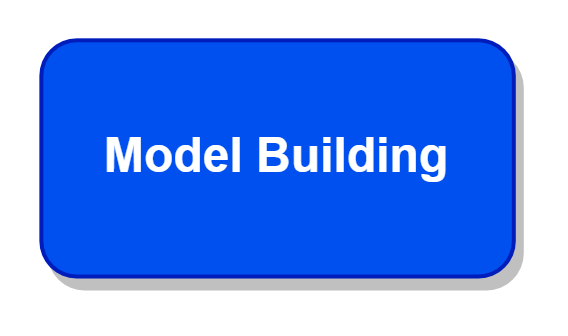

In [154]:
Image(filename='..\\..\\Assets\\Images\\Model Building.png', width=200, height=100)

A parte de Model Building é composta principalmente por três partes:
- Train-Test Splitting
   - Vamos separar o dataset em treino e teste, descartando as variáveis resposta
- Model Selection
    - Baseline Model
        - Vamos criar um modelo base para comparar com o modelo que vamos construir
    - Model Type Selection
        - Vamos escolher o melhor tipo de modelo para o problema
        - Escolhemos alguns modelos dessa classe para comparar com o modelo base
- Model Training
    - Baseline Training
        - Vamos treinar os modelos escolhidos normalmente e verificar os resultados
    - Cross Validation Training
        - Vamos treinar os modelos escolhidos cada um com o método de Cross Validation para ver seu desempenho geral no dataset
        - A divisão em treino e teste feita por nós é apenas um dos jeitos de se fazer a divisão do dataset, o modelo pode performar muito bem ou muito mal na divisão que fizemos
        - Por isso que executamos o Cross Validation, para avaliar o desempenho do modelo no dataset geral, com várias possibilidades de divisões em treino e teste sendo testadas e calculando a média do desempenho em cada uma

### Model Building Checkpoint

Fazendo um checkpoint, carregamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [155]:
model_dataset = load_dataset('Dataset_Model')
model_dataset.shape

Current Dataset: Dataset_Model loaded successfully!


(844338, 23)

In [156]:
model_dataset.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo_time_week                 float64
day_of_week_sin                 float64
day_of_week_cos                 float64
month_cos                       float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
month_sin                       float64
year                            float64
date                             object
sales                           float64
dtype: object

In [157]:
model_dataset["date"] = pd.to_datetime(model_dataset["date"])
model_dataset.dtypes

store                                    int64
promo                                    int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
competition_time_month                 float64
promo_time_week                        float64
day_of_week_sin                        float64
day_of_week_cos                        float64
month_cos                              float64
day_sin                                float64
day_cos                                float64
week_of_year_sin                       float64
week_of_year_cos                       float64
month_sin                              float64
year                                   float64
date         

### Train-Test Splitting

Vamos separar o dataset final em treino e teste, descartando as variáveis resposta, e também em treino de Cross Validation, neste caso preservando as variáveis resposta.

Vamos especificar qual é a variável resposta quando o Cross Validation for usado.

In [158]:
# training dataset
X_train = model_dataset[model_dataset['date'] < '2015-06-05']
y_train = X_train['sales']
# test dataset
X_test = model_dataset[model_dataset['date'] >= '2015-06-05']
y_test = X_test['sales']
# Cross validation training/testing dataset, uses all the features, including the target variable
# We'll specify the target variable in the cross val function
X_Cross = model_dataset[cross_val_cols]
# Minimun and maximum date for the Train and Test dataset
Train_min_date, Train_max_date = X_train['date'].min(), X_train['date'].max()
Test_min_date, Test_max_date = X_test['date'].min(), X_test['date'].max()
# Drop the target variable 'sales' and future variable 'date' from the XTrain dataframe
# In order to do not train with it
# Also drop every other column that is not needed for the model, using the filter 'feature_selection_cols'
X_train = X_train[feature_selection_cols]
X_test = X_test[feature_selection_cols]

In [159]:
def save_model(model, model_name):
    file_name = model_name
    if '.pkl' in model_name:
        model_name.replace('.pkl', '')
    model_name = '..//..//..//Data//Models//' + model_name + '.pkl'
    pickle.dump(model, open(model_name, 'wb'))
    print(f'{file_name} saved successfully!')
    return True

In [160]:
print(f'Training Min Date: {Train_min_date}')
print(f'Training Max Date: {Train_max_date}')

print(f'\nTest Min Date: {Test_min_date}')
print(f'Test Max Date: {Test_max_date}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-04 00:00:00

Test Min Date: 2015-06-05 00:00:00
Test Max Date: 2015-07-31 00:00:00


Com isso temos 3 datasets:
- Treino
    - X_train: Variáveis de treino
    - y_train: Variável única de resposta do treino
    - Estes datasets passam pelo treinamento do modelo normal
- Teste
    - X_test: Variáveis de teste
    - y_test: Variável única de resposta do teste
    - Estes datasets não passam pelo treinamento do modelo, ficando intocados até o final
- Cross Validation
    - X_Cross: Variáveis de treino para o Cross Validation, incluindo a variável resposta e a variável de data
    - A variável de data tem de estar presente pois temos uma série temporal como problema
    - Este dataset passa pelo treinamento do modelo em Cross Validation

### Model Selection

Vamos criar o modelo de baseline e escolher os modelos com os quais vamos trabalhar no dataset, dentro desta fase teremos dois tipos de treinamento:
- Baseline Training
    - Vamos treinar os modelos de modo normal, com os datasets de treino e teste
- Cross Validation Training
    - Vamos treinar os modelos no modo de Cross Validation, com o dataset de crossval, e verificar o desempenho real no dataset

#### Model Metrics Function

In [161]:
def model_metrics(model_name, y_test, y_pred, y_rescale = None):
    """ 
    This function calculates the mean absolute error, mean absolute percentage error, root mean squared error, 
    and mean percentage error of the predicted values.
    
    Parameters
    ----------
    y_test : array-like of shape (n_samples)
        The real values.
    y_pred : array-like of shape (n_samples)
        The predicted values.
    y_rescale : array-like of shape (n_samples)
        If the passed values need to be rescaled.
    
    Returns
    -------
    mae : float
        The mean absolute error.
    mape : float
        The mean absolute percentage error.
    rmse : float
        The root mean squared error.
    mpe : float
        The mean percentage error.
    rmsee : float
        The root mean squared error of estimation.
    """
    if y_rescale == 'Exponential':
        y_test = np.exp(y_test)
        y_pred = np.exp(y_pred)
        
    def metric_round(metrics_list):
        metric = float(np.round(metrics_list, 4))
        return metric
    
    def mean_percentage_error(y_test, y_pred):
        #remove all rows with zero sales to prevent division by zero
        #real problem when it happens, luckily it doesn't affect the metrics
        y_test = y_test[y_test != 0]
        y_pred = y_pred[y_pred != 0]
        mpe = np.mean((y_test - y_pred)/y_test)
        return mpe
    
    # def root_mean_squared_error_of_estimation(y_test, y_pred):
    #The Root Mean Squared Error of Estimation (RMSEE) is calculated as the root squared distance between 
    # the real Y variable (y_test) - the estimated Y variable (y_pred)
    #This means that its value depends on the original Y variable scale.
    
    #The RMSEcv instead gives you an idea of the standard deviation of the RMSEE. 
    #If the RMSEcv is very different from the RMSEE, it means that every CV model is predicting worse your observation.
    #https://www.researchgate.net/post/What-is-the-acceptable-range-for-root-mean-square-error-of-estimation-
    # RMSEE-and-root-mean-square-error-of-cross-validation-RMSECV
    #    rmsee = np.sqrt(mean_squared_error(y_test - y_pred))
    #   return rmsee
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mpe = mean_percentage_error(y_test, y_pred)
    #rmsee = root_mean_squared_error_of_estimation(y_test, y_pred)
    
    model_metrics = {'Model Name': model_name, 
                'MAE': metric_round(mae), 
                'MAPE': metric_round(mape),
                'RMSE': metric_round(rmse),
                'MPE': metric_round(mpe)
                #'RMSEE': metric_round(rmsee)
                }
    
    metrics = pd.DataFrame(model_metrics, index=[0])
    
    return metrics

#### Baseline Training

##### Baseline Model

Nosso modelo de baseline será o Average Model, que retorna a média de vendas que uma loja teve em todo o período registrado.

In [162]:
baseline_X = X_test.copy()
baseline_X['sales'] = y_test.copy()

# prediction
baseline_Y = baseline_X[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
baseline_Y.head()

store       predictions
0      1 8.370874996148268
1      2 8.450080327055542
2      3 8.811749300193153
3      4 9.175290878939428
4      5 8.350147794800296

Com a predição de média feita, vamos juntar os datasets de treino e teste, e verificar o desempenho do modelo.

In [163]:
baseline_model = pd.merge(baseline_X, baseline_Y, how='left', on='store')
y_pred_baseline = baseline_model['predictions']

# performance
baseline_result = model_metrics('Average Model', y_test, y_pred_baseline, 'Exponential')
baseline_result

Model Name       MAE   MAPE     RMSE     MPE
0  Average Model 1352.1875 0.2049 1829.165 -0.1412

##### Linear Regression Model

In [164]:
# model
#lnr_model = LinearRegression().fit(X_train, y_train)

#prediction
#ypred_lnr = lnr_model.predict(X_test)

#performance
#lnr_result = model_metrics('Linear Regression', y_test, ypred_lnr, 'Exponential')
#save_model(lnr_model, 'Linear Regression')
#lnr_result

##### Lasso Regression Model

In [165]:
# model
#lsr_model = Lasso(alpha=0.01).fit(X_train, y_train)

# prediction
#ypred_lsr = lsr_model.predict(X_test)

# performance
#lsr_result = model_metrics('Lasso Regression', y_test, ypred_lsr, 'Exponential')
#save_model(lsr_model, 'Lasso Regression')
#lsr_result

##### Random Forest Regressor Model

In [166]:
# model
#rfr_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

# prediction
#ypred_rfr = rfr_model.predict(X_test)

# performance
#rfr_result = model_metrics('Random Forest Regressor', y_test, ypred_rfr, 'Exponential')
#save_model(rfr_model, 'Random Forest Regressor')
#rfr_result

##### XGBoost Regressor Model

In [167]:
# model
xgbr_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10,
                            subsample=0.7, colsample_bytee=0.9).fit(X_train, y_train)

# prediction
ypred_xgbr = xgbr_model.predict(X_test)

# performance
xgbr_result = model_metrics('XGBoost Regressor', y_test, ypred_xgbr, 'Exponential')
#save_model(xgbr_model, 'XGBoost Regressor')
xgbr_result

Model Name       MAE   MAPE      RMSE    MPE
0  XGBoost Regressor 6706.3215 0.9498 7349.1828 0.9498

In [168]:
#import gc
#gc.collect()

#### Cross Validation Training

##### Cross Validation Function

Vamos implementar a fnção de Cross Validation com time series. 

Neste caso de dataset com time series, o fatiamento dos dados deve ser sequencial, não randomizado. 
- Os dados de treino vem antes no tempo, e os de teste vem depois.
- Na próxima iteração, os dados de teste e treino anterior viram os dados de treino atual, e os novos dados de teste vem depois no tempo
- A janela de treinamento será o tamanho do dataset de teste que determinamos, ou seja, o alvo da nossa previsão
    - Se queremos prever as próximas 8 semanas, a janela de teste deverá ser de 8 semanas

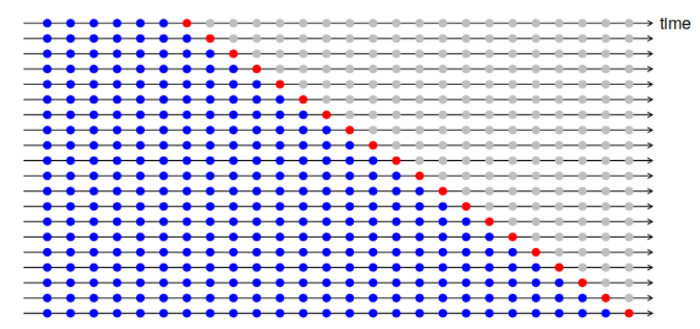

In [169]:
Image(filename='..\\..\\Assets\\Images\\Time_series_training.png', width=1000, height=500)

In [170]:
def crossval_time_series(cross_dataset, kfold, weeks, model_name, target_model, target_cols_xy, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    mpe_list = []
    #We start the counting from the end of the K fold, then we subtract the round at each loop
    #When the K fold number reachs 1, the looping will do it's last round and there will be no timedelta do run
    #on the validation_end_date, which means that the validation_end_date will be the last date of the dataset itself
    def metric_format(metric_list):
        metric_format = np.round(np.mean(metric_list), 2).astype(str) + ' +/- ' + np.round(np.std(metric_list), 2).astype(str)
        return metric_format
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('KFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = cross_dataset['date'].max() - timedelta(days = k*weeks*7)
        validation_end_date = cross_dataset['date'].max() - timedelta(days = (k-1)*weeks*7)
        # filtering dataset
        training = cross_dataset[cross_dataset['date'] < validation_start_date]
        validation = cross_dataset[(cross_dataset['date'] >= validation_start_date) & (cross_dataset['date'] <= validation_end_date)]
        # training and validation datasets
        # training
        x_train = training.drop(target_cols_xy[0], axis=1) 
        y_train = training[target_cols_xy[1]]
        # validation
        x_test = validation.drop(target_cols_xy[0], axis=1)
        y_test = validation[target_cols_xy[1][0]] 
        #to calc metrics we can use it as a Series
        #later: series -> np.array -> float
        # target_model
        model = target_model.fit(x_train, y_train)
        # prediction
        y_pred = model.predict(x_test)
        # performance
        model_result = model_metrics(model_name, y_test, y_pred, 'Exponential')
        # store performance of each kfold iteration
        mae_list.append(model_result['MAE'].values)
        mape_list.append(model_result['MAPE'].values)
        rmse_list.append(model_result['RMSE'].values)
        mpe_list.append(model_result['MPE'].values) #previously float(model_result['MPE'].values)
        
    cross_val_results = {'Model Name': model_name,
                        'MAE CV': metric_format(mae_list),
                        'MAPE CV': metric_format(mape_list),
                        'RMSE CV': metric_format(rmse_list),#
                        'MPE CV': metric_format(mpe_list)}#
    cross_val = pd.DataFrame(cross_val_results, index=[0])
    
    return cross_val

##### Linear Regression Model

In [171]:
#lnr_result_cv = crossval_time_series(X_Cross, 5, 8, 'Linear Regression', lnr_model, (['date', 'sales'],['sales']), verbose = True)

#lnr_result_cv

##### Lasso Regression Model

In [172]:
#lsr_result_cv = crossval_time_series(X_Cross, 5, 8, 'Lasso Regression', lsr_model, (['date', 'sales'],['sales']), verbose = True)

#lsr_result_cv

##### Random Forest Regressor Model

In [173]:
#rfr_result_cv = crossval_time_series(X_Cross, 5, 8, 'Random Forest Regressor', rfr_model, (['date', 'sales'],['sales']), verbose = True)

#rfr_result_cv

##### XGBoost Regressor Model

In [174]:
#xgbr_result_cv = crossval_time_series(X_Cross, 5, 8, 'XGBoost Regressor', xgbr_model, (['date', 'sales'],['sales']), verbose = True)

#xgbr_result_cv

In [175]:
#import gc
#gc.collect()

#### Models Performance

##### Baseline Training Comparison

In [176]:
#modelling_result = pd.concat([baseline_result, lnr_result, lsr_result, rfr_result, xgbr_result])
#modelling_result

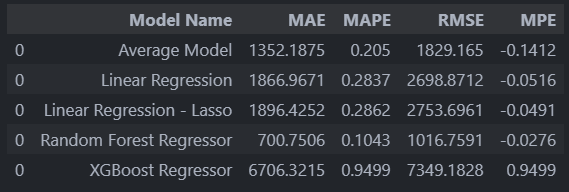

In [177]:
Image(filename='..\\..\\Assets\\Images\\Baseline_Training_Comparison.png', width=700, height=180)

##### Cross Validation Training Comparison

In [178]:
#modelling_result_cv = pd.concat([lnr_result_cv, lsr_result_cv, rfr_result_cv, xgbr_result_cv])
#modelling_result_cv

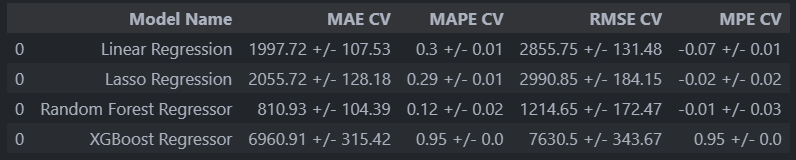

In [179]:
Image(filename='..\\..\\Assets\\Images\\Cross_Validation_Training_Comparison.png', width=900, height=170)

## Model Evaluation

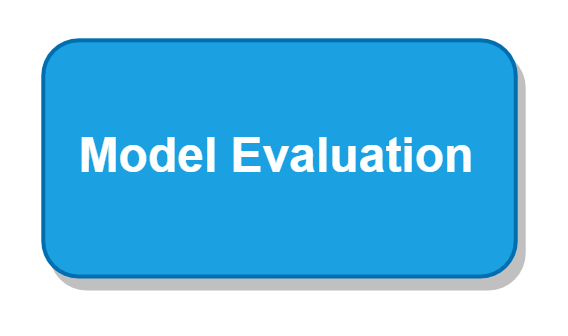

In [180]:
Image(filename='..\\..\\Assets\\Images\\Model Evaluation.png', width=200, height=100)

Nesta fase avaliamos o desempenho dos modelos escolhidos e alteramos seus parâmetros para maximizar o desempenho. Também escolhemos o melhor modelo para usar como modelo final desta análise.

A Model Evaluation é composta de três partes:
- Model Comparison
    - Vamos comparar os modelos escolhidos com o modelo base e verificar qual tem o melhor desempenho geral no dataset, resultado obtido no desempenho do cross validation
- Model Hyperparameter Fine Tuning
    - Vamos alterar os parâmetros do modelo escolhido para melhorar o desempenho de acordo com algum algoritmo de otimização de parâmetros
- Final Model Selection
    - Vamos treinar o melhor modelo com os parâmetros finais escolhidos
    - Este modelo será usado para prever os dados de teste
    - Este modelo será salvo em um arquivo binário .pkl para uso posterior

### Model Evaluation Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [181]:
# df5 = df4.copy()
#print("Checkpoint successful")

In [182]:
# df5.head()

### Model Hyperparameter Fine Tuning

Nesta fase buscamos encontrar a melhor combinação de parâmetros possíveis para maximizar o aprendizado e o desempennho do modelo.

A fase de hyperparameter tuning pode ser feita de três formas:
- Random Search
    - Define valores aleatórios para os parâmetros do modelo
    - Veloz, porém não testa todas as combinações de parâmetros possíveis
- Grid Search
    - Define todas as combinações possíveis de parâmetros para o modelo
    - Extremamente lento, mas testa todas as combinações de parâmetros possíveis
    - Sempre chega ao melhor resultado possível
- Bayesian Search
    - Intermediário entre os dois, é mais lento que o Random Search, mas mais rápido que o Grid Search
        - Define os valores de parâmetros do modelo com base na teoria de Bayes
    - Busca os melhores parâmetos futuros com base nos resultados de cada treinamento anterior

#### Random Search

Vamos utilizar o Random Search para encontrar a melhor combinação de parâmetros para o modelo. 
- Um bom número de ciclos de busca é 10
- Quanto maior o número de estimadores, mais demorado o processo de busca

In [183]:
param = {
    'n_estimators': [150, 170, 250, 300, 350],#[1500, 1700, 2500, 3000, 3500]
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

cycles = 3 #3

In [184]:
def execution_time(start = False, end = False, start_time = None):
    if start:
        start_cycle = time.time()
        return start
    elif end:
        end_cycle = time.time()
        current_cycle = round(end_cycle - start_time, 2)
        estimated = timedelta(seconds = (current_cycle*(cycles-1)))
        current_cycle = timedelta(seconds = (current_cycle))
        estimated = str(estimated).split('.')[0]
        current_cycle = str(current_cycle).split('.')[0]
        
        print(f'Current Cycle: {current_cycle}' + '\n'
            + f'Estimated Time: {estimated} minutes'+ '\n')

In [185]:
def random_search_tms(cycles, cross_dataset, kfold, weeks, model_name, target_cols_xy, verbose = False):
    final_result = pd.DataFrame()
    param_selected_df = pd.DataFrame()
    param_selected = {}
    
    for i in range(cycles):
        start = execution_time(start = True)
        #print(f'Cycle {reversed(range(1, cycles+1))}')
        # choose values for parameters randomly
        hyper_param = {k: np.random.choice(v, 1)[0] for k, v in param.items()}
        #manualy insert the key:value pair "objective":'reg:squarederror'
        hyper_param['objective'] = 'reg:squarederror'
        #unpack hyper_param inside xgbr_model_tuned
        xgbr_model_tuned = XGBRegressor(**hyper_param)
        # model
        #xgbr_model_tuned = XGBRegressor(objective='reg:squarederror',
        #                                n_estimators=hyper_param['n_estimators'], 
        #                                eta=hyper_param['eta'], 
        #                                max_depth=hyper_param['max_depth'], 
        #                                subsample=hyper_param['subsample'],
        #                                colsample_bytee=hyper_param['colsample_bytree'],
        #                                min_child_weight=hyper_param['min_child_weight'])
        # always drop the key:value pair "objective":'reg:squarederror' from hyper_param
        del hyper_param['objective']
        # performance
        result = crossval_time_series(cross_dataset, kfold, weeks, model_name, xgbr_model_tuned, target_cols_xy, verbose = verbose)
        param_selected.update(hyper_param)
        param_selected_df = pd.concat([param_selected_df, param_selected_df.from_dict([param_selected])])
        final_result = pd.concat([final_result, result])
        execution_time(end = True, start_time = start)
    final_result = pd.concat([final_result, param_selected_df], axis=1)
    final_result.index.name='Cycle'
        
    return final_result

In [186]:
random_search_tms(cycles, X_Cross, 5, 8, 'XGBoost Regressor tuned', (['date', 'sales'],['sales']), verbose = True)

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
Current Cycle: 19174 days, 14:53:03
Estimated Time: 38349 days, 5:46:07 minutes

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
Current Cycle: 19174 days, 14:58:56
Estimated Time: 38349 days, 5:57:52 minutes

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
Current Cycle: 19174 days, 15:01:28
Estimated Time: 38349 days, 6:02:56 minutes



Model Name              MAE CV        MAPE CV  \
Cycle                                                               
0      XGBoost Regressor tuned   1851.33 +/- 96.73  0.25 +/- 0.01   
0      XGBoost Regressor tuned  2435.01 +/- 162.95  0.29 +/- 0.01   
0      XGBoost Regressor tuned    5832.6 +/- 292.2  0.77 +/- 0.01   

                  RMSE CV         MPE CV  n_estimators  eta  max_depth  \
Cycle                                                                    
0      2706.29 +/- 129.15  0.02 +/- 0.02           170 0.03          5   
0      3441.18 +/- 188.48   0.2 +/- 0.02           350 0.01          5   
0      6587.28 +/- 317.38  0.77 +/- 0.01           170 0.01          3   

       subsample  colsample_bytree  min_child_weight  
Cycle                                                 
0            0.1               0.3                 8  
0            0.5               0.3                 8  
0            0.7               0.7                 8

### Hyperparameter Evaluation

A melhor métrica para definir o modelo que mais se adequa ao dataset de modo genérico (com cross validation) é o RMSE, ou seja, o erro quadrático médio (root mean squared error).
- No caso desta análise, com 3 ciclos de busca vimos que no primeiro ciclo o modelo já obteve o melhor resultado, com o menor RMSE entre todos os modelos testados
- Com RMSE de **2588.24 +/- 96.08**, o menor entre todos (4678.03 e 3941.8)
    - E com os parâmetros:
    - **n_estimators:** 350
    - **eta:** 0.03
    - **max_depth:**	3
    - **subsample:** 0.5
    - **colsample_bytree:** 0.9
    - **min_child_weight:** 15

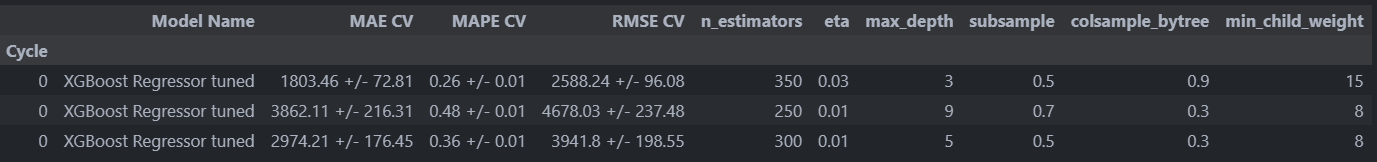

In [187]:
Image(filename='..\\..\\Assets\\Images\\Random_search_3_cycles_training.png', width=1500, height=160)

### Final Model

O modelo final só surge após o treinamento do modelo com todos os parâmetros finais otimizados.
- Os testes de desempenho já foram feitos na fase de Cross Validation 
    - O modelo XGBoost foi o melhor por ter o menor RMSE entre todos
- Os parâmetros finais foram descobertos na fase de Random Search
- Ele será treinado e refinado com esses parâmetros escolhidos
- Vamos fazer uma predição para o dataset de teste (y_test) para testar seu desempenho final de negócio
- Então vamos salvar o modelo em um arquivo binário .pkl para uso posterior no Deployment

In [188]:
param_tuned =   {
                'objective':'reg:squarederror',
                'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3 
                }

In [189]:
# model
model_xgbr_tuned = XGBRegressor(**param_tuned).fit(X_train,y_train)

In [190]:
# saving tuned model
save_model(model_xgbr_tuned, 'XGBoost_Regressor_Tuned')

XGBoost_Regressor_Tuned saved successfully!


True

In [191]:
import gc
gc.collect()

260

### Metrics Interpretation

Nesta fase vamos entender quais são as métricas de erro usadas em Data Science e quais os seus usos principais.

Temos 5 principais métricas de erro para avaliar o desempeho de um modelo em Data Science, e 3 curvas de desempenho:

#### Business Metrics

- MAE - Mean Absolute Error
    - Atribui peso igual a todos os erros
    - Robusto na presença de outliers, não afetam tanto o resultado
    - Fácil entendimento pelo time de negócios
    - Toda vez que fizermos uma predição, estamos errando na média em 500 dólares pra cima ou pra baixo
- MAPE - Mean Absolute Percentage Error
    - Erro percentual da predição, toda vez que fizermos uma predição, estamos errando em pelo menos 10% do valor predito
    - Mostra o quão longe a predição está do valor real, na média, em porcentagem
- Não podem ser usados quando a variável resposta contém zeros, precisando ser filtrados antes do cálculo

#### Model Metrics

- Sensíveis a outliers, que afetam bastante o resultado
- RMSE - Root Mean Squared Error
    - Atribui maior peso aos erros maiores
    - Por ser sensível a toda a gama de dados disponíveis, é considerado uma das melhores métricas de desempenho
    - Quanto menor, melhor
    - Ideal para medir a performance dos modelos de machine learning
- RMSPE - Root Mean Squared Percentage Error
    - Erro RMSE em porcentagem
- MPE - Mean Percentage Error
    - É uma métrica útil para avaliar pra qual lado mais pende a imprecisão do modelo, para cima ou para baixo nos resultados de negócio, ou seja, se falha mais prevendo o pior ou o melhor caso.
    - Diz apenas se o modelo está mais pendente para subestimar ou superestimar o valor real
    - Se for positivo, o modelo está superestimando, se for negativo, está subestimando o valor real
    - Não pode ser usado quando a variável resposta contém zeros, precisando ser filtrados antes do cálculo
- RMSEE - Root Mean Squared Error of Estimation
    - Erro quadrático médio da predição, ou seja, essa métrica nos dá o erro da diferença de valores entre a predição e o valor real
    - Usado para refinar a precisão das predições
- Curvas de Desempenho
    - ROC - ROC Curve
    - LIFT - Lift Curve
    - AUC - Area Under the ROC Curve

In [192]:
model_dataset = load_dataset('Dataset_Model') 

Current Dataset: Dataset_Model loaded successfully!


In [193]:
model_dataset.head()

store  promo  store_type  assortment  competition_distance  \
0      1      1           2           1   -0.1709677419354838   
1      2      1           0           1   -0.2838709677419355   
2      3      1           0           1     1.903225806451613   
3      4      1           2           3   -0.2758064516129032   
4      5      1           0           1     4.448387096774193   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  ...     day_of_week_cos  \
0                 31               2015  ... -0.2225209339563146   
1                 13               2010  ... -0.2225209339563146   
2                 14               2011  ... -0.2225209339563146   
3                 31               2015  ... -0.2225209339563146   
4                 31               2015  ... -0.2225209339563146   

            month_cos            day_sin            day_cos  \
0 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
1 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
2 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
3 -0.8660254037844388 0.2079116908177585 0.9781476007338058   
4 -0.8660254037844388 0.2079116908177585 0.9781476007338058   

     week_of_year_sin    week_of_year_cos           month_sin  year  \
0 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
1 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
2 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
3 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   
4 -0.5680647467311556 -0.8229838658936566 -0.4999999999999997   1.0   

         date             sales  
0  2015-07-31 8.568646473005153  
1  2015-07-31  8.71028982137815  
2  2015-07-31 9.025816391627028  
3  2015-07-31  9.54652685348758  
4  2015-07-31 8.481151420068972  

[5 rows x 23 columns]

In [194]:
model_dataset[['sales']].head()

sales
0 8.568646473005153
1  8.71028982137815
2 9.025816391627028
3  9.54652685348758
4 8.481151420068972

In [195]:
# training dataset
X_train = model_dataset[model_dataset['date'] < '2015-06-05']
y_train = X_train['sales']
# test dataset
X_test = model_dataset[model_dataset['date'] >= '2015-06-05']
y_test = X_test['sales']

X_train = X_train[feature_selection_cols]
X_test = X_test[feature_selection_cols]

In [196]:
def load_model(model_name):
    if '.pkl' in model_name:
        model_name.replace('.pkl', '')
    model_name = '..//..//..//Data//Models//' + model_name + '.pkl'
    model = pickle.load(open(model_name, 'rb'))
    return model

final_model = load_model('XGBoost_Regressor_Tuned')

In [197]:
# prediction
y_pred = final_model.predict(X_test)

# performance
final_model_result = model_metrics('XGBoost Regressor Tuned', y_test, y_pred, 'Exponential')

#final_result = pd.DataFrame()

In [198]:
#concatenate the dataframes horizontally
#final_result = pd.concat([final_result, modelling_result_cv], axis=1)
#final_result = pd.concat([final_result, final_model_result])
#final_result.set_index('Model Name', inplace=True)

In [199]:
#final_result
final_model_result

Model Name      MAE   MAPE      RMSE     MPE
0  XGBoost Regressor Tuned 779.5966 0.1205 1096.4063 -0.0398

#### MAE e MAPE

Primeiro vamos ver qual o máximo e mínimo da nossa variável resposta para descobrir qual sua faixa(range) de valores.

In [200]:
print(np.expm1(y_test).min(), np.expm1(y_test).max())

569.0000000000002 41550.99999999998


Range da variável resposta:

In [201]:
np.expm1(y_test).max()-np.expm1(y_test).min()

40981.99999999998

In [202]:
#final_result
final_model_result

Model Name      MAE   MAPE      RMSE     MPE
0  XGBoost Regressor Tuned 779.5966 0.1205 1096.4063 -0.0398

Se temos um MAE de 779, quanto % isso representa do nosso range da variável resposta?

In [203]:
print(str(round(779/41000 * 100, 2)) + '%')

1.9%


Se temos um MAE de 665, quanto % isso representa do nosso valor médio variável resposta?

In [204]:
np.expm1(y_test).mean()

7016.525193763107

In [205]:
print(str(round(779/np.expm1(y_test).mean() * 100, 2)) + '%')

11.1%


Em média fazemos vendas de 7016 dólares, e pra cada predição que fizermos, temos um erro de 665 dólares, que é cerca de 11% deste valor.

O MAPE é a representação em porcentagem do MAE.

#### RMSE e MPE

Métricas mais usadas para avaliar o desempenho do modelo

In [206]:
#final_result
final_model_result

Model Name      MAE   MAPE      RMSE     MPE
0  XGBoost Regressor Tuned 779.5966 0.1205 1096.4063 -0.0398

In [207]:
print(str(round(1096/np.expm1(y_test).mean() * 100, 2)) + '%')

15.62%


Isso signifca que, considerando todos os valores do dataset, inclusive os outliers, o modelo está errando em 15.62% dos casos na sua previsão do valor real.

O que significa que está acertando em 84.38% dos casos, considerando apenas esta métrica.

O MPE é negativo, o que indica que o valor predito tende a ser maior do que o valor real, ou seja, o ponto fraco do modelo é no melhor caso.

# Deployment Phase

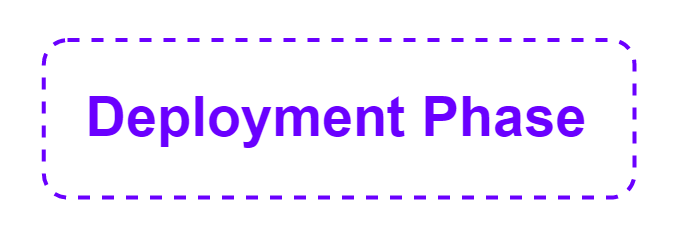

In [208]:
Image(filename='..\\..\\Assets\\Images\\Deployment Phase.png', width=250, height=100)

## Visualization and Dashboard

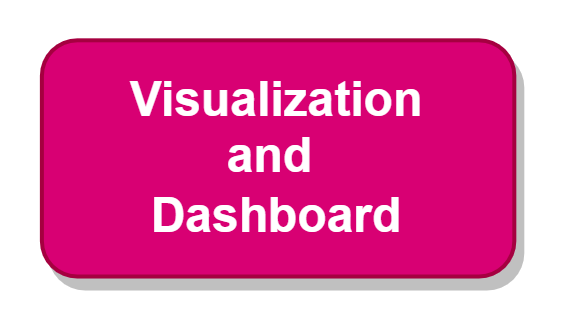

In [209]:
Image(filename='..\\..\\Assets\\Images\\Visualization and Dashboard.png', width=200, height=100)

### Visualization and Dashboard Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [210]:
# df7 = df6.copy()
#print("Checkpoint successful")

In [211]:
# df7.head()

### Performance assessment

Como avaliamos a performance do modelo contra a performance do negócio? Isto é, conseguimos melhorias de desempenho com o modelo? Como aferir isso? É nesta fase que verificamos se todo o treinamento e refinamento do modelo valeram a pena em relação ao que já tinhamos previamente do negócio.

#### Performance Features

Para avaliar a performance do modelo vamos criar algumas colunas extras no dataset final

In [212]:
model_dataset.shape, y_pred.shape

((844338, 23), (54835,))

Como podemos ver, o dataset final tem muito mais linhas do que o de predição, isso porque a predição só trata das últimas 8 semanas, na coluna Data do dataset final.
para podermos fundir a coluna de predição com o dataset final e formar o dataset de visualização vamos ter que descartar as linhas as quais não temos dados de predição, ou seja, as linhas que foram usadas para treino.

Isso equivale a chamar nosso novo dataset de visualização como o dataset que fora usado para treino nos passos anteriores.

Vamos checar a quantidade de linha dos dois para confirmar.

In [213]:
model_dataset.shape, y_pred.shape, X_test.shape

((844338, 23), (54835,), (54835, 21))

Como suspeitamos, as linhas são idênticas na coluna de predição e de teste. Então nosso dataset de visualização precisa ser exatamente igual a coluna que foi de teste dos modelos. 
É o que faremos agora.
Este foi o filtro que usamos para gerar a coluna de teste:

In [214]:
print("X_test = model_dataset[model_dataset['date'] >= '2015-06-05']")

X_test = model_dataset[model_dataset['date'] >= '2015-06-05']



E é o que vamos usar agora no model_dataset para criar o de visualização.

In [215]:
# viz_dataset
viz_dataset = model_dataset[model_dataset['date'] >= '2015-06-05'] #previously X_test

In [216]:
viz_dataset[['sales']].head()

sales
0 8.568646473005153
1  8.71028982137815
2 9.025816391627028
3  9.54652685348758
4 8.481151420068972

In [217]:
y_pred.shape, viz_dataset.shape

((54835,), (54835, 23))

Vamos regredir o scaling da variável resposta para o valor real, pois assim a visualização dos gráficos não ficará distorcida e com valores baixos demais.

Nós rescalamos quando vamos treinar e predizer, mas retornamos ao valor real da variável resposta quando vamos avaliar métricas do modelo e visualizar o desempenho final.

In [218]:
# rescale target variable
viz_dataset['sales'] = np.expm1(viz_dataset['sales'])
viz_dataset['predictions'] = np.expm1(y_pred)
viz_dataset['error_pred'] = viz_dataset['sales'] - viz_dataset['predictions']
viz_dataset['error_rate'] = viz_dataset['predictions']/viz_dataset['sales']

In [219]:
# get predictions
viz_dataset[['sales','predictions','error_pred','error_rate']].sample(10)

sales      predictions          error_pred  \
62240  5349.000000000005    4794.68359375   554.3164062500045   
40488  7308.999999999999  6641.3740234375   667.6259765624991   
27895  4270.999999999998  4539.1025390625  -268.1025390625018   
60118  4989.000000000002 5835.58837890625  -846.5883789062482   
56116 3987.0000000000005 5288.71533203125 -1301.7153320312495   
47437 10010.000000000011   11446.23828125  -1436.238281249989   
19934  8035.999999999995  9009.4228515625  -973.4228515625045   
55934  5408.000000000004     6339.8515625  -931.8515624999964   
27591  5242.000000000005  5213.3603515625  28.639648437504547   
7212   12676.00000000001      12960.21875  -284.2187499999909   

              error_rate  
62240 0.8963700866984475  
40488 0.9086570014280341  
27895  1.062772778989113  
60118  1.169690995972389  
56116 1.3264899252649234  
47437 1.1434803477772215  
19934 1.1211327590296796  
55934  1.172309830343934  
27591 0.9945365035411095  
7212  1.0224218010413373

In [220]:
viz_cols = Flexlist(viz_dataset.columns.tolist())
print(viz_cols, type(viz_cols) )

['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'year', 'date', 'sales', 'predictions', 'error_pred', 'error_rate'] <class '__main__.Flexlist'>


In [221]:
def list_indexer(list_data):
    list_indexer = pd.DataFrame()
    for item in enumerate(viz_cols):
        #put every item in the list into the dataframe as two columns
        list_indexer = list_indexer.append(pd.DataFrame({'Number': [item[0]], 'Column_name': [item[1]]}))
    list_indexer.set_index('Number', inplace=True)
    return list_indexer

In [222]:
list_indexer(viz_cols)

Column_name
Number                              
0                              store
1                              promo
2                         store_type
3                         assortment
4               competition_distance
5       competition_open_since_month
6        competition_open_since_year
7                             promo2
8                  promo2_since_week
9                  promo2_since_year
10            competition_time_month
11                   promo_time_week
12                   day_of_week_sin
13                   day_of_week_cos
14                         month_cos
15                           day_sin
16                           day_cos
17                  week_of_year_sin
18                  week_of_year_cos
19                         month_sin
20                              year
21                              date
22                             sales
23                       predictions
24                        error_pred
25                        error_rate

In [223]:
ordered_vis_cols = viz_cols[[21,0,1,2,3,4,22,23,24,25]]
print(ordered_vis_cols)

['date', 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'sales', 'predictions', 'error_pred', 'error_rate']


In [224]:
viz_dataset = viz_dataset[ordered_vis_cols]
viz_dataset.head()

date  store  promo  store_type  assortment  competition_distance  \
0  2015-07-31      1      1           2           1   -0.1709677419354838   
1  2015-07-31      2      1           0           1   -0.2838709677419355   
2  2015-07-31      3      1           0           1     1.903225806451613   
3  2015-07-31      4      1           2           3   -0.2758064516129032   
4  2015-07-31      5      1           0           1     4.448387096774193   

              sales      predictions          error_pred         error_rate  
0 5262.999999999997     5524.5859375 -261.58593750000273 1.0497028192095768  
1 6064.000000000002 5935.94287109375  128.05712890625182 0.9788823995866999  
2 8314.000000000004  9631.3916015625 -1317.3916015624964 1.1584546068754504  
3 13995.00000000001 11491.0419921875   2503.958007812509 0.8210819572838508  
4 4822.000000000001        6199.4375  -1377.437499999999 1.2856568851099126

Notamos um problema aqui, as datas estão invertidas, no .head() do dataset temos a última data disponível, mas nosso filtro foi:

In [225]:
print("X_test = model_dataset[model_dataset['date'] >= '2015-06-05']")

X_test = model_dataset[model_dataset['date'] >= '2015-06-05']


Então as datas deveriam começar a partir de '2015-06-05', e não de '2015-07-31', um mês depois.

Vamos confirmar isso vendo os valores máximo e mínimo da coluna de data.

In [226]:
viz_dataset['date'].min(), viz_dataset['date'].head().iloc[0], viz_dataset['date'].max(), viz_dataset['date'].tail().iloc[0]

('2015-06-05', '2015-07-31', '2015-07-31', '2015-06-05')

Confirmamos que a data mais longe consta no começo do dataset, que é o contrário do que queremos. Ter as datas invertidas vai afetar nos gráficos e visualizações futuras, portanto precisamos inverter isso antes.

In [227]:
viz_dataset = viz_dataset.reindex(index=viz_dataset.index[::-1]) 
viz_dataset.reset_index(inplace=True, drop=True)
viz_dataset.head()

date  store  promo  store_type  assortment  competition_distance  \
0  2015-06-05   1115      1           3           3    0.4870967741935484   
1  2015-06-05   1114      1           0           3   -0.2354838709677419   
2  2015-06-05   1113      1           0           3     1.117741935483871   
3  2015-06-05   1112      1           2           3   -0.0725806451612903   
4  2015-06-05   1111      1           0           1   -0.0693548387096774   

               sales      predictions         error_pred         error_rate  
0 11435.000000000022   8289.505859375  3145.494140625022 0.7249239929492771  
1  26868.99999999999  23314.892578125  3554.107421874989 0.8677246111922665  
2             6050.0  7670.8017578125   -1620.8017578125 1.2679011169938017  
3 12701.999999999989   11001.51953125  1700.480468749989 0.8661249827783034  
4  5661.000000000005 5716.81689453125 -55.81689453124545 1.0098599001115078

In [228]:
viz_dataset['date'].min(), viz_dataset['date'].head().iloc[0], viz_dataset['date'].max(), viz_dataset['date'].tail().iloc[0]

('2015-06-05', '2015-06-05', '2015-07-31', '2015-07-31')

In [229]:
# sum of sales
viz_store_sales = viz_dataset[['store', 'sales']].groupby('store').sum().reset_index()
viz_store_sales.head()

store              sales
0      1           214244.0
1      2 240345.00000000003
2      3 341813.99999999994
3      4           479808.0
4      5           221909.0

In [230]:
# sum of predictions
viz_store_pred = viz_dataset[['store', 'predictions']].groupby('store').sum().reset_index()
viz_store_pred.head()

store   predictions
0      1     230020.25
1      2  244011.21875
2      3  360865.40625
3      4    466542.625
4      5 237079.484375

In [231]:
# MAE and MAPE
viz_store_MAE = viz_dataset[['store', 'sales', 'predictions']].groupby('store').\
    apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).\
        reset_index().rename(columns={0:'MAE'})
viz_store_MAE.head()

store                MAE
0      1  400.8695392219383
1      2 422.91903997927284
2      3  697.4664829799119
3      4  789.6892139668357
4      5 399.74895866549747

In [232]:
viz_store_MAPE = viz_dataset[['store', 'sales', 'predictions']].groupby('store').\
    apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).\
        reset_index().rename(columns={0:'MAPE'})
viz_store_MAPE.head()

store                MAPE
0      1   0.095376070047754
1      2 0.09042912088811104
2      3 0.09618545744449081
3      4 0.07975806402910211
4      5 0.09985205161121626

In [233]:
# Merge
viz_store = pd.merge(viz_store_pred, viz_store_sales, how='inner', on='store')
viz_store = pd.merge(viz_store,viz_store_MAE, how='inner', on='store')
viz_store = pd.merge(viz_store,viz_store_MAPE, how='inner', on='store')
viz_store.head()

store   predictions              sales                MAE  \
0      1     230020.25           214244.0  400.8695392219383   
1      2  244011.21875 240345.00000000003 422.91903997927284   
2      3  360865.40625 341813.99999999994  697.4664829799119   
3      4    466542.625           479808.0  789.6892139668357   
4      5 237079.484375           221909.0 399.74895866549747   

                 MAPE  
0   0.095376070047754  
1 0.09042912088811104  
2 0.09618545744449081  
3 0.07975806402910211  
4 0.09985205161121626

In [234]:
viz_dataset.shape, viz_store.shape

((54835, 10), (1115, 5))

In [235]:
viz_dataset.shape[0] - viz_store.shape[0]

53720

Vamos calcular os possíveis cenários de venda por loja, para isso vamos usar a coluna de predição e a coluna de erro médio absoluto.
- Para o melhor cenário, somamos o MAE com o valor da predição
- Para o pior cenário, subtraimos o MAE do valor da predição

In [236]:
# Scenarios
viz_store['worst scenario'] = viz_store['predictions'] - viz_store['MAE']
viz_store['best scenario'] = viz_store['predictions'] + viz_store['MAE']
# order columns
viz_store = viz_store[['store', 'predictions', 'sales','worst scenario', 'best scenario', 'MAE', 'MAPE']]
# per store dataset
viz_store.sort_values('MAPE', ascending=False).head()

store   predictions              sales     worst scenario  \
901    902    287840.625 196316.99999999997  285972.7961475606   
169    170  283547.03125           201657.0 281875.80610251916   
291    292 179860.453125           211425.0  177573.0586331275   
908    909  344135.40625  492426.0000000002 338649.77978515625   
769    770   304928.1875           236131.0  303495.9950275032   

         best scenario                MAE                MAPE  
901  289708.4538524394 1867.8288524394138  0.4671637285345609  
169 285218.25639748084 1671.2251474808672 0.41447799906824484  
291  182147.8476168725  2287.394491872479   0.401592933442495  
908 349621.03271484375  5485.626464843756 0.36370253478281894  
769  306360.3799724968 1432.1924724968105  0.3570706195106302

In [237]:
viz_store.head()

store   predictions              sales     worst scenario  \
0      1     230020.25           214244.0 229619.38046077805   
1      2  244011.21875 240345.00000000003  243588.2997100207   
2      3  360865.40625 341813.99999999994  360167.9397670201   
3      4    466542.625           479808.0 465752.93578603317   
4      5 237079.484375           221909.0  236679.7354163345   

       best scenario                MAE                MAPE  
0 230421.11953922195  400.8695392219383   0.095376070047754  
1  244434.1377899793 422.91903997927284 0.09042912088811104  
2  361562.8727329799  697.4664829799119 0.09618545744449081  
3 467332.31421396683  789.6892139668357 0.07975806402910211  
4  237479.2333336655 399.74895866549747 0.09985205161121626

In [238]:
viz_business_scenarios_line = viz_store[['store','predictions','sales', 'worst scenario', 'best scenario']]
viz_business_scenarios_line.shape

(1115, 5)

In [239]:
viz_business_scenarios_line.head()

store   predictions              sales     worst scenario  \
0      1     230020.25           214244.0 229619.38046077805   
1      2  244011.21875 240345.00000000003  243588.2997100207   
2      3  360865.40625 341813.99999999994  360167.9397670201   
3      4    466542.625           479808.0 465752.93578603317   
4      5 237079.484375           221909.0  236679.7354163345   

       best scenario  
0 230421.11953922195  
1  244434.1377899793  
2  361562.8727329799  
3 467332.31421396683  
4  237479.2333336655

Vamos cortar um pouco a quantidade de linhas para a visualização ficar mais clara, com todas elas fica muito dificil diferenciar o lineplot.

In [240]:
# cut viz_business_scenarios_line
viz_business_scenarios_global = viz_business_scenarios_line.iloc[0:501]
viz_business_scenarios_line = viz_business_scenarios_line.iloc[0:301]
viz_business_scenarios_line.shape, viz_business_scenarios_global.shape

((301, 5), (501, 5))

In [241]:
viz_business_scenarios = viz_store[['predictions', 'worst scenario', 'best scenario']].\
    apply(lambda x: np.sum(x), axis=0).reset_index().\
        rename(columns={'index': 'Scenario', 0:'Values'})
viz_business_scenarios['Values'] = viz_business_scenarios['Values'].map( 'R${:,.2f}'.format )
viz_business_scenarios

Scenario            Values
0     predictions  R$387,282,048.00
1  worst scenario  R$386,411,763.52
2   best scenario  R$388,152,313.17

In [242]:
save_dataset(viz_dataset, 'Dataset_Viz_8_weeks')
save_dataset(viz_store, 'Dataset_Viz_Store_8_weeks')
save_dataset(viz_business_scenarios_line, 'Dataset_Viz_Business_Line')
save_dataset(viz_business_scenarios_global, 'Dataset_Viz_Business_Global')
save_dataset(viz_business_scenarios, 'Dataset_Viz_Business_Scenarios')

Previous Dataset: Dataset_Viz_8_weeks deleted!
Current Dataset: Dataset_Viz_8_weeks saved successfully!
With size: 5.8 MB!
Previous Dataset: Dataset_Viz_Store_8_weeks deleted!
Current Dataset: Dataset_Viz_Store_8_weeks saved successfully!
With size: 117.4 KB!
Previous Dataset: Dataset_Viz_Business_Line deleted!
Current Dataset: Dataset_Viz_Business_Line saved successfully!
With size: 20.4 KB!
Previous Dataset: Dataset_Viz_Business_Global deleted!
Current Dataset: Dataset_Viz_Business_Global saved successfully!
With size: 33.9 KB!
Previous Dataset: Dataset_Viz_Business_Scenarios deleted!
Current Dataset: Dataset_Viz_Business_Scenarios saved successfully!
With size: 129.0 bytes!


#### Model Performance

Para isto, o poblema de negócio já deve ter algum tipo de métrica de previsão anterior, por ela será possível avaliar o desempenho do modelo. Como neste caso não temos algo vindo diretamente do negócio, vamos usar o modelo de baseline assumindo que ele já veio pronto com o problema e também as métricas do modelo para prever incrementos de receita junto com melhor e pior caso.

##### Baseline vs Model Performance

In [243]:
# dataframe with baseline_results and tuned_results

model_performance = pd.concat([baseline_result, final_model_result], axis=0)
model_performance.sort_values(by='RMSE', ascending=False, inplace=True)
model_performance.set_index('Model Name', inplace=True)
model_performance

MAE   MAPE      RMSE     MPE
Model Name                                                
Average Model           1352.1875 0.2049  1829.165 -0.1412
XGBoost Regressor Tuned  779.5966 0.1205 1096.4063 -0.0398

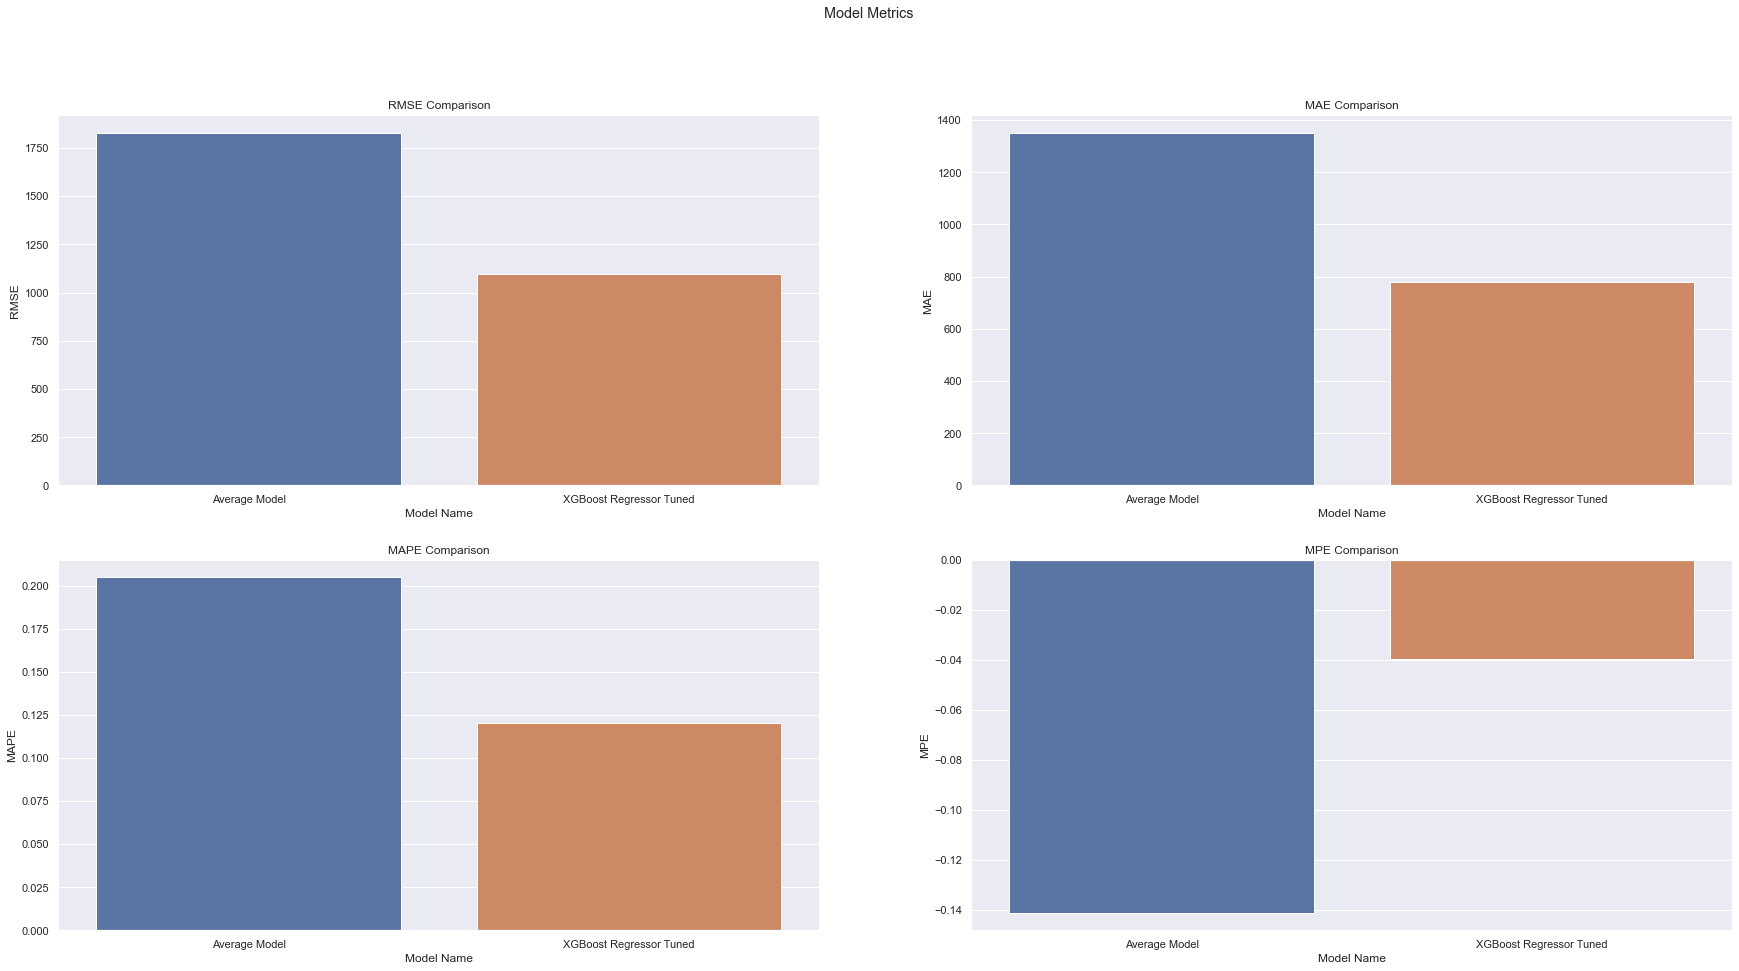

In [244]:
plt.suptitle('Model Metrics')
plt.subplot(2, 2, 1)
plt.title('RMSE Comparison')
sns.barplot(x = model_performance.index, y = 'RMSE', data = model_performance)
plt.subplot(2, 2, 2)
plt.title('MAE Comparison')
sns.barplot(x = model_performance.index, y = 'MAE', data = model_performance)
plt.subplot(2, 2, 3)
plt.title('MAPE Comparison')
sns.barplot(x = model_performance.index, y = 'MAPE', data = model_performance)
plt.subplot(2, 2, 4)
plt.title('MPE Comparison')
sns.barplot(x = model_performance.index, y = 'MPE', data = model_performance)
plt.show()

Vamos ver a distribuição do erro por predição:

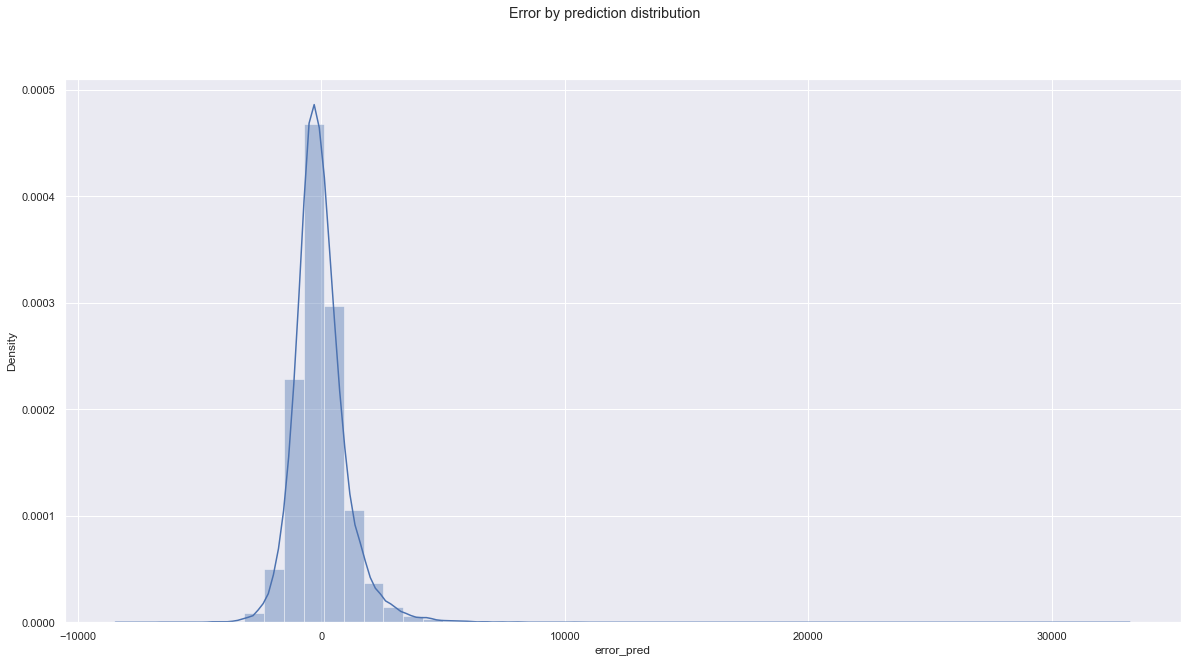

In [245]:
plt.figure(figsize = (20,10))
plt.suptitle('Error by prediction distribution')
sns.distplot(viz_dataset['error_pred'])
plt.show()

#### Model Performance in Business

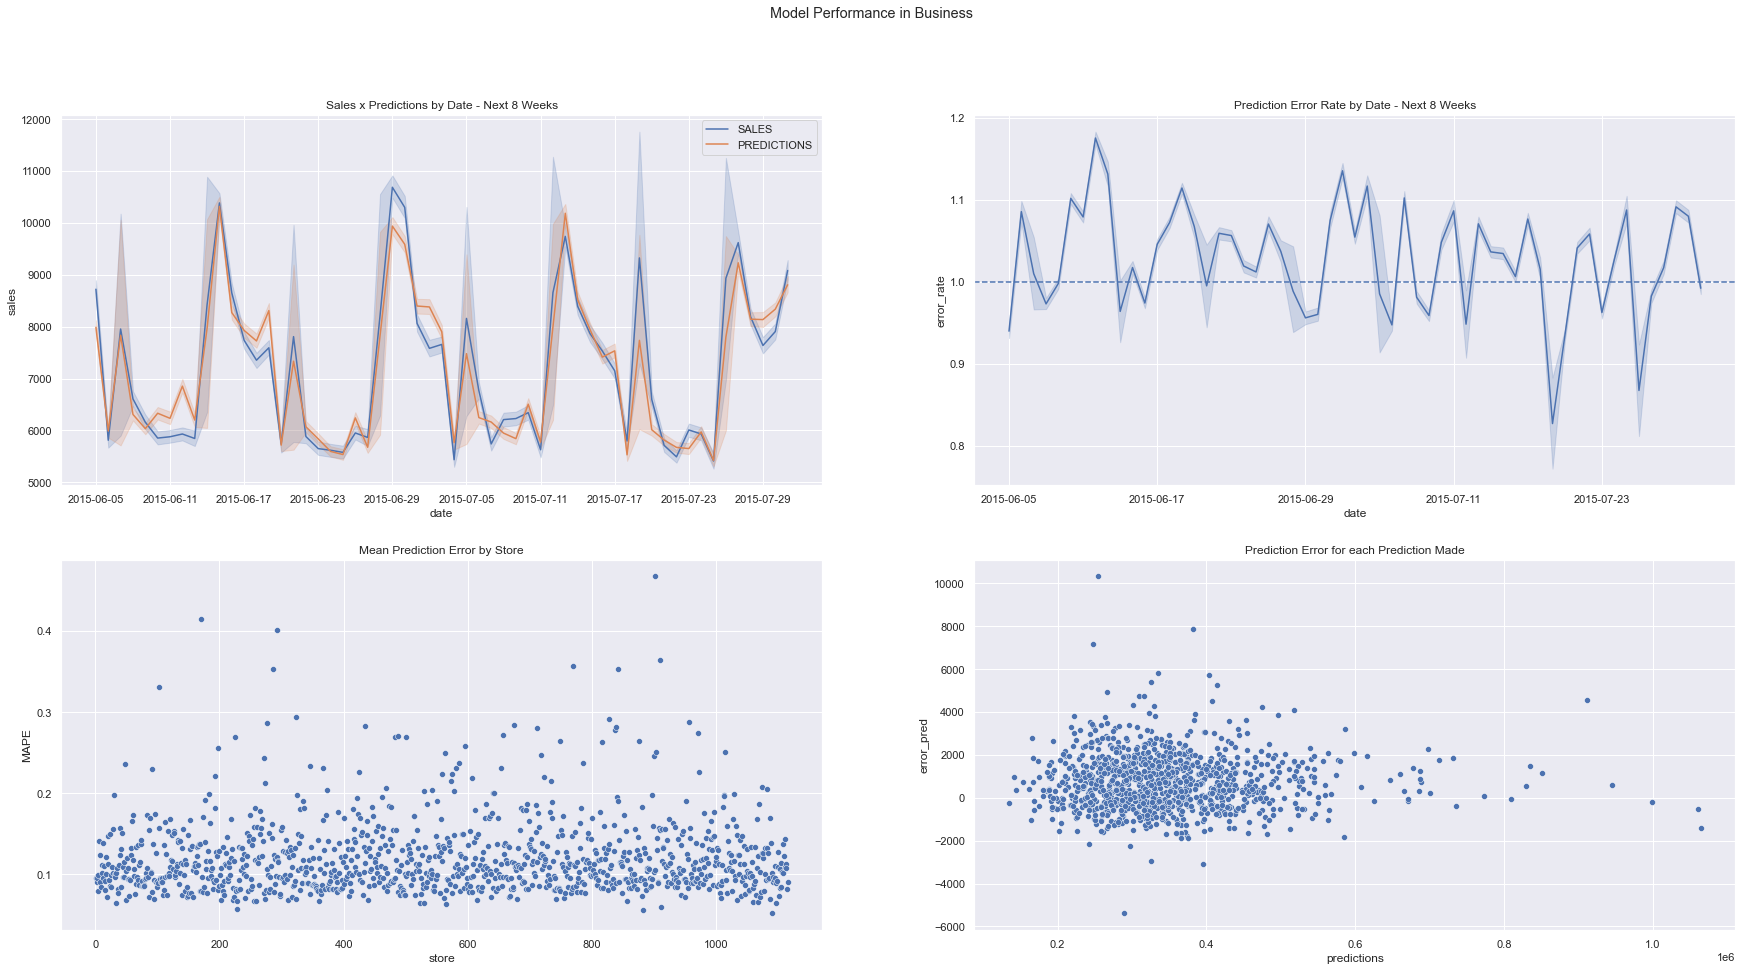

In [246]:
plt.figure(figsize=(30,15))
plt.subplot(2, 2, 1)
plt.suptitle('Model Performance in Business')
plt.title('Sales x Predictions by Date - Next 8 Weeks')
ax  =  plt.gca()
sns.lineplot(x = 'date', y = 'sales', data = viz_dataset, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = viz_dataset, label = 'PREDICTIONS')
ax.set_xticks(ax.get_xticks()[::6])

plt.subplot(2, 2, 2)
plt.title('Prediction Error Rate by Date - Next 8 Weeks')

ax1  =  plt.gca()
sns.lineplot(x = 'date', y = 'error_rate', data = viz_dataset)
plt.axhline(1, linestyle = '--')
ax1.set_xticks(ax.get_xticks()[::2])

plt.subplot(2, 2, 3)
plt.title('Mean Prediction Error by Store')

sns.scatterplot(x = 'store', y = 'MAPE', data = viz_store)

plt.subplot(2, 2, 4)
plt.title('Prediction Error for each Prediction Made')

sns.scatterplot(viz_store['predictions'], viz_dataset['error_pred'])
plt.show()

#### Business Performance Gain

Aqui vamos ver o que o modelo fez para melhorar o desempenho do negócio, fazendo uma previsão geral de receita para toda a rede de lojas.

Temos o melhor e pior cenário de vendas de toda a rede de lojas, somando todas as lojas, nas próximas 8 semanas.

In [247]:
viz_business_scenarios

Scenario            Values
0     predictions  R$387,282,048.00
1  worst scenario  R$386,411,763.52
2   best scenario  R$388,152,313.17

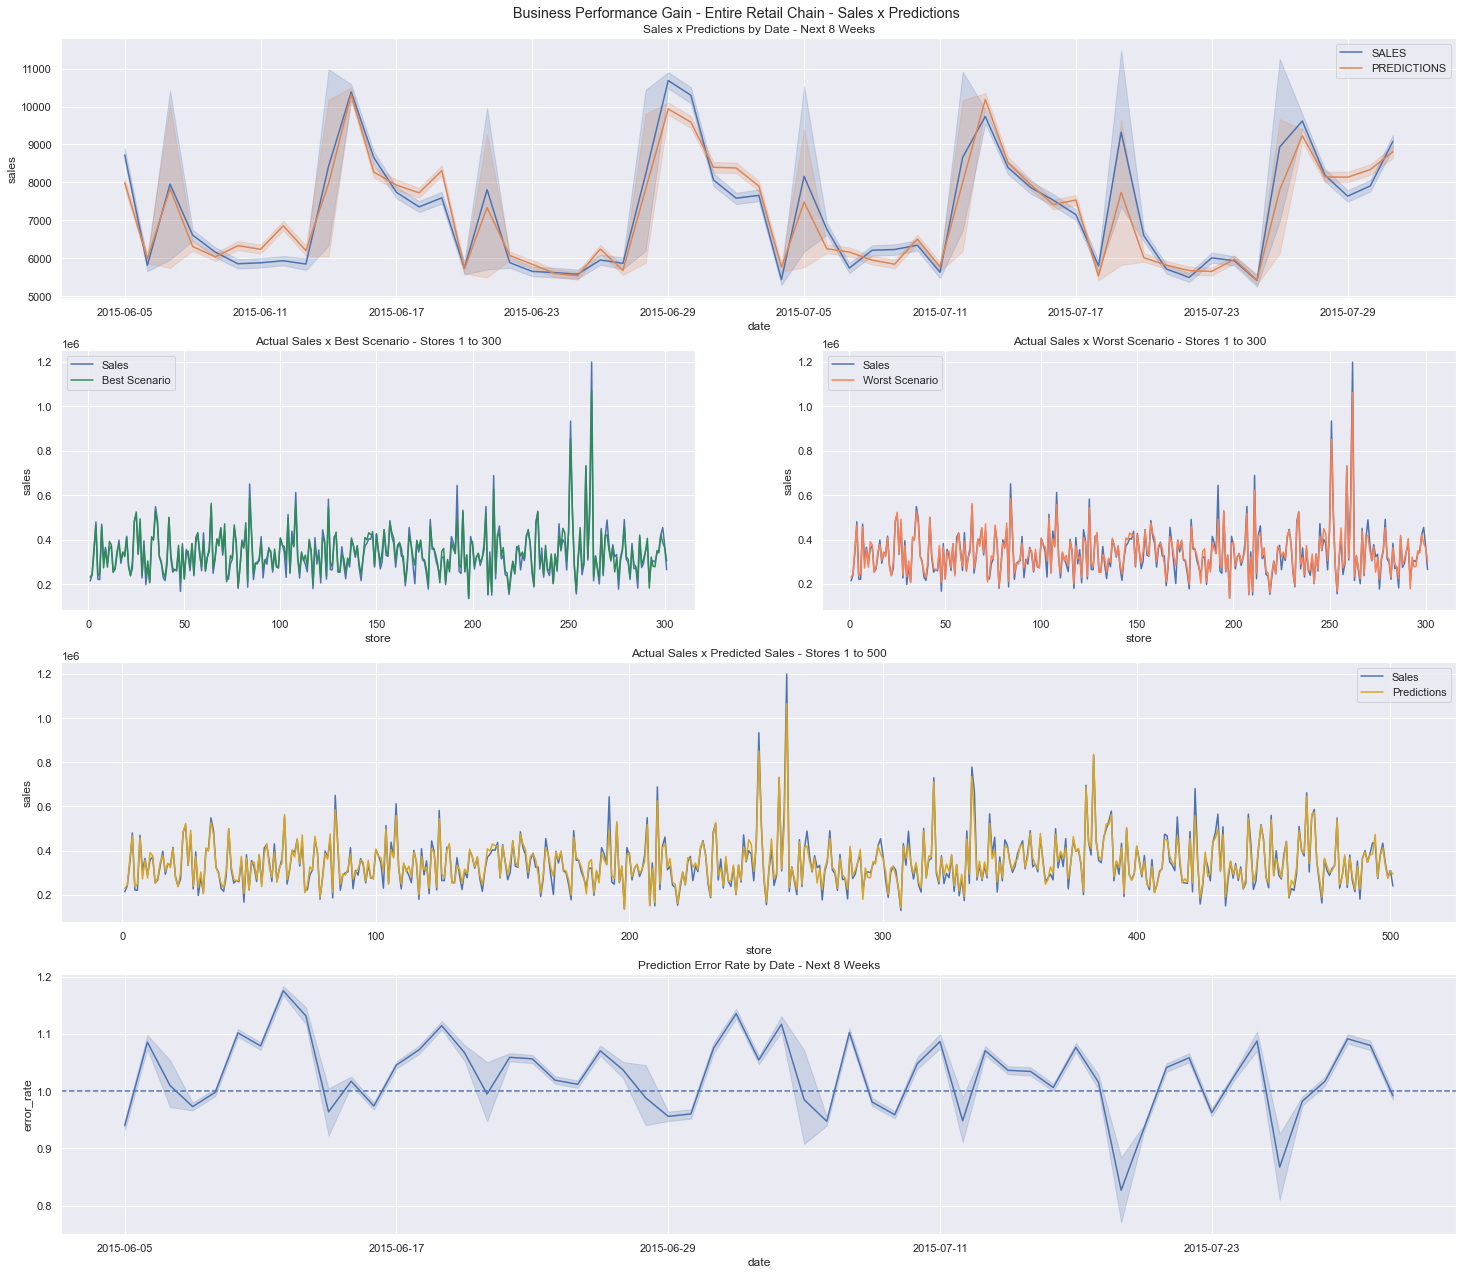

In [248]:
plt.figure(figsize = (25,22))
grid = GridSpec(4, 2)
plt.suptitle('Business Performance Gain - Entire Retail Chain - Sales x Predictions', y = 0.90)

plt.subplot(grid[0,:])

plt.title('Sales x Predictions by Date - Next 8 Weeks')
ax  =  plt.gca()
sns.lineplot(x = 'date', y = 'sales', data = viz_dataset, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = viz_dataset, label = 'PREDICTIONS')
ax.set_xticks(ax.get_xticks()[::6])

plt.subplot(grid[1,0])
plt.title('Actual Sales x Best Scenario - Stores 1 to 300')
sns.lineplot(x = 'store', y = 'sales', data = viz_business_scenarios_line, label = 'Sales')
sns.lineplot(x = 'store', y = 'best scenario', data = viz_business_scenarios_line, label = 'Best Scenario', color  =  'seagreen')

plt.subplot(grid[1,1])
plt.title('Actual Sales x Worst Scenario - Stores 1 to 300')
sns.lineplot(x = 'store', y = 'sales', data = viz_business_scenarios_line, label = 'Sales')
sns.lineplot(x = 'store', y = 'worst scenario', data = viz_business_scenarios_line, label = 'Worst Scenario', color  =  'coral')

plt.subplot(grid[2,:])
plt.title('Actual Sales x Predicted Sales - Stores 1 to 500')
sns.lineplot(x = 'store', y = 'sales', data = viz_business_scenarios_global, label = 'Sales')
sns.lineplot(x = 'store', y = 'predictions', data = viz_business_scenarios_global, label = 'Predictions', color  =  'goldenrod')

plt.subplot(grid[3,:])
plt.title('Prediction Error Rate by Date - Next 8 Weeks')
ax1  =  plt.gca()
sns.lineplot(x = 'date', y = 'error_rate', data = viz_dataset)
plt.axhline(1, linestyle = '--')
ax1.set_xticks(ax.get_xticks()[::2])

plt.show()

Como os dados nos mostram, o modelo final é consideravelmente melhor que o modelo de baseline, chegando a cortar em quase metade o RMSE quando comparado com o mesmo, e o superando também em todas as outras métricas.

Com isto concluimos que após a análise feita, as features selecionadas, o modelo treinado e seus parâmetros refinados, que o modelo final tem maior taxa de sucesso que o método usado anteriormente na predição de vendas.

## Webapp Deployment

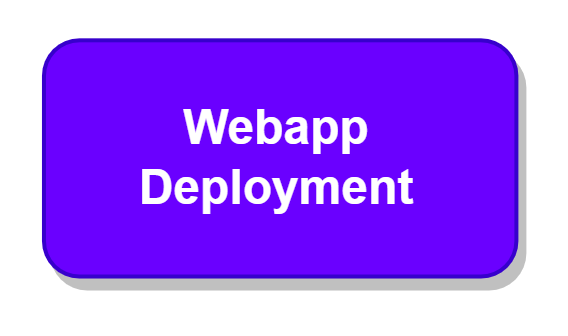

In [249]:
Image(filename='..\\..\\Assets\\Images\\Webapp Deployment.png', width=200, height=100)

### Webapp Deployment Checkpoint

Fazendo um checkpoint, copiamos o dataframe para uma nova variável, isolando os resultados obtidos nesta seção dentro dela e evitando propagações de erros que requeiram a reexecução do notebook inteiro.

In [250]:
# df6 = df5.copy()
#print("Checkpoint successful")

In [251]:
# df6.head()

### API Deployment

#### Prediction Class

Na classe em produção vão ser incluídas as fases:
- Data Collection
- Data Cleaning
    - Todas as fases, pois modificam o dataset diretamente
- Feature Engineering
    - Data Preparation
        - Numerical Variable Treatment
        - Categorical Variable Treatment
        - Cyclic Variable Treatment
        - Target Variable Treatment
        - Encoded dataset
    - Feature Selection
        - Best Features
        - Final Dataset Storage
- Model Building
    - Train-Test Splitting
    - Model Selection
- Model Evaluation
    - Model Hyperparameter Fine Tuning
    - Final Model
- API
    - FastAPI
    - Routes
    - Predict route
    - Predict function
    - Model import with pickle
    - jsonify function
    - pipeline function

In [79]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import os

class Store_Sales_Analysis(object):
    
    def __init__(self):
        self.current_path = os.path.dirname(os.path.abspath(__file__))
        #self.home_path = 'A:\\Andrew\\Desenvolvimento\\Portfolio\\Store Sales Analysis\\Development\\Data\\'
        #\\ when in windows, / when in linux
        self.competition_distance_scaler   = self.load_scaler('/static/models/competition_distance_scaler')
        self.competition_time_month_scaler = self.load_scaler('/static/models/competition_time_month_scaler')
        self.promo_time_week_scaler        = self.load_scaler('/static/models/promo_time_week_scaler')
        self.year_scaler                   = self.load_scaler('/static/models/year_scaler')
        self.store_type_scaler             = self.load_scaler('/static/models/store_type_encoder')

    def load_scaler(self, scaler_name):
        #self.home_path
        scaler = pickle.load(open(self.current_path + scaler_name + '.pkl', 'rb'))
        return scaler

    def data_cleaning(self, df1): 
        
        ## Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        
        cols_new = list(map(snakecase, cols_old))
        
        # rename
        df1.columns = cols_new
        
        ## Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## Fill NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month
        df1['competition_open_since_month'] = \
            df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
            
        #competition_open_since_year 
        df1['competition_open_since_year'] = \
            df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
            
        #promo2_since_week           
        df1['promo2_since_week'] = \
            df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
            
        #promo2_since_year           
        df1['promo2_since_year'] = \
            df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
            
        #promo_interval              
        current_month = \
            {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
            
        df1['current_month'] = df1['date'].dt.month.map(current_month)
        
        df1['promo_interval'].fillna(0, inplace=True)
        
        df1['active_promo'] = \
        df1[['promo_interval', 'current_month']]\
            .apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['current_month'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        ## Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        # Assortment Column
        df1['assortment'] = df1['assortment'].apply(lambda x: 'Basic' if x == 'a' else 'Extra' if x == 'b' else 'Extended')
        
        # State holiday Column
        df1['state_holiday'] = \
            df1['state_holiday'].apply(lambda x: 'Public' if x == 'a' else 'Easter' if x == 'b' else 'Christmas' if x == 'c' else 'Regular_Day')
        
        data_cleaning = df1
        
        return data_cleaning

    def feature_extraction(self, df2):
        
        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = \
            df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = \
            ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
            
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        
        ## Filtragem das Linhas
        # NOTE: Previously: df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        # NOTE: Now: df2 = df2[df2['open'] != 0]
        # NOTE: Because the "sales" column doesn't exists since we're dealing with a test set
        # NOTE: The "sales" column equivalent will be the "prediction" column because we're PREDICTING the sales
        
        df2 = df2[df2['open'] != 0]
        
        ## Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'current_month']
        df2 = df2.drop(cols_drop, axis=1)
        
        feature_extraction = df2
        
        return feature_extraction

    def data_preparation(self, df3):
        
        ## Rescaling 
        # competition distance
        df3['competition_distance'] = self.competition_distance_scaler.fit_transform(df3[['competition_distance']].values)
        
        # competition time month
        df3['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df3[['competition_time_month']].values)
        
        # promo time week
        df3['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df3[['promo_time_week']].values)
        
        # year
        df3['year'] = self.year_scaler.fit_transform(df3[['year']].values)
        
        ### Encoding
        # state_holiday - One Hot Encoding
        df3 = pd.get_dummies(df3, prefix=['state_holiday'], columns=['state_holiday'])
        
        # store_type - Label Encoding
        df3['store_type'] = self.store_type_scaler.fit_transform(df3['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'Basic': 1, 'Extra': 2, 'Extended': 3}
        df3['assortment'] = df3['assortment'].map(assortment_dict)
        
        # day 
        df3['day_sin'] = df3['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df3['day_cos'] = df3['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
        
        # day of week
        df3['day_of_week_sin'] = df3['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df3['day_of_week_cos'] = df3['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
        
        # month
        df3['month_sin'] = df3['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df3['month_cos'] = df3['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
        
        # week of year
        df3['week_of_year_sin'] = df3['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df3['week_of_year_cos'] = df3['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 
            'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin',
            'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
            'week_of_year_cos', 'year']
        
        data_preparation = df3[cols_selected]
        
        return data_preparation
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        # convert to json
        
        prediction = original_data.to_json(orient='records', date_format='iso')
        
        return prediction

#### API Handler

Nesta seção vamos criar o handler que vai ser responsável por fazer a chamada da API.
Nossa API terá dois endpoints:
- /predict
    - Recebe um JSON o número direto da loja a se prever as vendas
- /telegram
    - Recebe um JSON com os dados da requisição ou o número direto da loja a se prever as vendas

In [ ]:
import os
import pickle
import pandas as pd
import requests
import json
from flask import Flask, request, Response, render_template, abort, redirect
#from folder.file import class
from Store_Sales_Analysis import Store_Sales_Analysis
# get token from .env file
token = os.environ.get('Token')

def set_webhook_telegram(url = None, token = None):
    url = url + token
    url = url + '/setWebhook?url=' + url
    api_call = requests.post(url)
    print(f'Status Code {api_call.status_code}')
    return None

def send_message(chat_id = None, text = None, token = None):
    url = f'https://api.telegram.org/bot{token}/'
    url = url + f'sendMessage?chat_id={chat_id}'
    
    api_call = requests.post(url, json = {'text': text })
    print(f'Status Code {api_call.status_code}')
    
    return None

#middleware
def get_prediction(data):
    # API Call
    # makes an API call to /predict endpoint
    url_prod = 'https://andrew-store-sales-analysis.herokuapp.com/predict'
    dev_url = 'http://127.0.0.1:8000/predict'
    #port = os.environ.get('PORT', 8000)
    #'http://localhost:5000/register'
    url = url_prod
    header = {'Content-type': 'application/json'}
    #data = data
    
    api_call = requests.post(url, data = data, headers = header)
    
    print(f'Status Code {api_call.status_code}')
    
    #return str(str(api_call.status_code) + ' ' + str(api_call.text) + 'HERE')
    prediction = pd.DataFrame(api_call.json(), columns = api_call.json()[0].keys())
    #return api_call.json()
    return prediction

def load_model(model_name):
    # loading model in readbytes mode
    current_path = os.path.dirname(os.path.abspath(__file__))
    model = pickle.load(open(current_path + model_name + '.pkl', 'rb'))
    
    return model

def load_dataset(store_id):
    # loading test dataset
    try:
        df_test_raw = pd.read_csv('test.csv')
        df_store_raw = pd.read_csv('store.csv')
        
    except Exception as e:
        print('error loading datasets')
        print(e)
    # merge test dataset + store
    df_test = pd.merge(df_test_raw, df_store_raw, how = 'left', on = 'Store')
    
    # choose store for prediction
    df_test = df_test[df_test['Store'] == store_id]
    
    if not df_test.empty:
        # remove closed days
        df_test = df_test[df_test['Open'] != 0]
        df_test = df_test[~df_test['Open'].isnull()]
        df_test = df_test.drop('Id', axis = 1)
        # convert Dataframe to json
        data = json.dumps(df_test.to_dict(orient = 'records'))
        
    else:
        data = 'error'
        
    return data

def parse_message(message = None):
    
    chat_id = message['message']['chat']['id']
    store_id = message['message']['text']
    store_id = store_id.replace('/', '')
    # if store_id is /start send store_id = '/start' to treat that later
    try:
        store_id = int(store_id)
        
    except ValueError:
        print('Store id needs to be a number')
        store_id = 'error'
        
    return chat_id, store_id

def get_response(response, error = None, endpoint = None,  message_chat_id = None, message_text = None):
    
    #implement with match case with python 3.10
    if response == 0: #debug one
        message =  {'Keys': 'are ok',
                    'message_chat_id': message_chat_id,
                    'message_text': message_text,
                    'endpoint': endpoint}
    elif response == 1:
        message =  {"hello": r"Greetings, I am a telegram bot",
                    "error": r"There are missing keys in the request",
                    "instruction": r"Please send a json object with the following keys:",
                    "message": r"{ chat: {id:chat_id, type:chat_type}, text:/some_text}",
                    "goodbye": f"This proofs you could access the endpoint {endpoint}"}
    elif response == 2:
        message = {"error": "No data received, json empty, please send a valid json object"}
    elif response == 3:
        message = {"error": "No json received, data header doesn't indicate a json object, please send a json object"}
    elif response == 4:
        message = {"error": "Method not allowed"}
    elif response == 5:
        message = {"success": "Message sent to telegram chat successfully with prediction"}
    elif response == 6:
        message =  {"success": "Message sent to telegram chat successfully but no prediction was made",
                    "error": error}
    elif response == 7:
        # greetings message when /start is called
        message = '''Hello! I am a telegram bot.
                    I can predict the sales of a store.
                    Please send me a store number or a table with values to predict the sales. 
                    '''
        return message
    
    message = json.dumps(message)
    
    return message

def check_json(data = None, endpoint = None, method = None):
    
    # check if request.content_type is json or if it is empty
    if (data.content_type != '' and data.is_json): #check if data header indicates json and is not empty
        # remove empty check in case telegram doesn't send correct headers with json type
        # perhaps remove it entirely if telegram doesn't send headers at all
        received_json = data.get_json()
        # log json received
        if any(received_json):
            # check if required keys are in the json
            # can add more later if needed
            try:
                message_chat_id = received_json['message']['chat']['id']
                message_text = received_json['message']['text']
                # log json not empty, keys are in the json
                
            except Exception as e:
                # only error that can occur here is if some key doesn't exist
                # log json not empty, error key not found
                # return instructions
                abort(Response(get_response(1, None, endpoint), status = 400, mimetype = 'application/json'))
                
            finally:
                
                if method == 'GET':
                    # return instructions
                    abort(Response(get_response(1, None, endpoint), status = 400, mimetype = 'application/json'))
                    
                else:
                    
                    # return json
                    return received_json
                # comment when deploying
                # return abort(Response(get_response(0, None, endpoint, message_chat_id, message_text), status = 200, mimetype = 'application/json'))
        else:
            # return error, json is empty
            abort(Response(get_response(2), status = 400, mimetype = 'application/json'))
    else:
        # return error, data header doesn't indicate a json object
        abort(Response(get_response(3), status = 400, mimetype = 'application/json'))

def check_entrypoint(call = None, endpoint = None):
    
    if endpoint in ['/telegram', '/webapp']:
        # external endpoint, need to check if method is GET, POST or other
        if call.method == 'POST':
            #log post method requested
            call_json = check_json(request, endpoint, 'POST')
            
            return call_json
            
        elif call.method == 'GET':
            #log get method requested
            check_json(request, endpoint, 'GET')
            
        else:
            # log other method requested
            # return method not allowed
            abort(Response(get_response(4), status = 400, mimetype = 'application/json'))
            
    elif endpoint == '/predict':
        
        if call.method == 'GET':
            # return instructions
            abort(Response(get_response(1, None, endpoint), status = 400, mimetype = 'application/json'))
        # internal endpoint, no need to check method
        call_json = call.get_json()
        
        return call_json
    
# API initialization
app = Flask(__name__, static_folder='static')

@app.route('/')
@app.route('/home')
def home():
    
    return render_template('index.html')

@app.route('/webapp')
def webapp():
    
    return '<p> Welcome to the webapp </p>'
    # return render_template('webapp.html')

@app.route('/telegram', methods = ['GET', 'POST'])
def telegram_bot():
    
    received_json = check_entrypoint(request, endpoint = '/telegram')
    
    chat_id, store_id = parse_message(received_json)
    #third: command
    if store_id != 'error':
        # loading data
        data = load_dataset(store_id)
        
        # if not returned an empty dataset (string 'error') because store_id doesn't exist
        if data != 'error':
            # prediction call
            prediction_df = get_prediction(data)
            # calculation
            pred_group_df = prediction_df[['store', 'prediction']].groupby('store').sum().reset_index()
            # get store number
            store = pred_group_df['store'].values[0]
            # get prediction value
            prediction = pred_group_df['prediction'].values[0]
            # convert to number
            prediction = float(prediction)
            # send message with store number and prediction in text format to telegram bot chat
            msg = f'Store Number {store} will sell R${prediction:,.3f} in the next 8 weeks'
            
            #print(msg)
            send_message(chat_id, msg, token)
            # return message sent to telegram chat, in this case, success
            return Response(get_response(5), status =200)
        
        else: #command
            error = 'Store Not Available'
            send_message(chat_id, error, token)
            # return message sent to telegram chat, in this case, error
            return Response(get_response(6, error = error), status =200)
        
    else:
        error = 'Store ID must be a number'
        send_message(chat_id, error, token)
        # return message sent to telegram chat, in this case, error
        return Response(get_response(6, error = error), status =200)

@app.route('/predict', methods = ['GET', 'POST'])
def model_predict():
    
    received_json = check_entrypoint(request, endpoint = '/predict')
    
    model = load_model('/static/models/XGBoost_Regressor_Tuned')
    
    # redo this later, strange check (?). Must be a better way to do this
    if isinstance(received_json, dict): # unique example
        
        X_test = pd.DataFrame(received_json, index = [0])
        
    else: # multiple example
        X_test = pd.DataFrame(received_json, columns = received_json[0].keys())
    
    pipeline = Store_Sales_Analysis()
    
    data_cleaned = pipeline.data_cleaning(X_test)
    
    feature_extracted = pipeline.feature_extraction(data_cleaned)
    
    data_prepared = pipeline.data_preparation(feature_extracted)
    
    prediction = pipeline.get_prediction(model, X_test, data_prepared)
    
    #return prediction
    return Response(prediction, status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    port = os.environ.get('PORT', 8000)
    host_prod = os.environ.get('HOST', '0.0.0.0')
    app.run(host = host_prod, port = port)

#### API Tester

Vamos simular uma chamada de API do jeito que ela funcionaria no app final aqui no Notebook de Análise

- Primeiro, carregamos os dataframes com os dados de cada loja.
- Depois, carregamos o dataframe de teste com dados ainda não vistos pelo modelo.

In [ ]:
# loading test dataset
df_test = pd.read_csv("A:\Andrew\Desenvolvimento\Portfolio\Backup\Store Sales Analysis\Development\Data\Dataset\Raw\test.csv")
# merge test dataset + store
df_request = pd.merge(df_test, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_request = df_request[df_request['Store'].isin([40, 22, 41])]

# remove closed days
df_request = df_request[df_request['Open'] != 0]
df_request = df_request[~df_request['Open'].isnull()]
df_request = df_request.drop('Id', axis = 1)
# convert Dataframe to json
data = json.dumps(df_request.to_dict(orient = 'records'))

Agora fazemos a chamada da API, passando o número da loja ou o JSON com os dados da requisição.
- A chamada deve funcionar tanto localmente quanto no Heroku.

In [ ]:
# API Call
url_local = 'http://0.0.0.0:5000/predict'
url_api = 'https://andrew-store-sales-analysis.herokuapp.com/predict'
header = {'Content-type': 'application/json' } 
data = data

response = requests.post(url_api, data = data, headers = header)
print('Status Code {}'.format(r.status_code))
df_response = pd.DataFrame(response.json(), columns = response.json()[0].keys())

In [ ]:
d2 = df_response[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction']))

#### Timer

In [252]:
print("Notebook Start:", str(Start).split(' ')[1].split('.')[0])
      #log.info("Notebook Start =", now)
End = datetime.datetime.now() # time object
print("Notebook End:", str(End).split(' ')[1].split('.')[0])
Execution = End - Start
print("Execution Time:", str(Execution).split('.')[0]) 

Notebook Start: 11:41:35
Notebook End: 12:19:06
Execution Time: 0:37:31
